# Overall evaluation of PSSMs in the PSP dataset

In this notebook, we will evaluate PSSMs derived from two methods:PSPA and CDDM, using kinase-substrate datasets from PhosphoSitePlus (PSP). We will use AUCDF (Area Under Cumulative Distribution Function) to evaluate. AUCDF was previously introduced to evaluate PSSMs in the paper [An atlas of substrate specificities for the human serine/threonine kinome.](https://www.nature.com/articles/s41586-022-05575-3)

## Setup

In [1]:
# !pip install git+https://github.com/sky1ove/katlas.git -Uqq

In [2]:
from katlas.imports import *
import pickle,pandas as pd, seaborn as sns
from matplotlib import pyplot as plt

## Get kinase idx map

In [3]:
info = Data.get_kinase_info().query('pseudo=="0"')

info = info[['kinase','ID_coral','ID_HGNC']].applymap(lambda x: x.upper())

kinase_map = {}
for idx, row in info.iterrows():
    # Add each of the different kinase name formats to the map
    kinase_map[row['ID_coral']] = row['kinase']
    kinase_map[row['ID_HGNC']] = row['kinase']
    # Ensure the kinase name itself is also in the map
    kinase_map[row['kinase']] = row['kinase']

kinase_map['ABL'] = 'ABL1'
kinase_map['HER2'] = 'ERBB2'
kinase_map['ETK'] = 'BMX'
kinase_map['MKK6'] = 'MAP2K6'
kinase_map['MKK4'] = 'MAP2K4'
kinase_map['MKK3'] = 'MAP2K3'
kinase_map['MKK7'] = 'MAP2K7'

kinase_map['ARG'] = 'ABL2'

Uncheck below to save and load kinase_map.pkl

In [4]:
# import pickle
# with open('raw/kinase_map.pkl', 'wb') as file:
#     pickle.dump(kinase_map, file)
    
# with open('kinase_map.pkl', 'rb') as file:
#     loaded_dict = pickle.load(file)

## Load kinase-substrate data from PSP

In [5]:
# load kinase-substrate pairs from PSP
psp = pd.read_csv('raw/PSP_Kinase_Substrate_Dataset.csv')

In [6]:
psp.head()

GENE KINASE KIN_ACC_ID KIN_ORGANISM  SUBSTRATE  SUB_GENE_ID SUB_ACC_ID  \
0  Dyrk2  DYRK2     Q5U4C9        mouse      NDEL1      83431.0     Q9ERR1   
1   Pak2   PAK2     Q64303          rat       MEK1     170851.0     Q01986   
2   Pak2   PAK2     Q64303          rat      PRKD1      85421.0     Q9WTQ1   
3   Pak2   PAK2     Q64303          rat  prolactin      24683.0     P01237   
4   Pak2   PAK2     Q64303          rat  prolactin       5617.0     P01236   

  SUB_GENE SUB_ORGANISM SUB_MOD_RSD  SITE_GRP_ID         site_seq     DOMAIN  \
0    Ndel1        mouse        S336   1869686801  LGSsRPSsAPGMLPL        NaN   
1   Map2k1          rat        S298       448284  RtPGRPLsSYGMDSR    Pkinase   
2    Prkd1          rat        S203       449896  GVRRRRLsNVsLTGL        NaN   
3      Prl          rat        S206       451732  IRCLRRDsHKVDNYL  Hormone_1   
4      PRL        human        S207       451732  LHCLRRDsHKIDNYL  Hormone_1   

  IN_VIVO_RXN IN_VITRO_RXN     CST_CAT#  
0                        X          NaN  
1                        X  9128; 98195  
2           X                       NaN  
3                        X          NaN  
4                        X          NaN

As there are some sequences in 'site_seq' column that do not have s/t/y at the center position, we need to remove them.

In [7]:
# For site sequence
psp = psp.loc[psp.site_seq.str[7].isin(list('stySTY'))]

We also notice that the kinase name in 'KINASE' column is not always consistent (e.g., gene name and protein name are mixed in some cases), so we need to convert the kinase name to a consistent name.

In [8]:
# # load kinase map
# with open('kinase_map.pkl','rb') as f:
#     kinase_map = pickle.load(f)

In [9]:
# for isoform, suppose they have similar recognition pattern; drop the isoform # and take the kinase name
psp.KINASE = psp.KINASE.str.split(' ').str[0].str.upper()

# for fusion form of kinase,get the second item
psp.KINASE = psp.KINASE.apply(lambda x: x.split('-')[1] if '-' in x else x) 

# map various kinase name (coral ID, gene name) to a common name
psp['kinase'] = psp.KINASE.map(kinase_map)

Check kinase that is not mapped:

In [10]:
# kinase not mapped
psp[psp.kinase.isna()].KINASE.value_counts()[:10]

CK2B      20
AMPKB1    15
VEGFR2    15
UL97      14
ILK       13
PKM       12
PIK3CA    11
AMPKG2    10
CSFR      10
VEGFR1     7
Name: KINASE, dtype: int64

In [11]:
# drop kinase not mapped
psp = psp.dropna(subset='kinase')

In [12]:
# drop duplicates
psp = psp[['site_seq','kinase']].drop_duplicates()

In [13]:
psp.site_seq.str[7].value_counts()

s    13543
t     4349
y     3049
Name: site_seq, dtype: int64

## Filter sites and kinase for PSPA scoring

In [14]:
import pandas as pd, numpy as np
from tqdm import tqdm

In [15]:
ref_y = Data.get_pspa_tyr_norm()

ref_st = Data.get_pspa_st_norm()

In [16]:
TK = ref_y.index.str.split('_').str[0].tolist()
ST = ref_st.index.str.split('_').str[0].tolist()

We will use two kinds of inputs for PSPA evaluation:

- All capital (the official method from the Nature paper.)
- With lowercase indicating phosphorylation status

In [17]:
# filter samples, include only available kinase from the reference for scoring
df_st = psp[psp.kinase.isin(ref_st.index)].copy()
df_y = psp[psp.kinase.isin(ref_y.index)].copy()

# keep ST sites
df_st = df_st[df_st.site_seq.str[7].isin(list('stST'))]

# keep Y sites
df_y = df_y[df_y.site_seq.str[7].isin(list('yY'))]

In [18]:
df_st.site_seq.str[7].value_counts()

s    13398
t     4287
Name: site_seq, dtype: int64

In [19]:
df_y.site_seq.str[7].value_counts()

y    2904
Name: site_seq, dtype: int64

In [20]:
# convert site sequence to capital, for percentile calculation
df_st['site_seq_upper'] = df_st['site_seq'].str.upper()
df_y['site_seq_upper'] = df_y['site_seq'].str.upper()

In [21]:
df_st.head()

site_seq kinase   site_seq_upper
0  LGSsRPSsAPGMLPL  DYRK2  LGSSRPSSAPGMLPL
1  RtPGRPLsSYGMDSR   PAK2  RTPGRPLSSYGMDSR
2  GVRRRRLsNVsLTGL   PAK2  GVRRRRLSNVSLTGL
3  IRCLRRDsHKVDNYL   PAK2  IRCLRRDSHKVDNYL
4  LHCLRRDsHKIDNYL   PAK2  LHCLRRDSHKIDNYL

## Multiply score

In [22]:
y_param_multiply = param_PSPA_y
st_param_multiply = param_PSPA_st

In [23]:
# multiply score on all capital
st_mul_up = predict_kinase_df(df_st,'site_seq_upper',**st_param_multiply)

# multiply score on phosphorylated substrates
st_mul_lo = predict_kinase_df(df_st,'site_seq',**st_param_multiply)

input dataframe has a length 17685
Preprocessing
Finish preprocessing
Calculating position: [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4]


100%|██████████| 303/303 [01:26<00:00,  3.52it/s]


input dataframe has a length 17685
Preprocessing
Finish preprocessing
Calculating position: [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4]


100%|██████████| 303/303 [01:05<00:00,  4.61it/s]


In [ ]:
# multiply score on all capital
st_mul_up = predict_kinase_df(df_st,'site_seq_upper',**st_param_multiply)

# multiply score on phosphorylated substrates
st_mul_lo = predict_kinase_df(df_st,'site_seq',**st_param_multiply)

input dataframe has a length 17685
Preprocessing
Finish preprocessing
Calculating position: [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4]


100%|██████████| 303/303 [00:47<00:00,  6.36it/s]


input dataframe has a length 17685
Preprocessing
Finish preprocessing
Calculating position: [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4]


100%|██████████| 303/303 [00:48<00:00,  6.30it/s]


In [24]:
# multiply score on all capital
y_mul_up = predict_kinase_df(df_y,'site_seq_upper',**y_param_multiply)

# multiply score on phosphorylated substrates
y_mul_lo = predict_kinase_df(df_y,'site_seq',**y_param_multiply)

input dataframe has a length 2904
Preprocessing
Finish preprocessing
Calculating position: [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]


100%|██████████| 93/93 [00:03<00:00, 30.73it/s]


input dataframe has a length 2904
Preprocessing
Finish preprocessing
Calculating position: [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]


100%|██████████| 93/93 [00:02<00:00, 34.31it/s]


In [26]:
df_st

site_seq kinase   site_seq_upper
0      LGSsRPSsAPGMLPL  DYRK2  LGSSRPSSAPGMLPL
1      RtPGRPLsSYGMDSR   PAK2  RTPGRPLSSYGMDSR
2      GVRRRRLsNVsLTGL   PAK2  GVRRRRLSNVSLTGL
3      IRCLRRDsHKVDNYL   PAK2  IRCLRRDSHKVDNYL
4      LHCLRRDsHKIDNYL   PAK2  LHCLRRDSHKIDNYL
...                ...    ...              ...
23276  QRVLDtssLtQsAPA   ULK2  QRVLDTSSLTQSAPA
23277  DtssLtQsAPAsPtN   ULK2  DTSSLTQSAPASPTN
23278  LAQPINFsVSLSNSH   ULK2  LAQPINFSVSLSNSH
23279  ESsPILTsFELVKVP   ULK2  ESSPILTSFELVKVP
23280  THRRMVVsMPNLQDI   ULK2  THRRMVVSMPNLQDI

[17685 rows x 3 columns]

## Sum score

In [27]:
y_param_sum = {'ref':Data.get_pspa_tyr_norm(), 'func': sumup}
st_param_sum = {'ref':Data.get_pspa_st_norm(), 'func': sumup}

In [28]:
# sum score on all capital
st_sum_up = predict_kinase_df(df_st,'site_seq_upper',**st_param_sum)

# sum score on phosphorylated substrates
st_sum_lo = predict_kinase_df(df_st,'site_seq',**st_param_sum)

input dataframe has a length 17685
Preprocessing
Finish preprocessing
Calculating position: [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4]


100%|██████████| 303/303 [00:44<00:00,  6.77it/s]


input dataframe has a length 17685
Preprocessing
Finish preprocessing
Calculating position: [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4]


100%|██████████| 303/303 [00:32<00:00,  9.25it/s]


In [29]:
# sum score on all capital
y_sum_up = predict_kinase_df(df_y,'site_seq_upper',**y_param_sum)

# sum score on phosphorylated substrates
y_sum_lo = predict_kinase_df(df_y,'site_seq',**y_param_sum)

input dataframe has a length 2904
Preprocessing
Finish preprocessing
Calculating position: [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]


100%|██████████| 93/93 [00:01<00:00, 91.01it/s] 


input dataframe has a length 2904
Preprocessing
Finish preprocessing
Calculating position: [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]


100%|██████████| 93/93 [00:01<00:00, 79.78it/s] 


## Plot differences of all-capital and phosphorylated

In [30]:
df_y['acceptor'] = df_y.site_seq_upper.str[7]

In [ ]:
palette = get_color_dict(['S','T','Y'],'tab20')

In [ ]:
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")

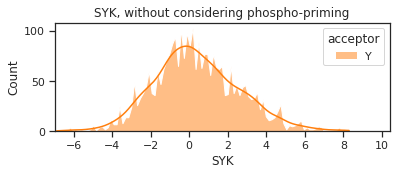

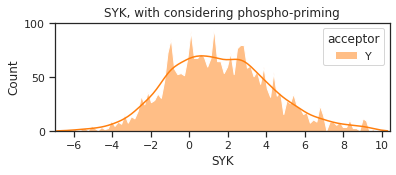

In [ ]:
k = 'SYK'
xmin,xmax = y_mul_lo[k].min()-0.1, y_mul_lo[k].max()+0.1

plot_hist(y_mul_up,k,hue = df_y.acceptor,palette=palette)
plt.title(f'{k}, without considering phospho-priming')
plt.xlim(xmin,xmax);

plot_hist(y_mul_lo,k,hue = df_y.acceptor,palette=palette)
plt.title(f'{k}, with considering phospho-priming')
plt.xlim(xmin,xmax);

### Get score rank

In [31]:
# get rank of multiply score for all capital
y_rnk_mul_up = y_mul_up.rank(axis=1,ascending=False)
st_rnk_mul_up = st_mul_up.rank(axis=1,ascending=False)

# get rank of multiply score for phosphorylated
y_rnk_mul_lo = y_mul_lo.rank(axis=1,ascending=False)
st_rnk_mul_lo = st_mul_lo.rank(axis=1,ascending=False)

In [32]:
# get rank of sum score for all capital
y_rnk_sum_up = y_sum_up.rank(axis=1,ascending=False)
st_rnk_sum_up = st_sum_up.rank(axis=1,ascending=False)

# get rank of sum score for all capital
y_rnk_sum_lo = y_sum_lo.rank(axis=1,ascending=False)
st_rnk_sum_lo = st_sum_lo.rank(axis=1,ascending=False)

As the reference for percentile calculation is calculated based on all-capital sequences, we will calculate percentile score and its rank only for the uppercase one. 

For the lowercase, it should be also noted that the phosphorylation status from PSP might not be accurate, as it includes all high-throughput phosphorylation and low-throughput phosphorylation sites.

### Percentile

Percentile calculation, for all capital only:

In [33]:
# get percentile based on percentile_reference
y_pct_ref = Data.get_pspa_tyr_pct()
st_pct_ref = Data.get_pspa_st_pct()

y_pct = get_pct_df(y_mul_up,y_pct_ref)
st_pct = get_pct_df(st_mul_up,st_pct_ref)

# get percentile rank across kinases
y_pct_rnk = y_pct.rank(axis=1,ascending=False)
st_pct_rnk = st_pct.rank(axis=1,ascending=False)

100%|██████████| 303/303 [00:03<00:00, 90.31it/s]


### Match values

In [36]:
# def match_values(df, rnk):
#     ranks = []
#     for i, r in rnk.iterrows():
#         k = df.kinase[i]
#         ranks.append(r[k])
#     return pd.Series(ranks,index=df.index)

In [37]:
def match_values(df,rnk):
    return pd.Series([rnk.at[k,v] for k,v in df.kinase.items()],index=df.index)

In [38]:
# merge rank values to df
df_y['y_rnk_mul_up'] = match_values(df_y,y_rnk_mul_up)
df_y['y_rnk_mul_lo'] = match_values(df_y,y_rnk_mul_lo)

df_y['y_rnk_sum_up'] = match_values(df_y,y_rnk_sum_up)
df_y['y_rnk_sum_lo'] = match_values(df_y,y_rnk_sum_lo)

In [39]:
# merge rank values to df
df_st['st_rnk_mul_up'] = match_values(df_st,st_rnk_mul_up)
df_st['st_rnk_mul_lo'] = match_values(df_st,st_rnk_mul_lo)

df_st['st_rnk_sum_up'] = match_values(df_st,st_rnk_sum_up)
df_st['st_rnk_sum_lo'] = match_values(df_st,st_rnk_sum_lo)

In [40]:
# for uppercase only
df_y['pct'] = match_values(df_y,y_pct)
df_y['pct_rnk'] = match_values(df_y,y_pct_rnk)

df_st['pct'] = match_values(df_st,st_pct)
df_st['pct_rnk'] = match_values(df_st,st_pct_rnk)

In [ ]:
df_y.head()

site_seq  kinase   site_seq_upper acceptor  y_rnk_mul_up  \
1516  KETEGQFyNYFPN__     ITK  KETEGQFYNYFPN__        Y           8.0   
1517  ETLVIALyDYQTNDP     ITK  ETLVIALYDYQTNDP        Y          25.0   
1518  PNEGDNDyIIPLPDP  PDGFRB  PNEGDNDYIIPLPDP        Y          26.0   
1519  ERKEVsKysDIQRsL  PDGFRB  ERKEVSKYSDIQRSL        Y          44.0   
1520  LDTSSVLyTAVQPNE  PDGFRB  LDTSSVLYTAVQPNE        Y          58.0   

      y_rnk_mul_lo  y_rnk_sum_up  y_rnk_sum_lo     pct  pct_rnk  
1516           8.0          11.0          11.0  83.472     17.5  
1517          25.0          31.0          31.0  39.262     26.0  
1518          26.0          43.0          43.0  98.250     15.0  
1519          63.0          60.0          70.0  58.756     36.0  
1520          58.0          71.0          71.0  58.524     59.0

## Percentile

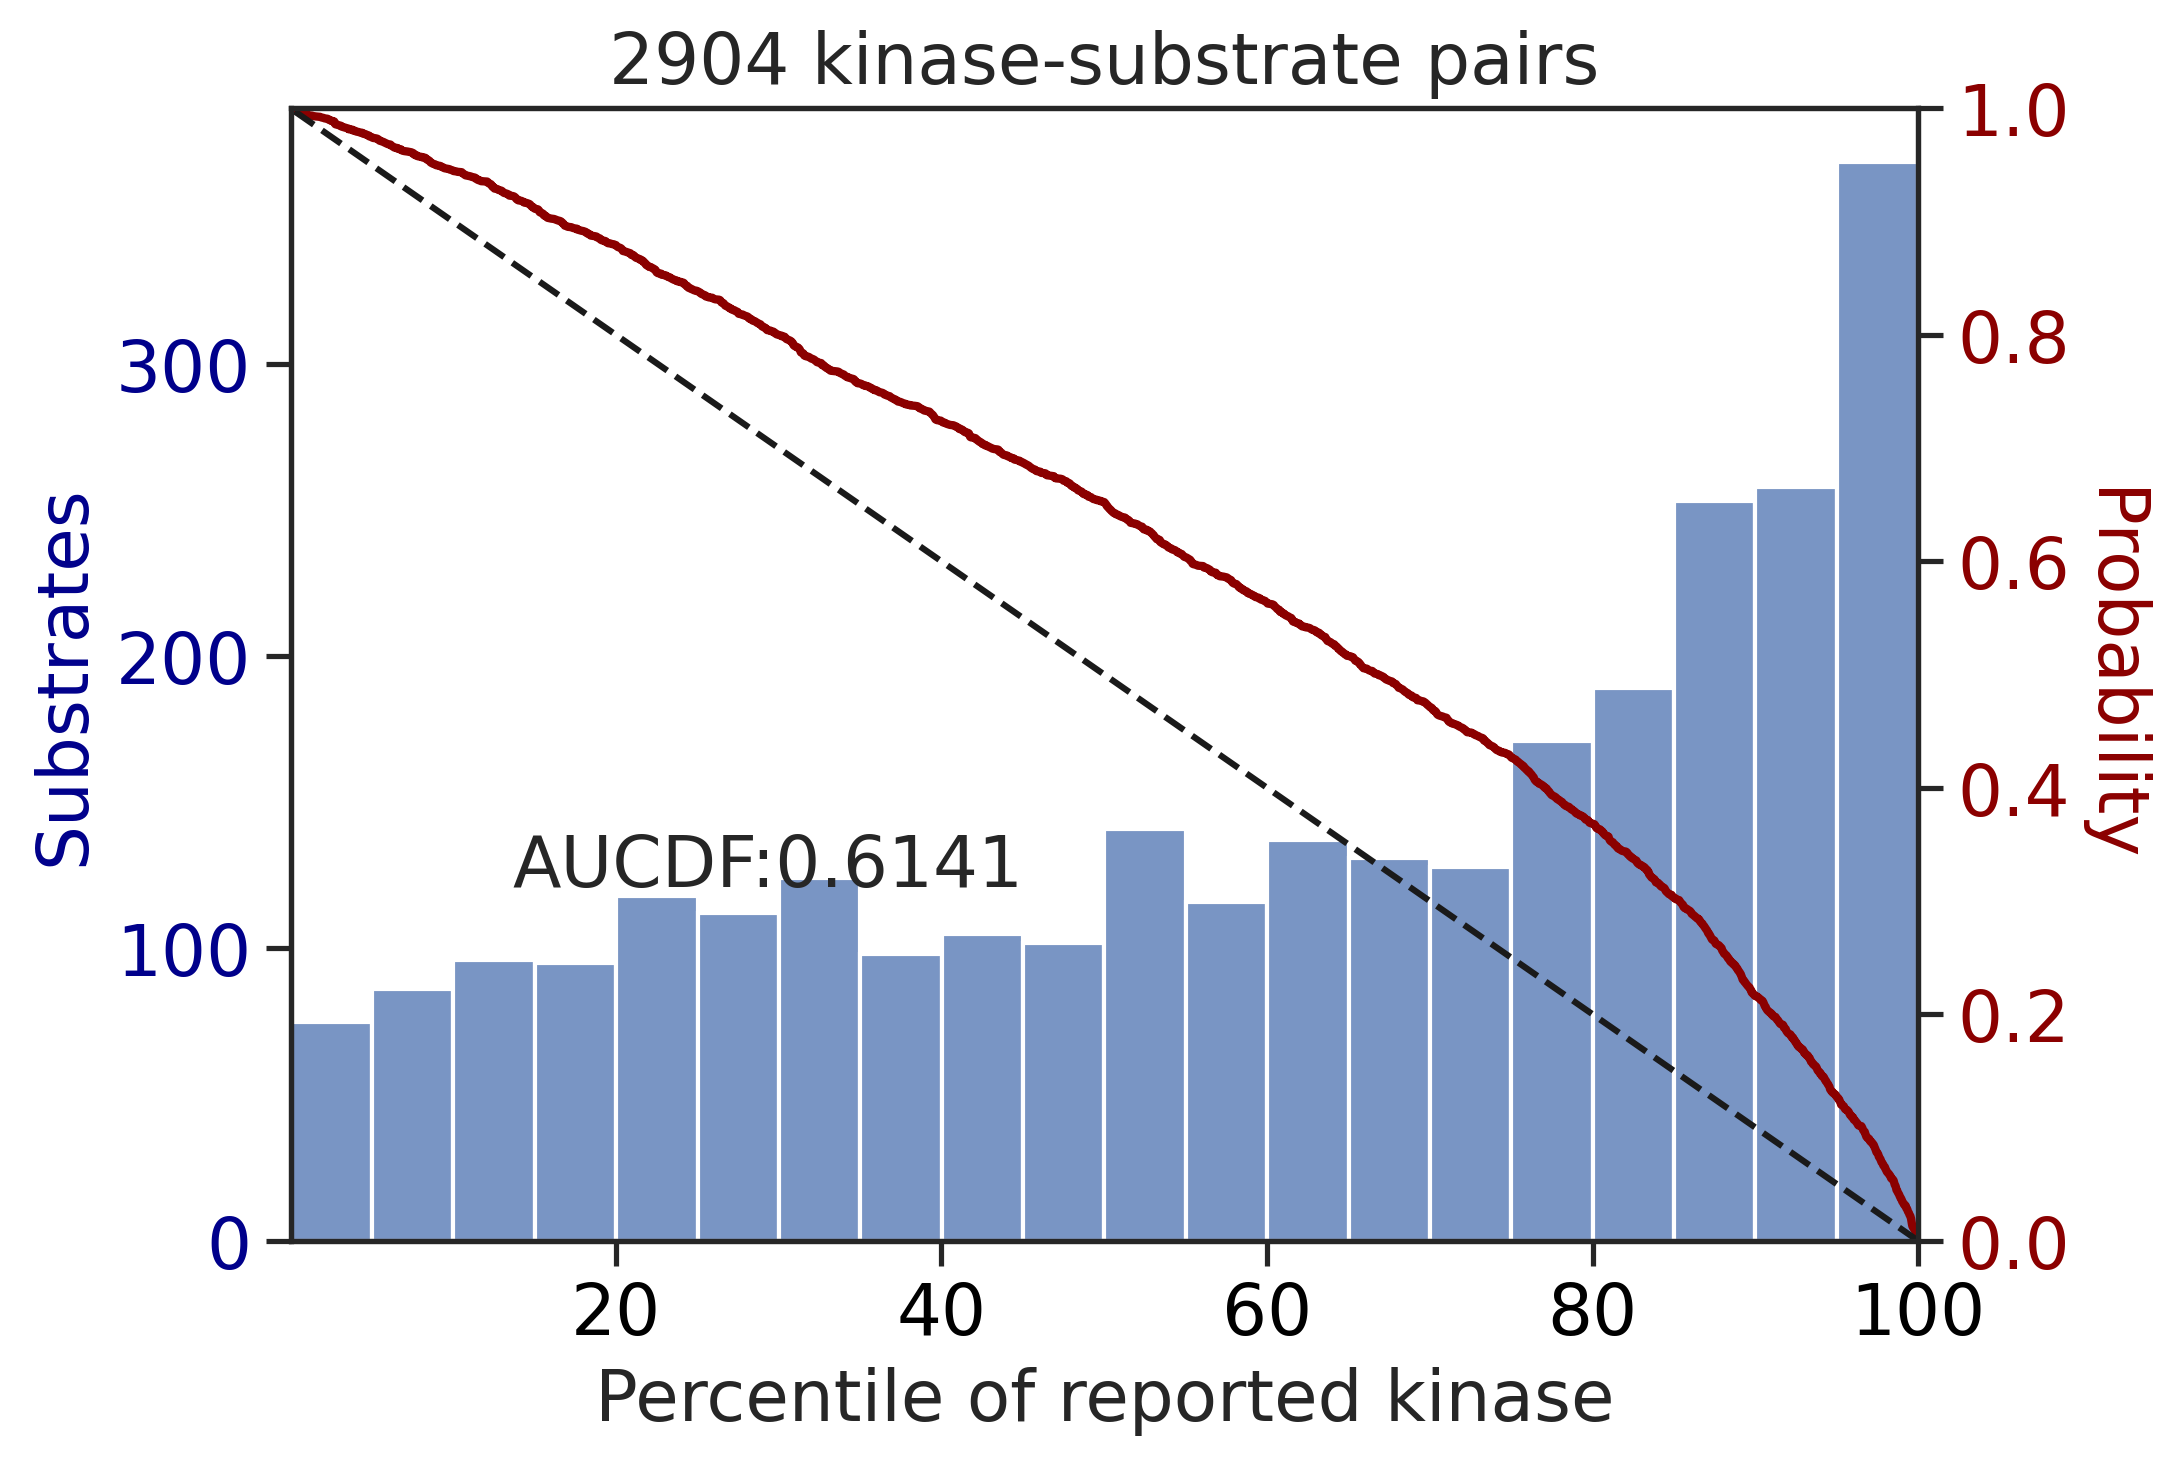

0.614120078571085

In [ ]:
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")

get_AUCDF(df_y,'pct',reverse=True,xlabel='Percentile of reported kinase')

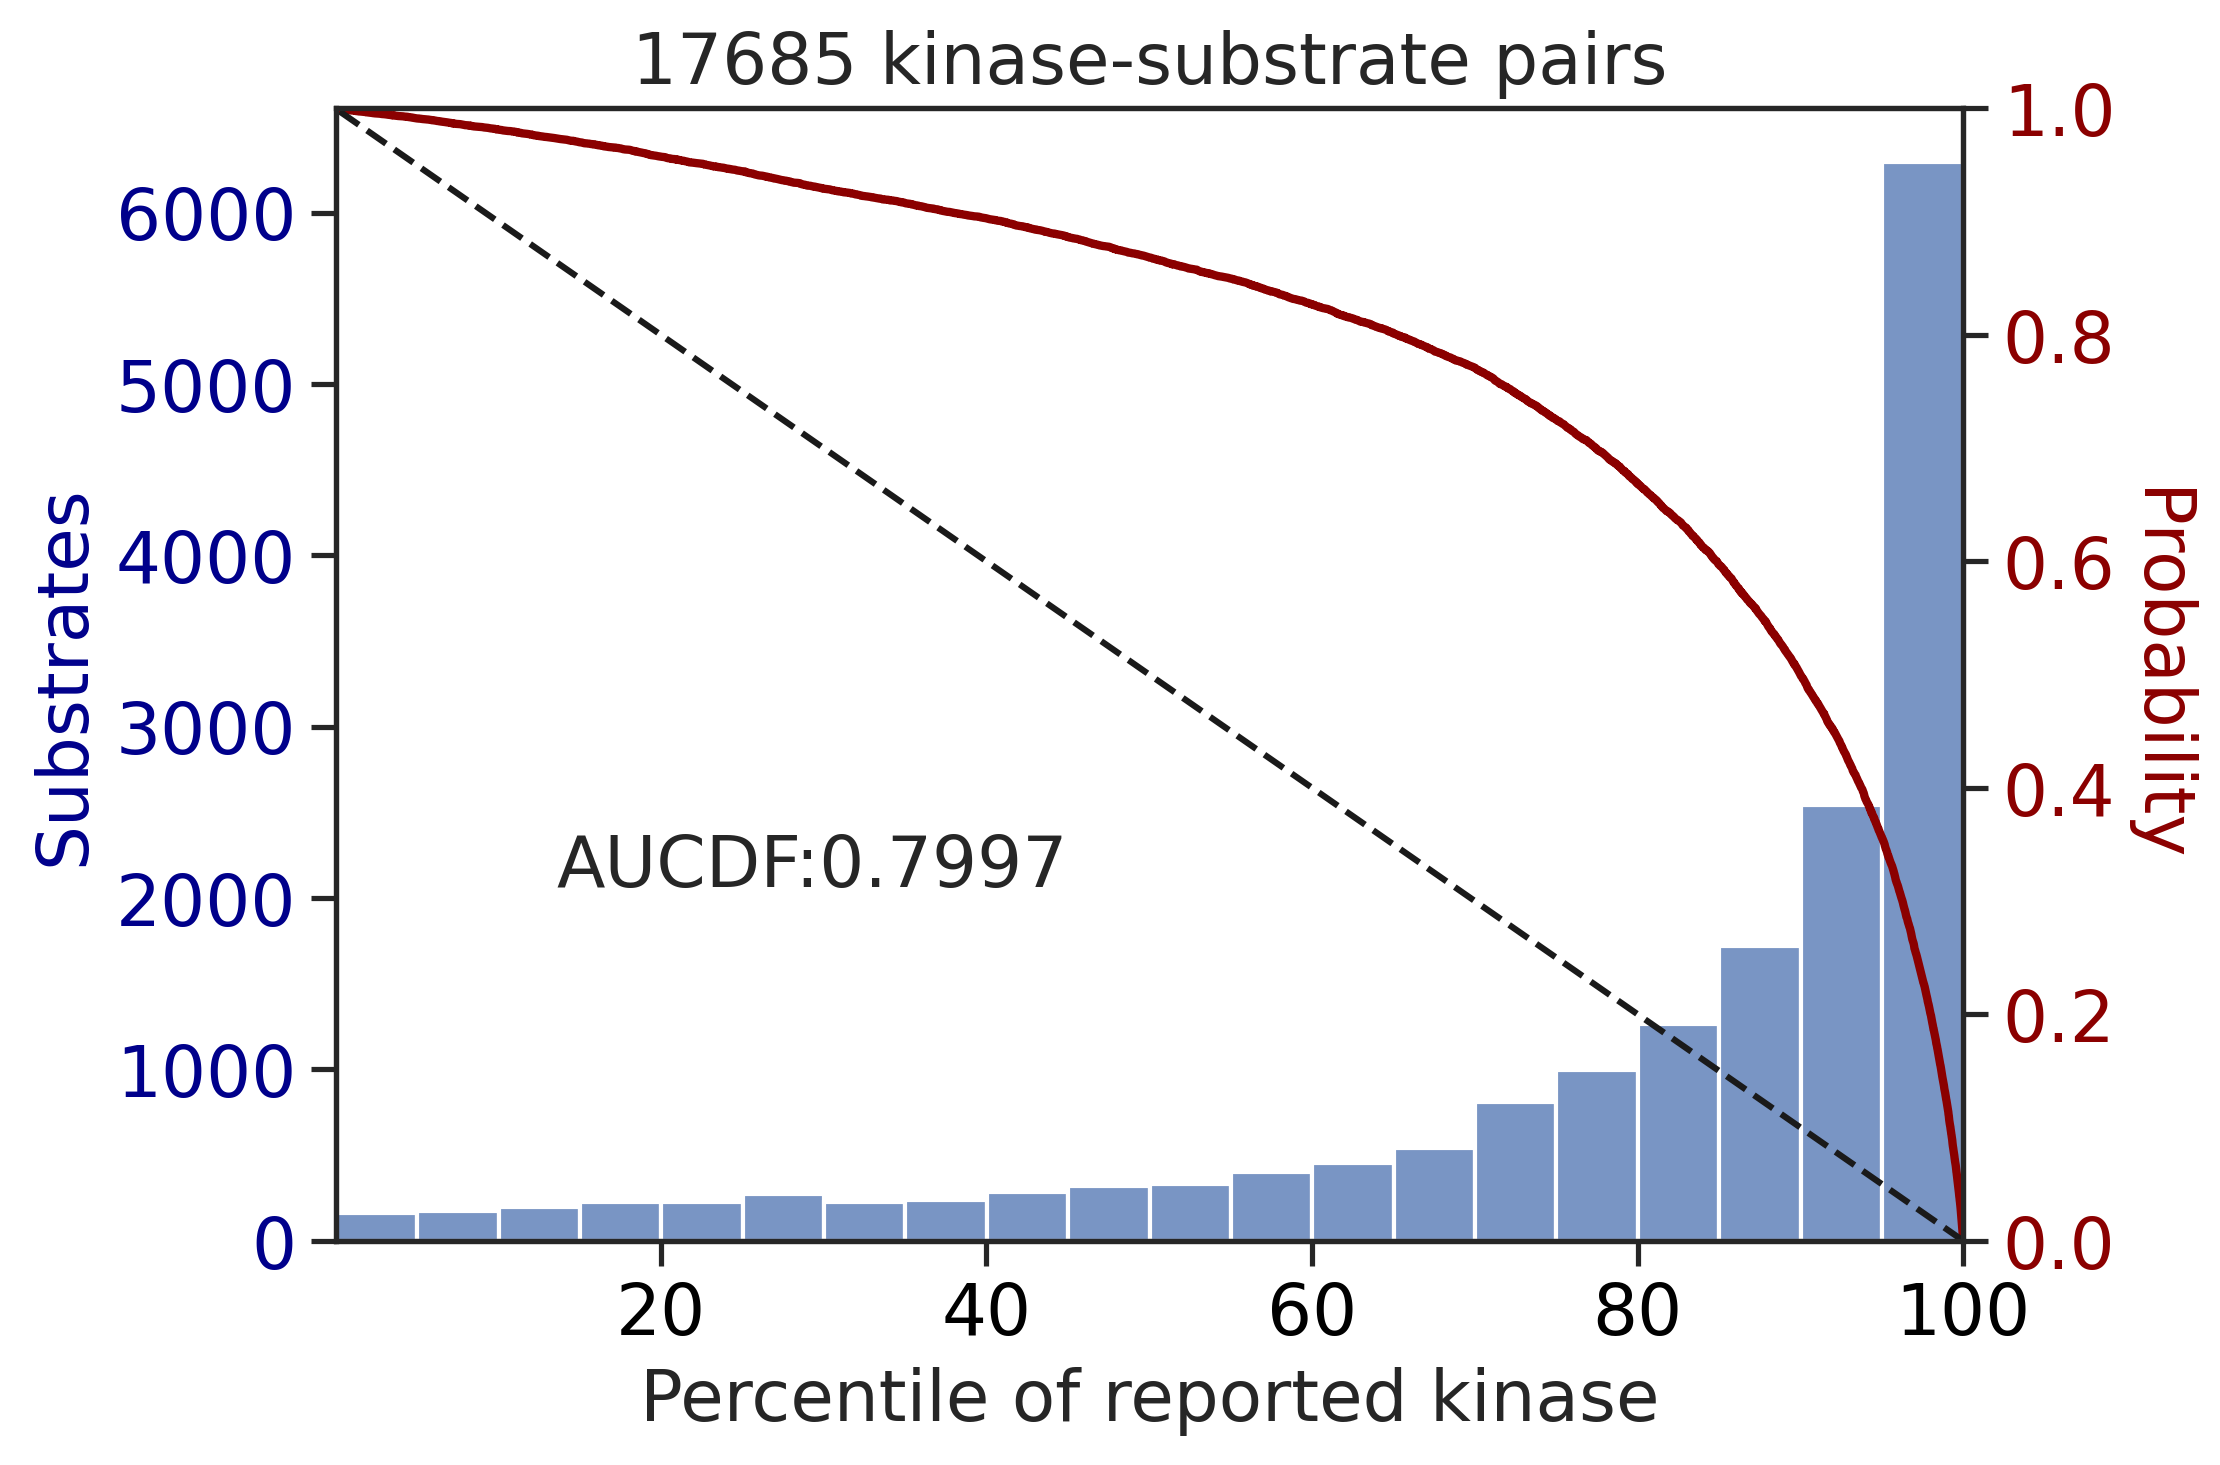

0.7996590313510994

In [ ]:
get_AUCDF(df_st,'pct',reverse=True,xlabel='Percentile of reported kinase')

## Percentile rank

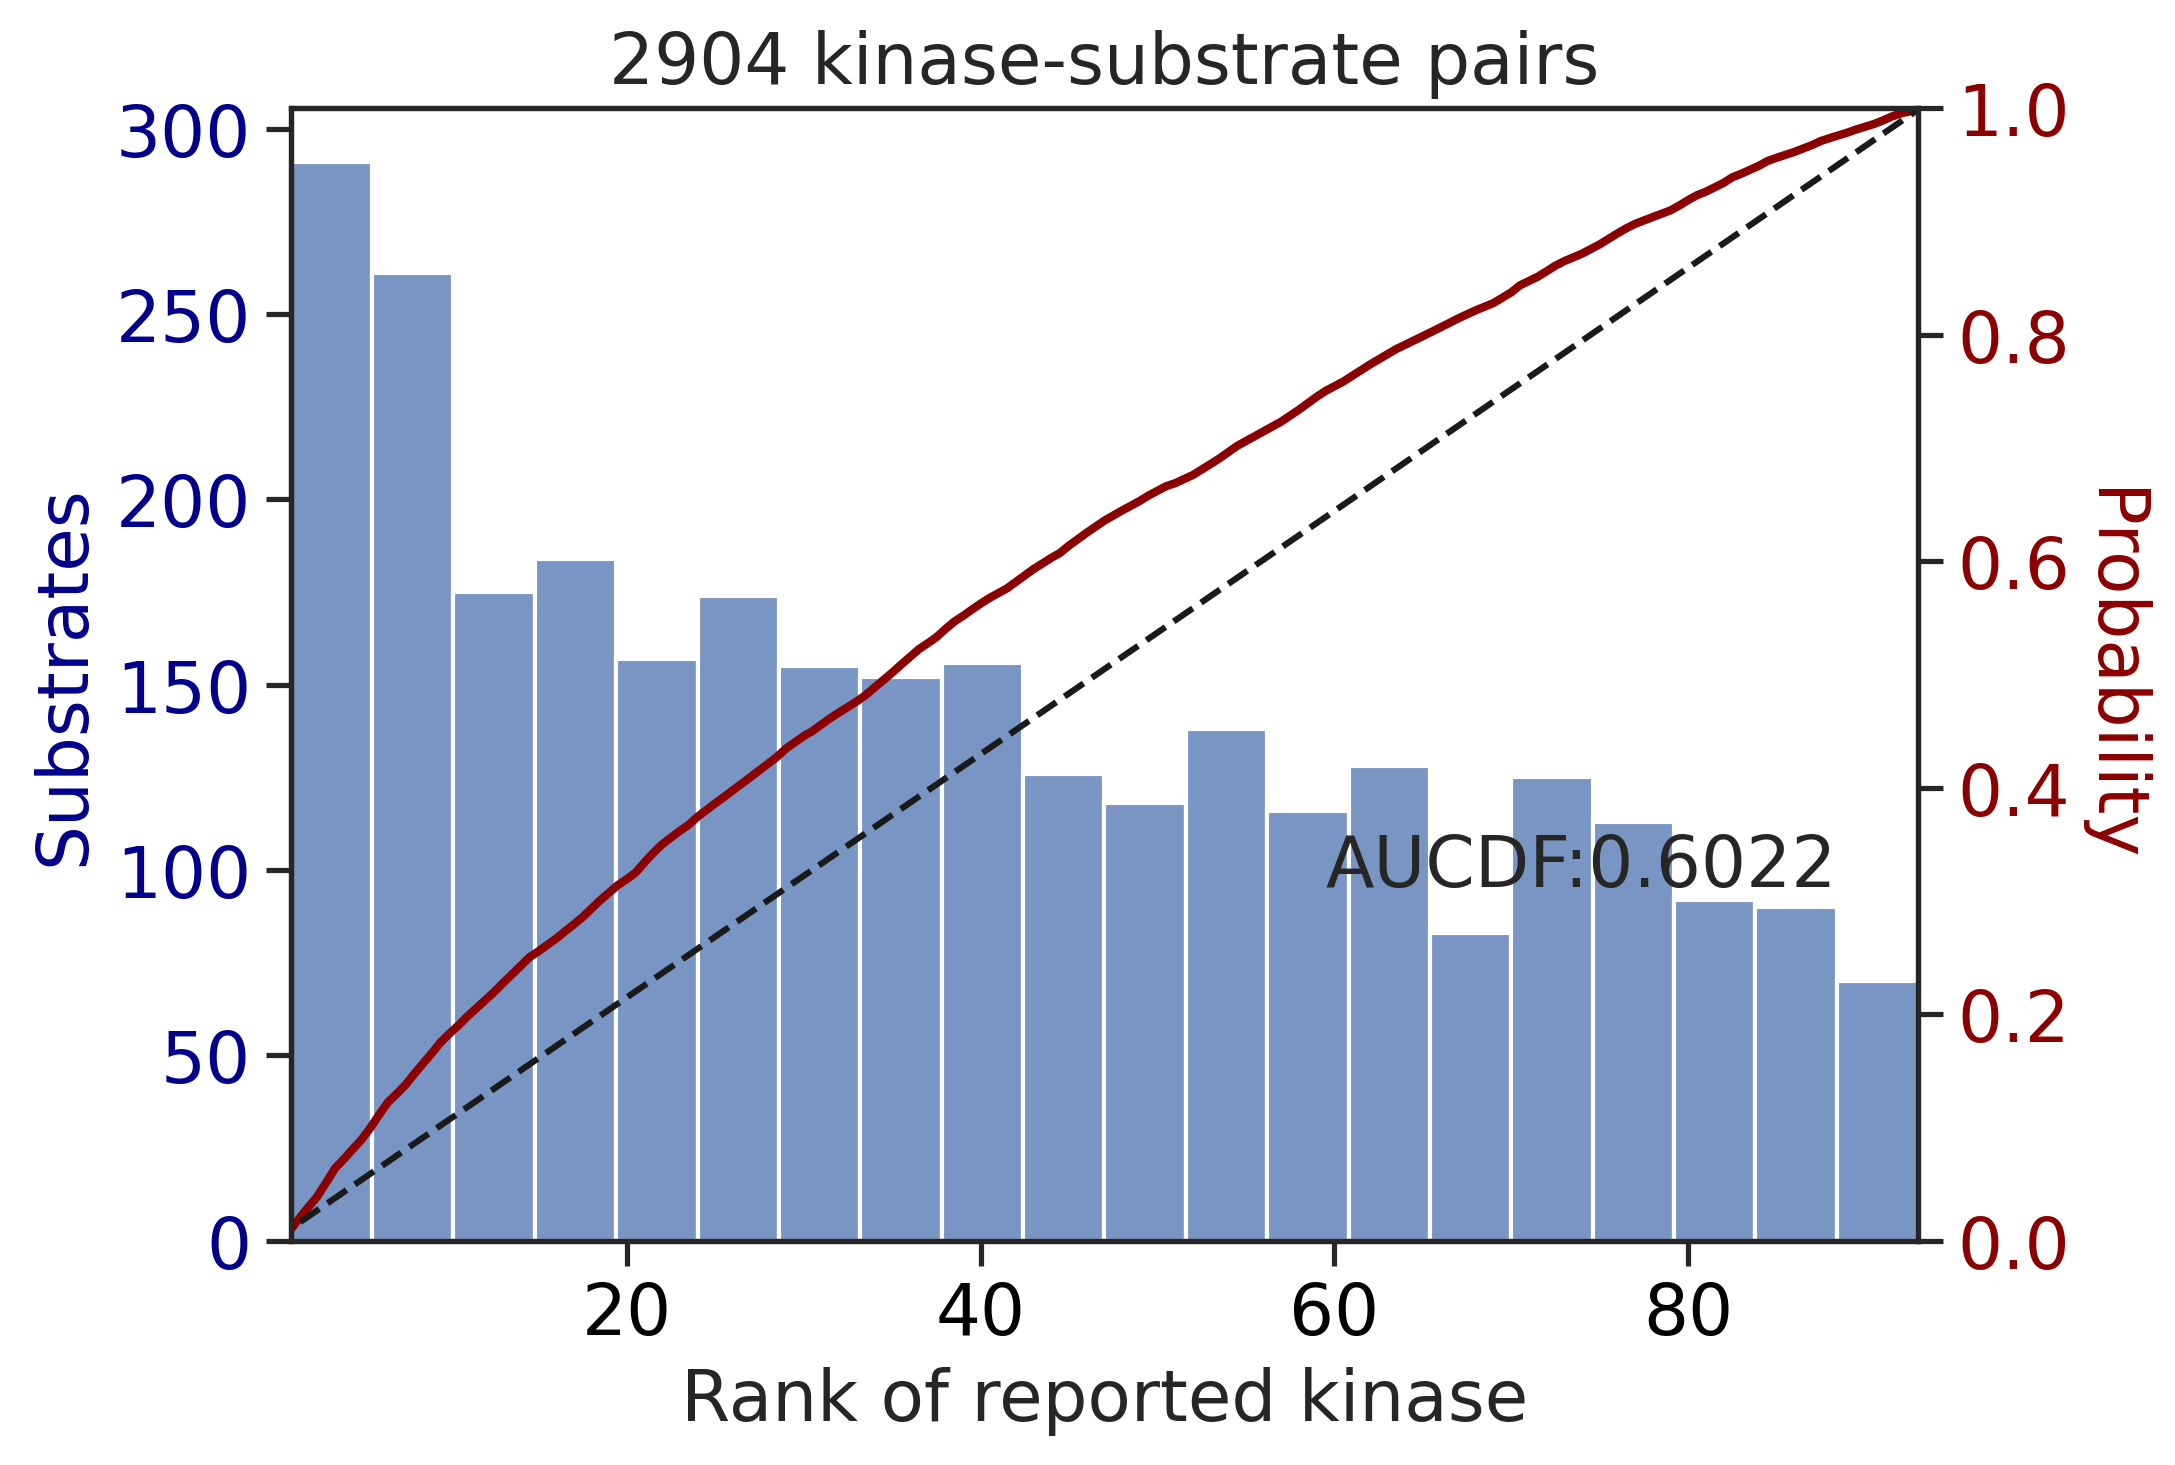

0.6022158282366477

In [ ]:
get_AUCDF(df_y,'pct_rnk')

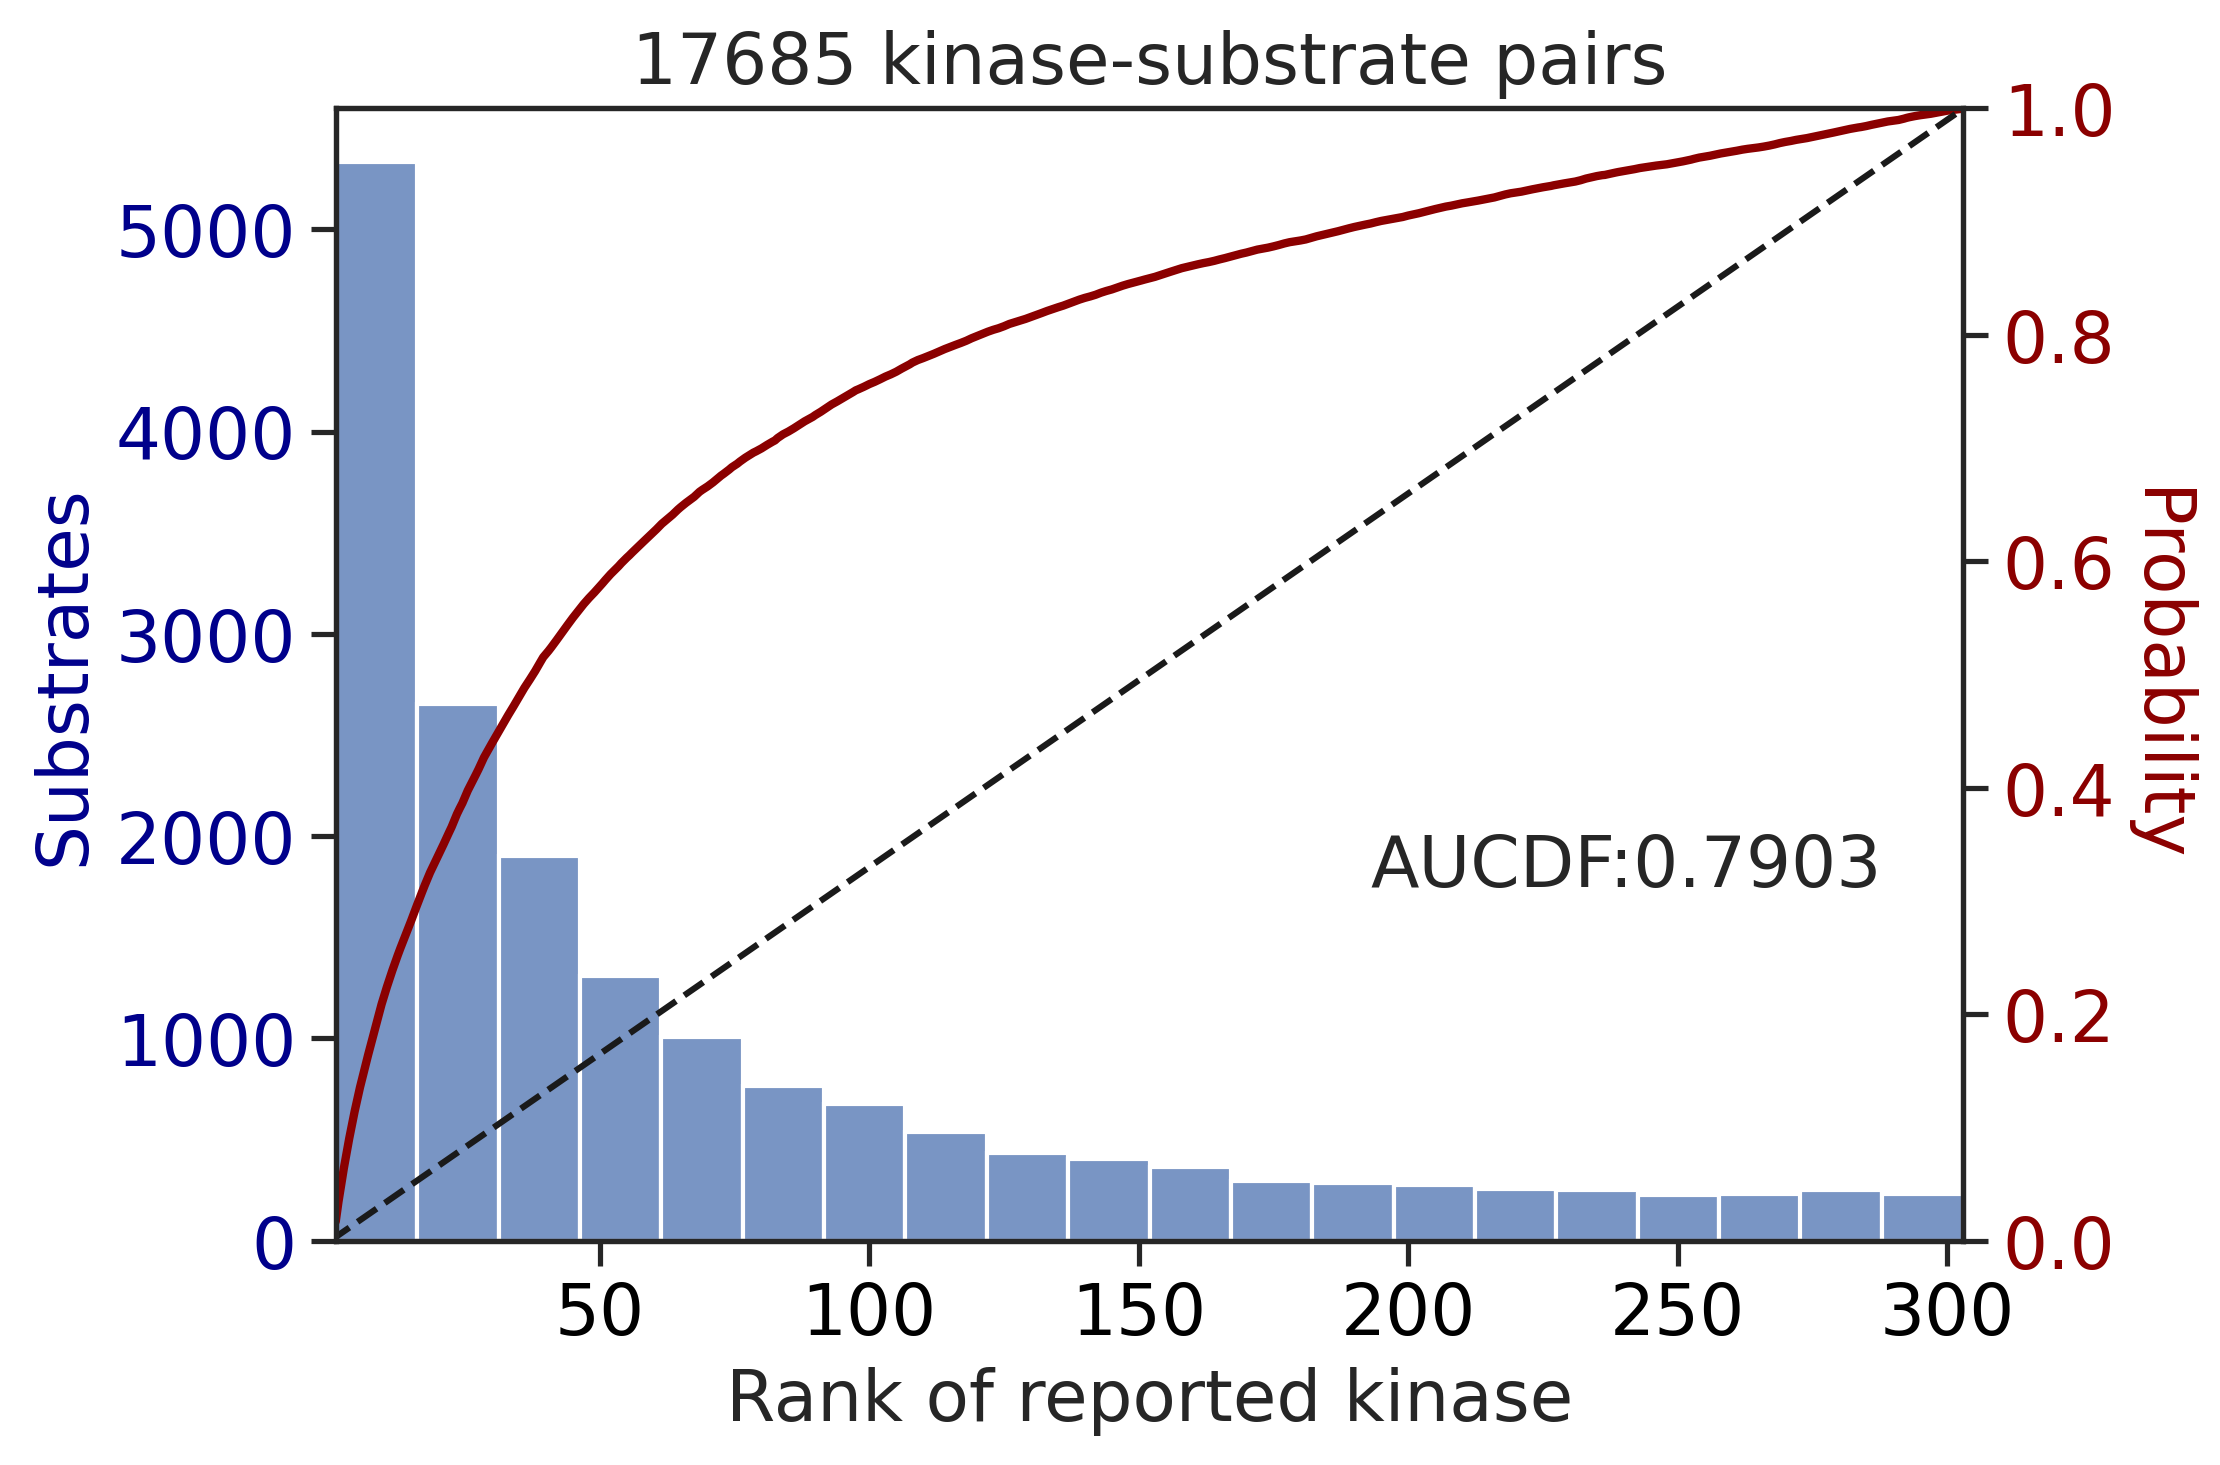

0.7903308428550032

In [ ]:
get_AUCDF(df_st,'pct_rnk')

## Multiply score on all capital

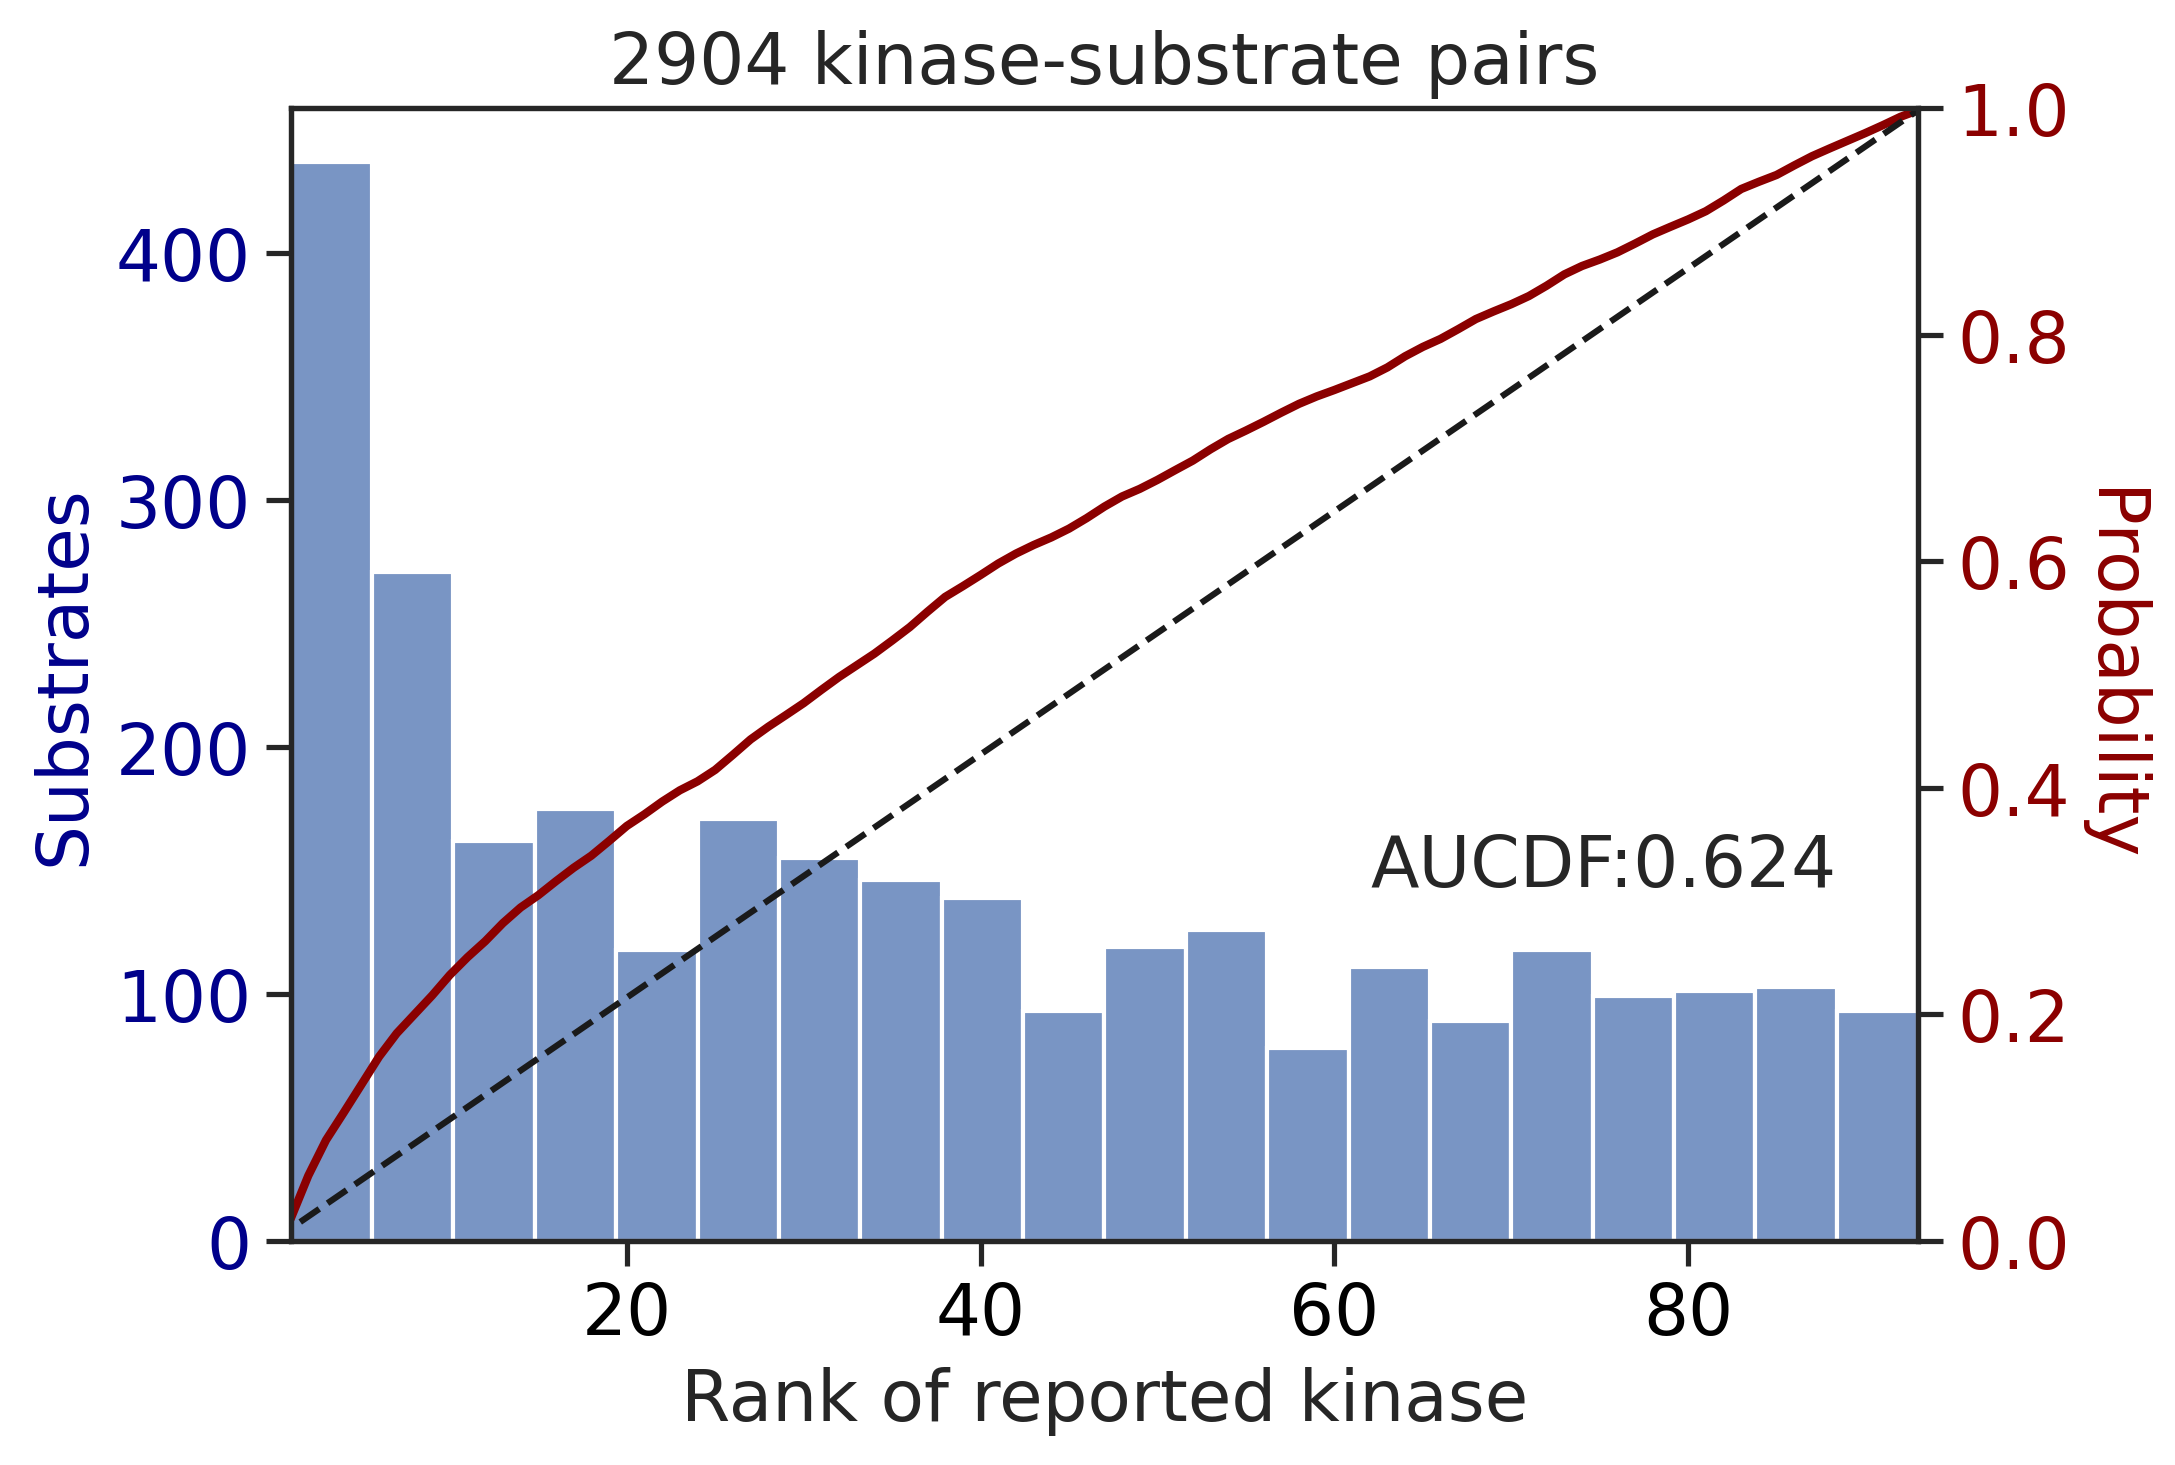

0.6240460933796205

In [ ]:
get_AUCDF(df_y,'y_rnk_mul_up')

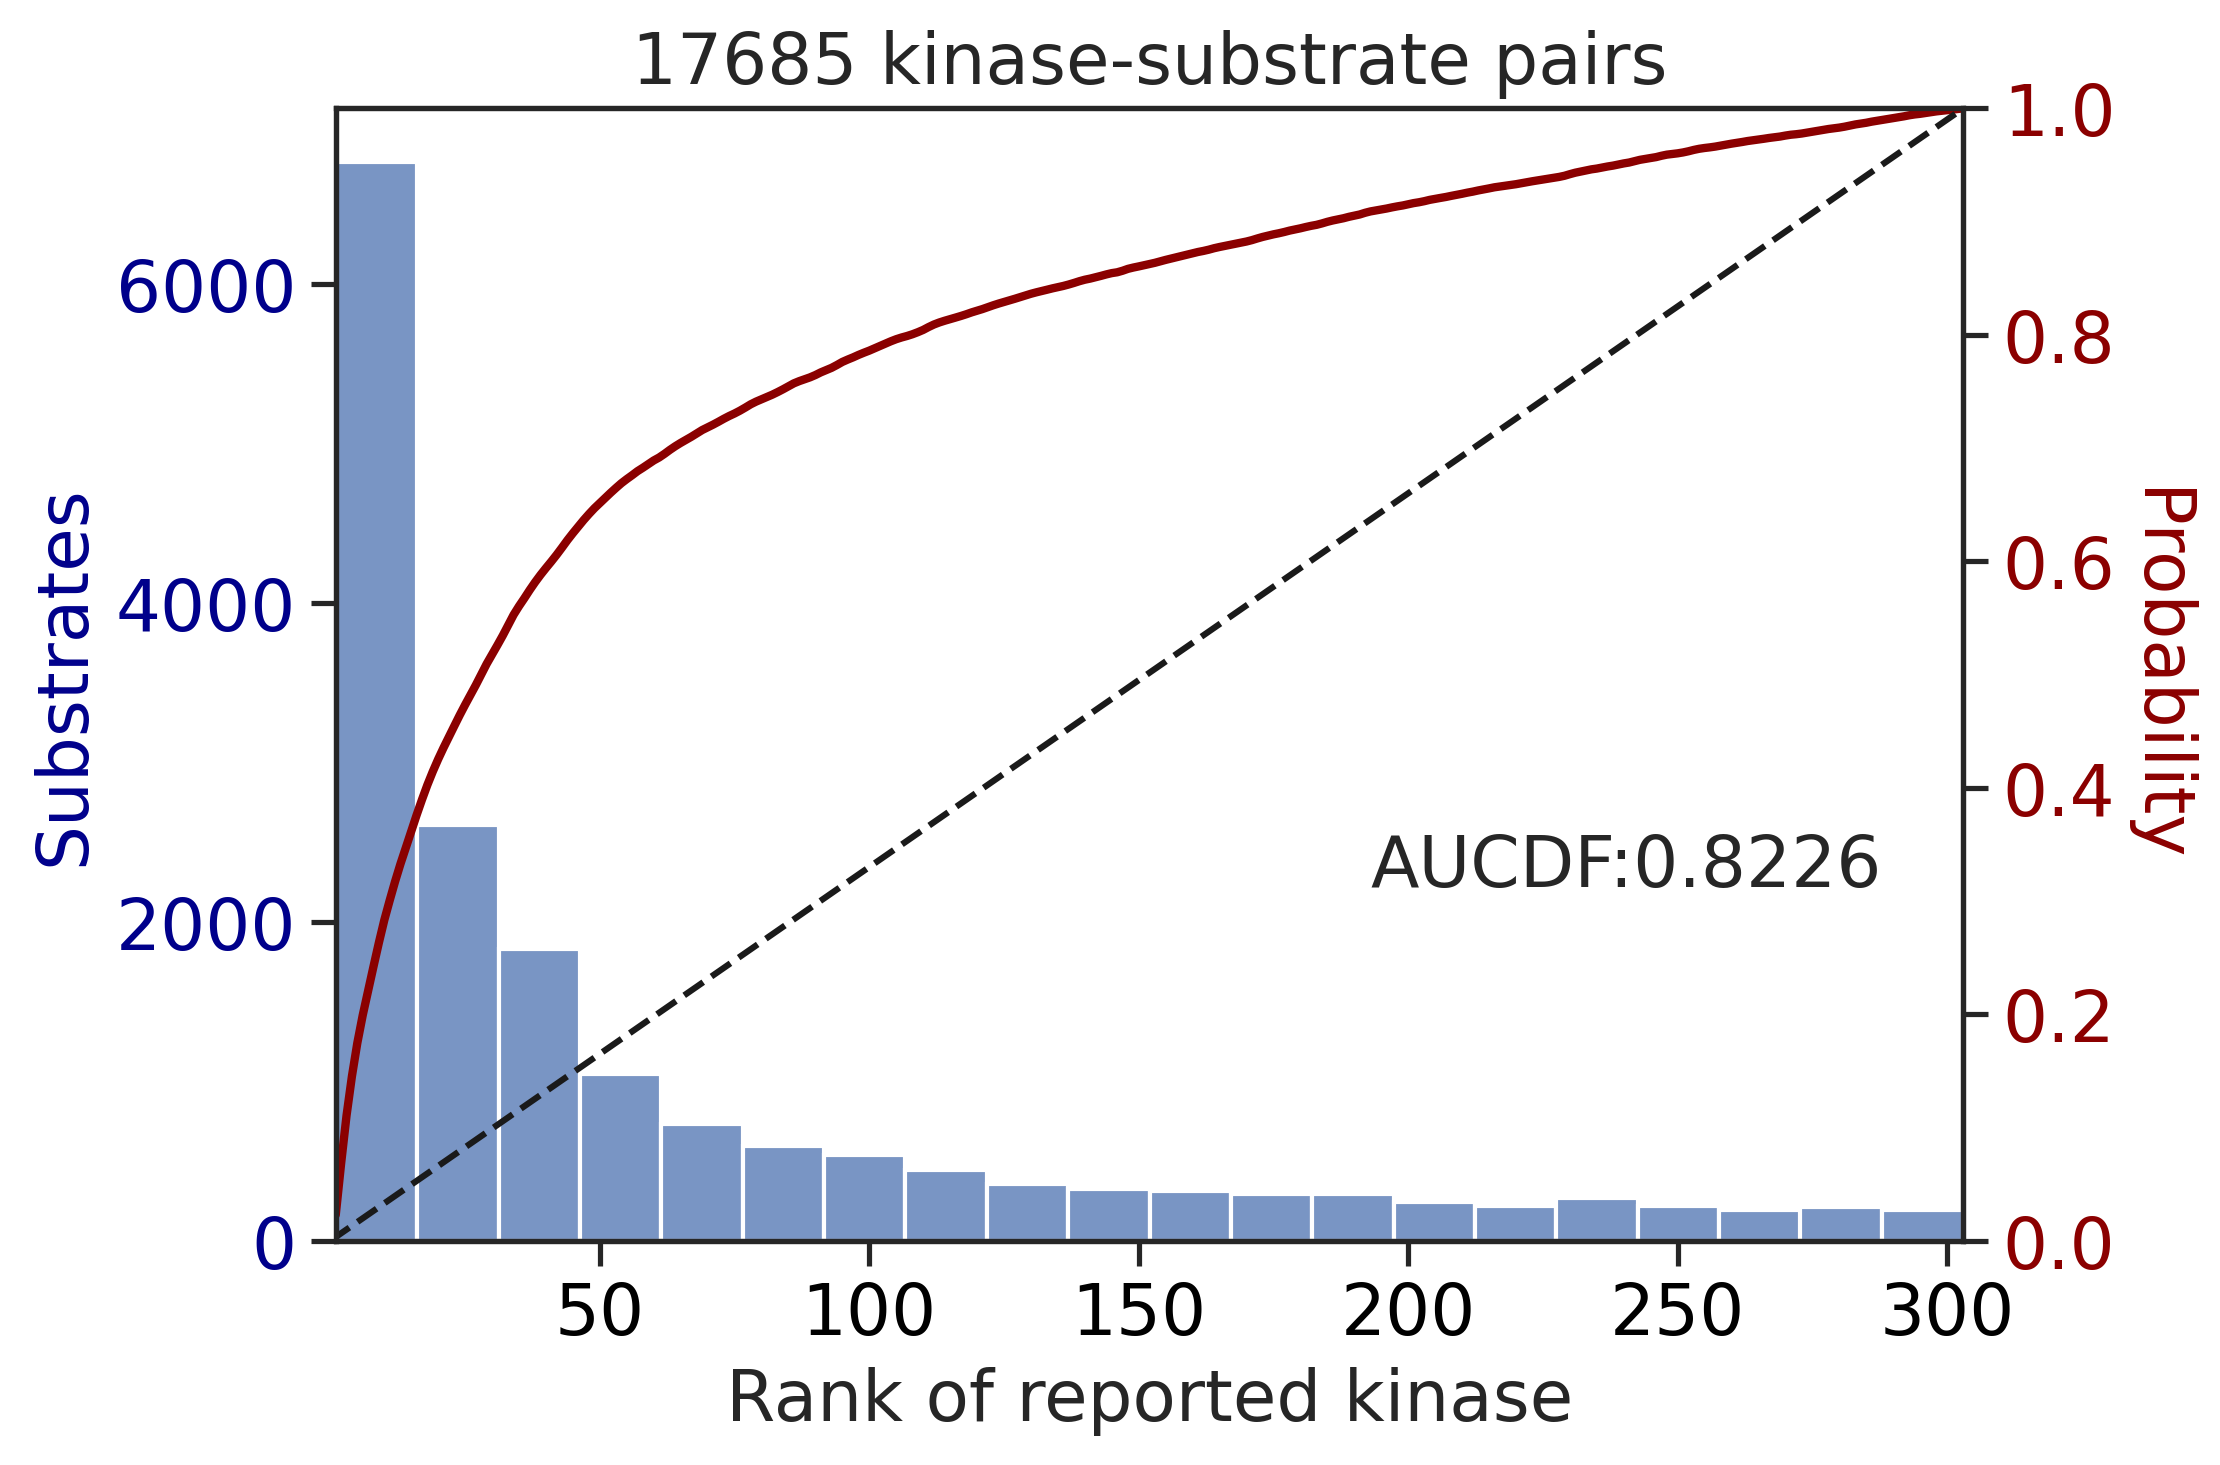

0.8225713446901245

In [ ]:
get_AUCDF(df_st,'st_rnk_mul_up')

## Multiply score on phosphorylated

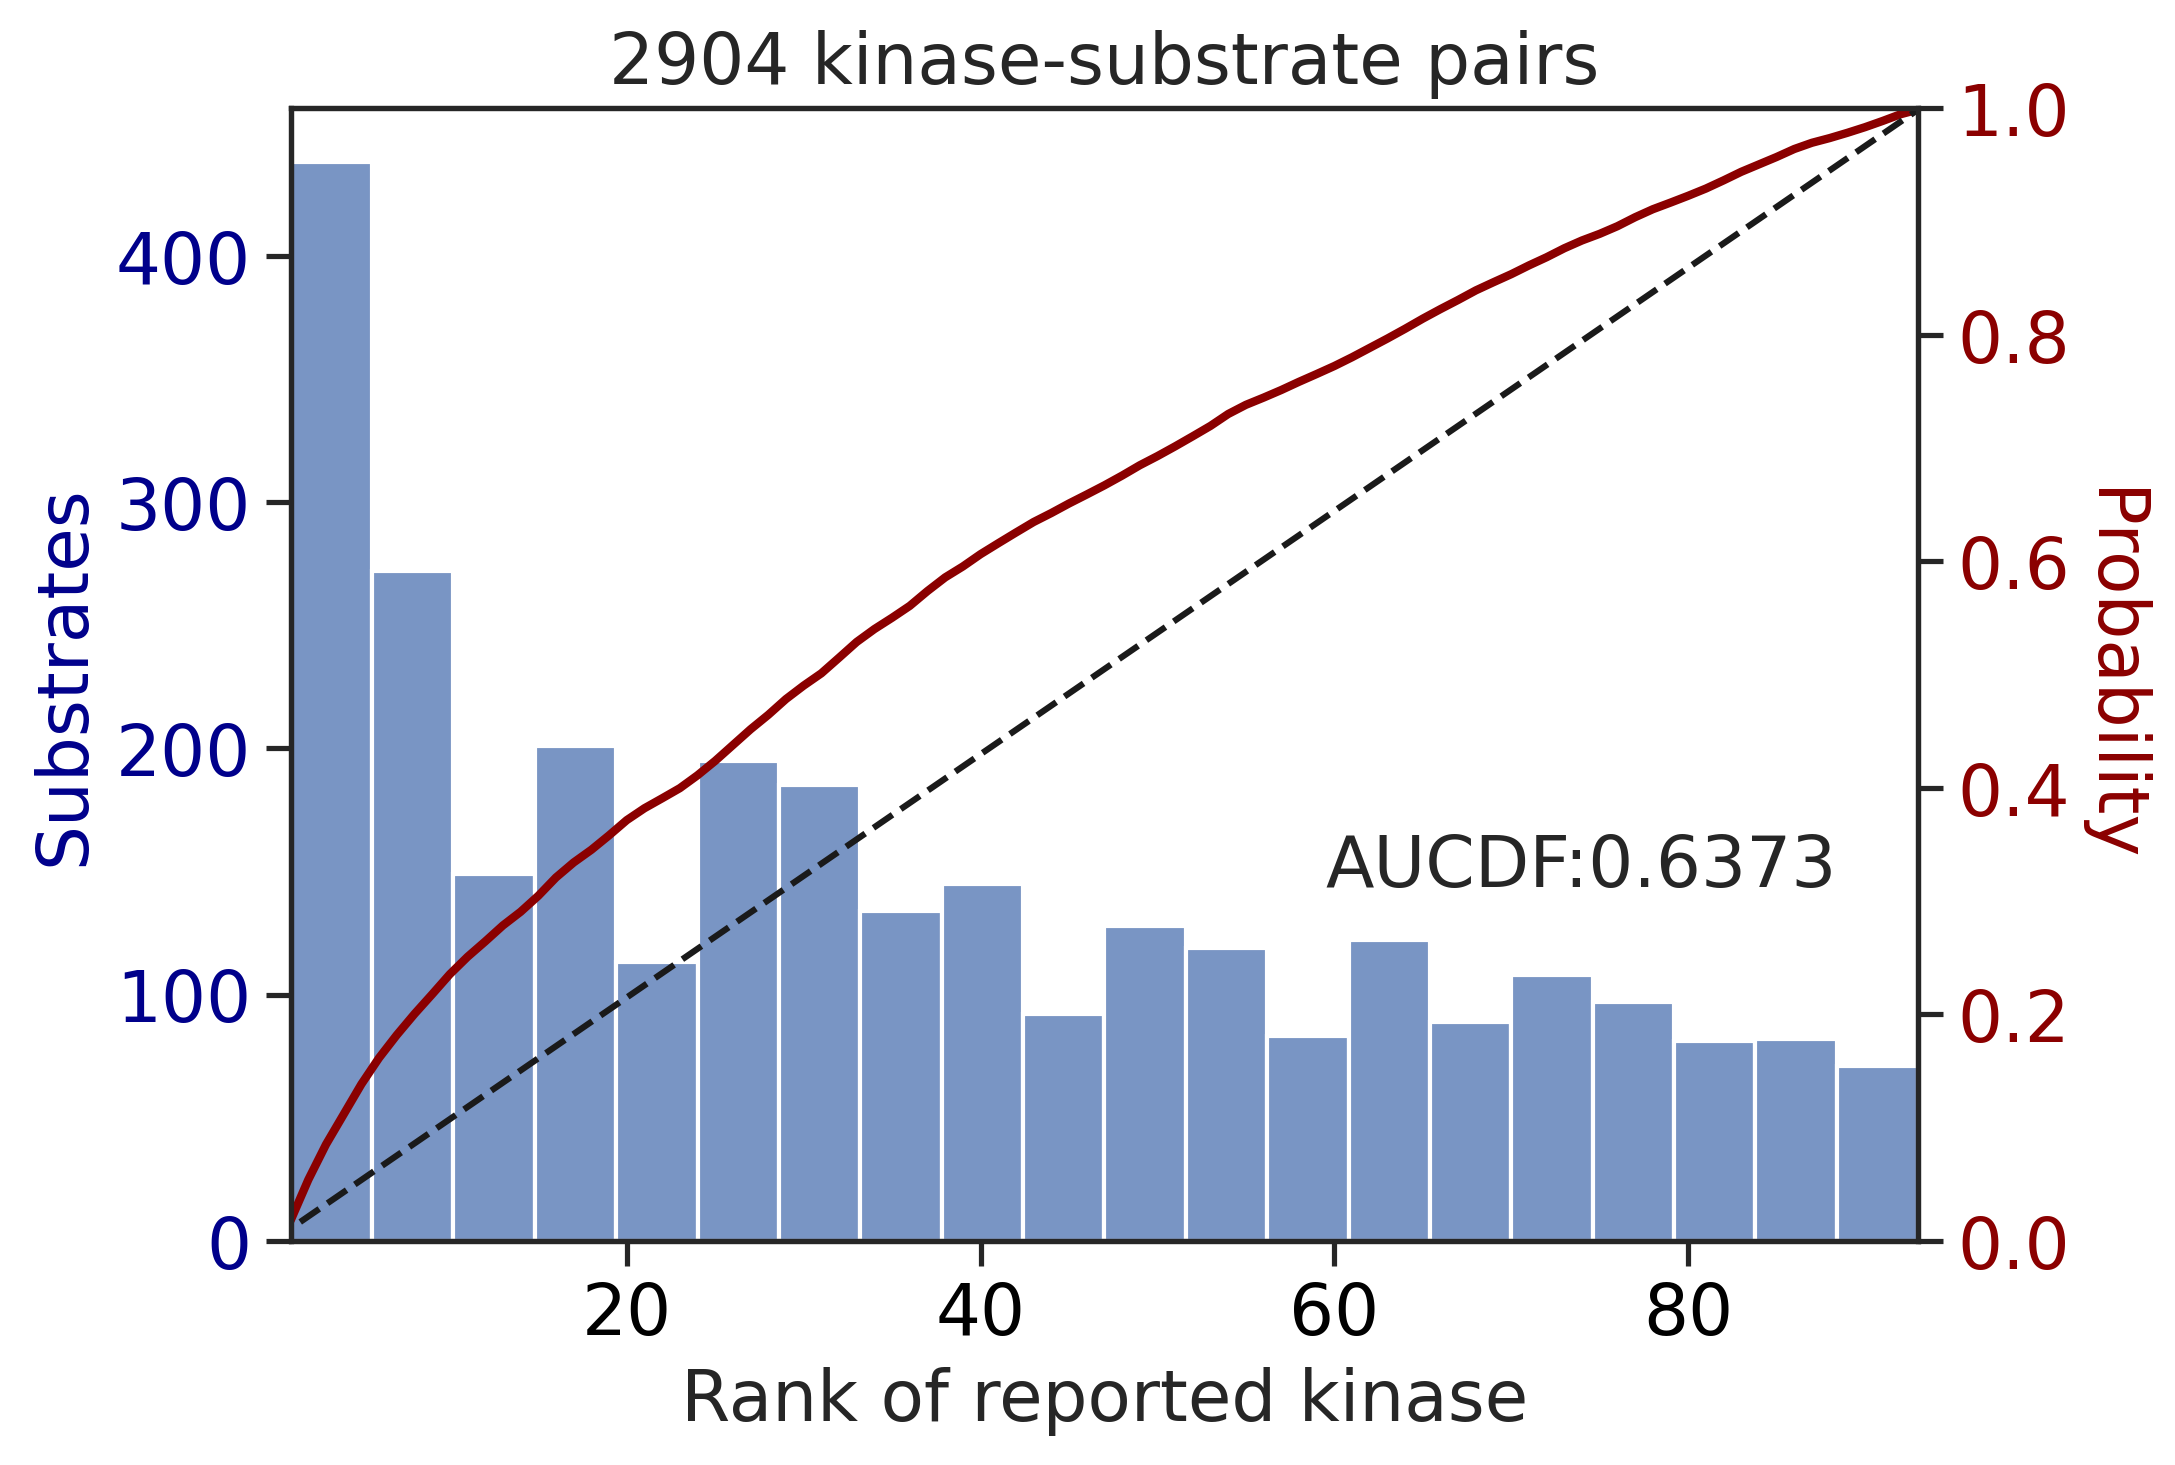

0.6373005243034091

In [ ]:
get_AUCDF(df_y,'y_rnk_mul_lo')

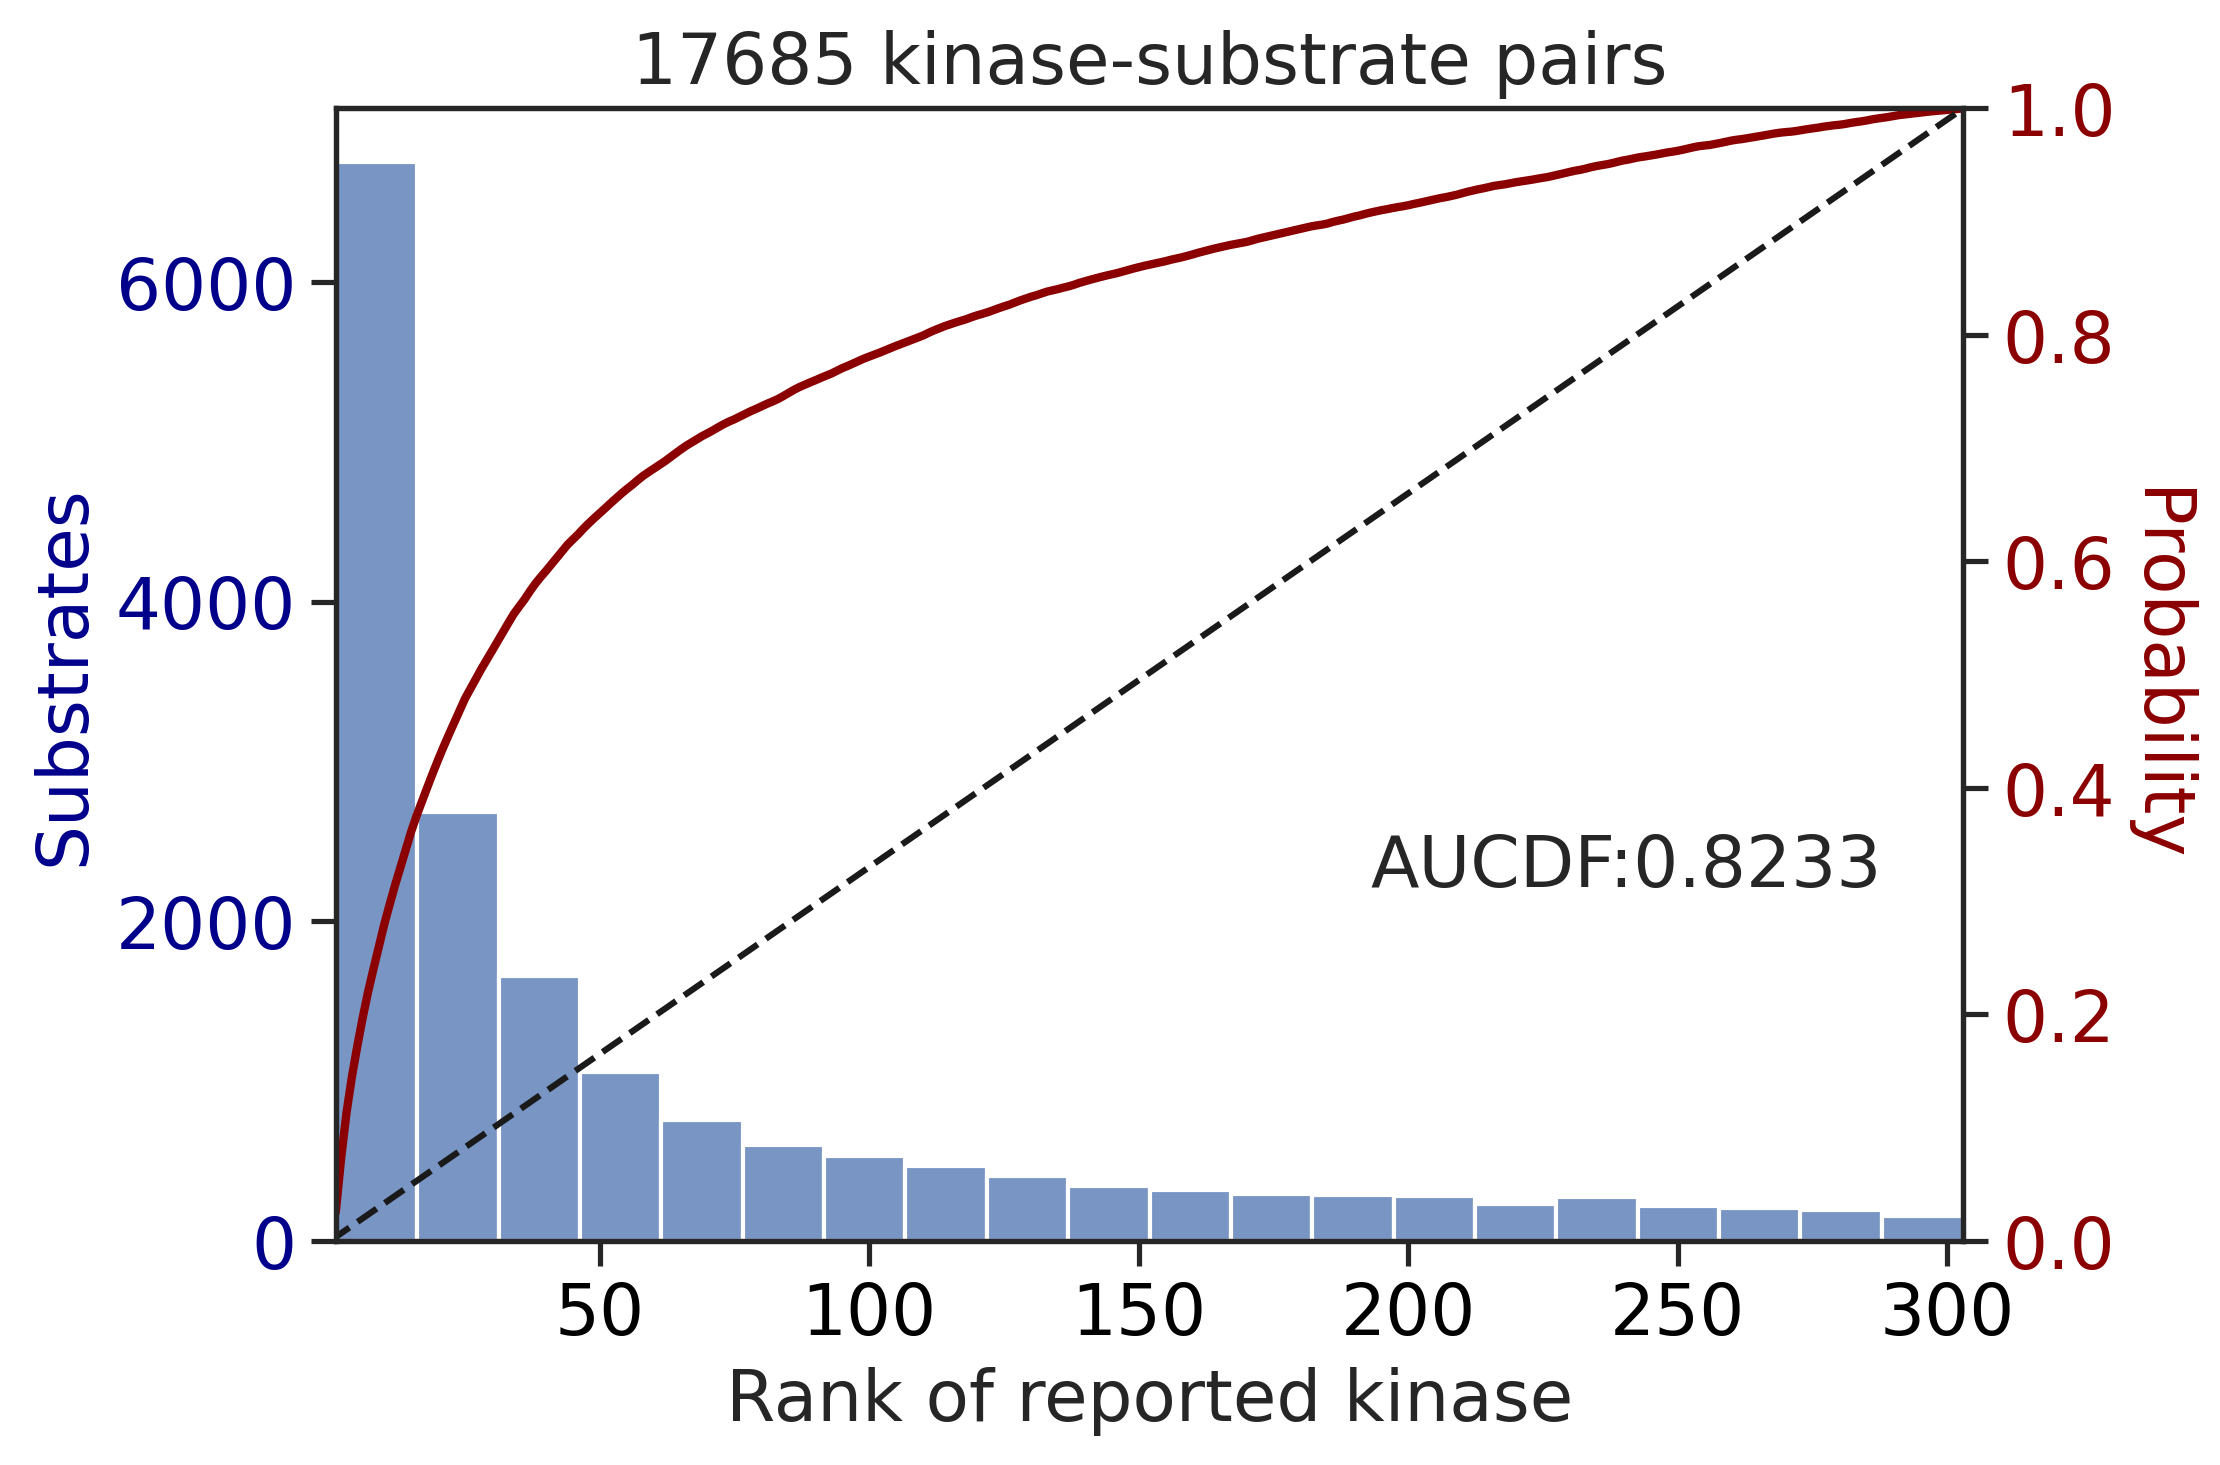

0.823287473616352

In [ ]:
get_AUCDF(df_st,'st_rnk_mul_lo')

## Sum score on all capital

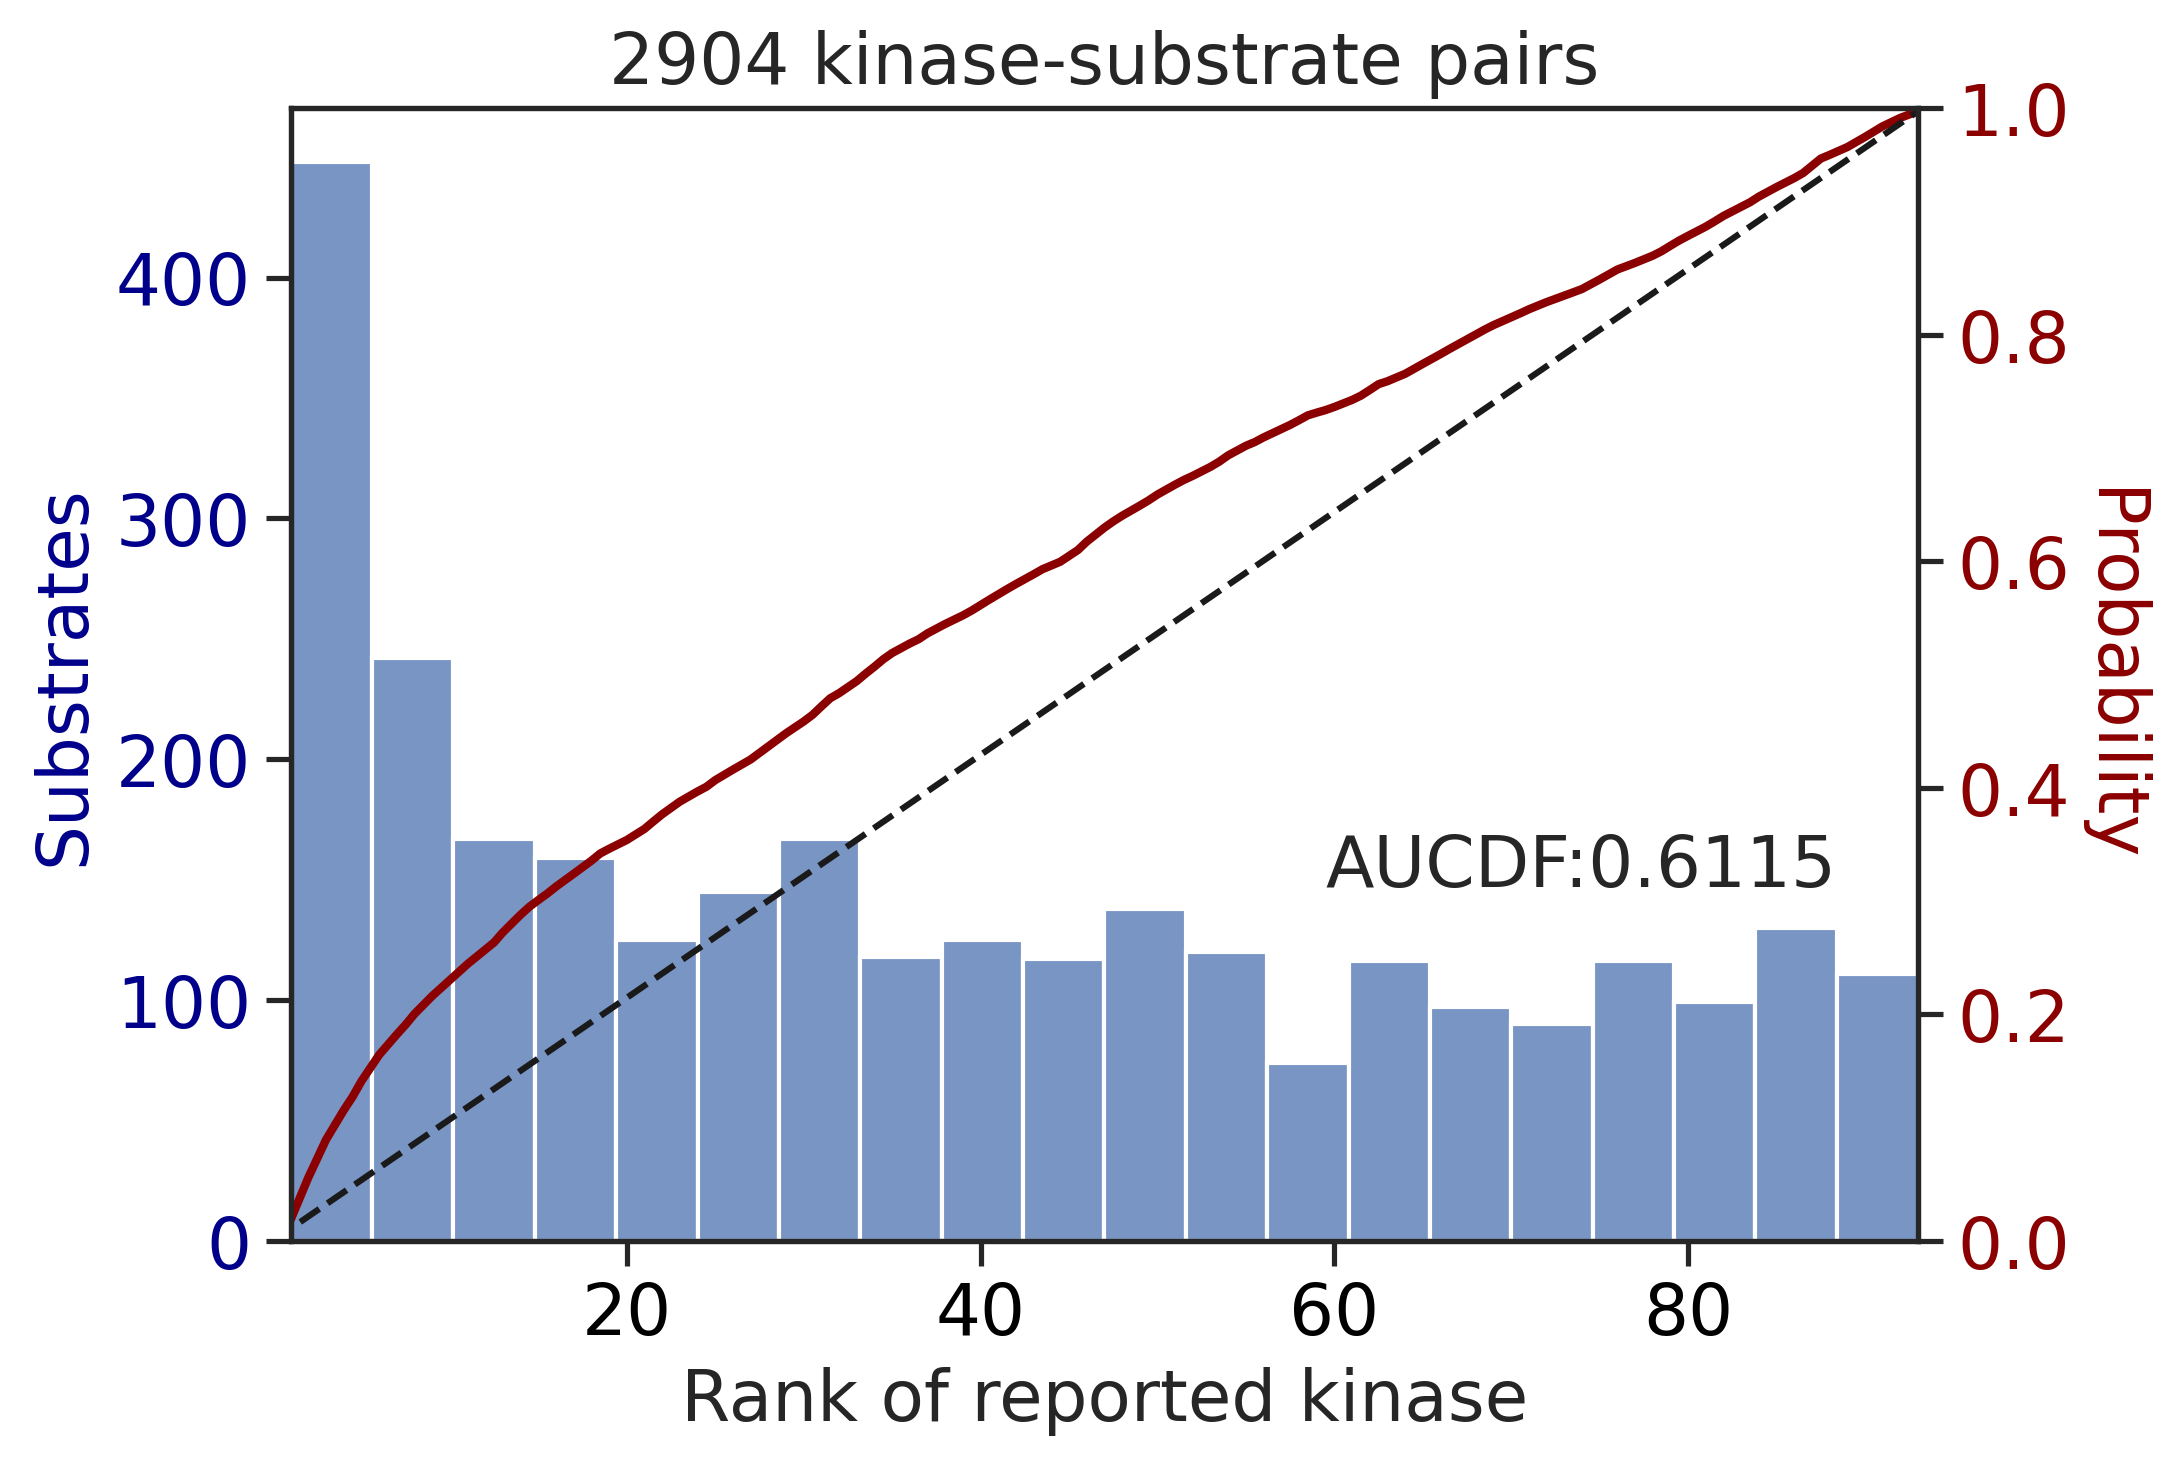

0.6114770833014728

In [ ]:
get_AUCDF(df_y,'y_rnk_sum_up')

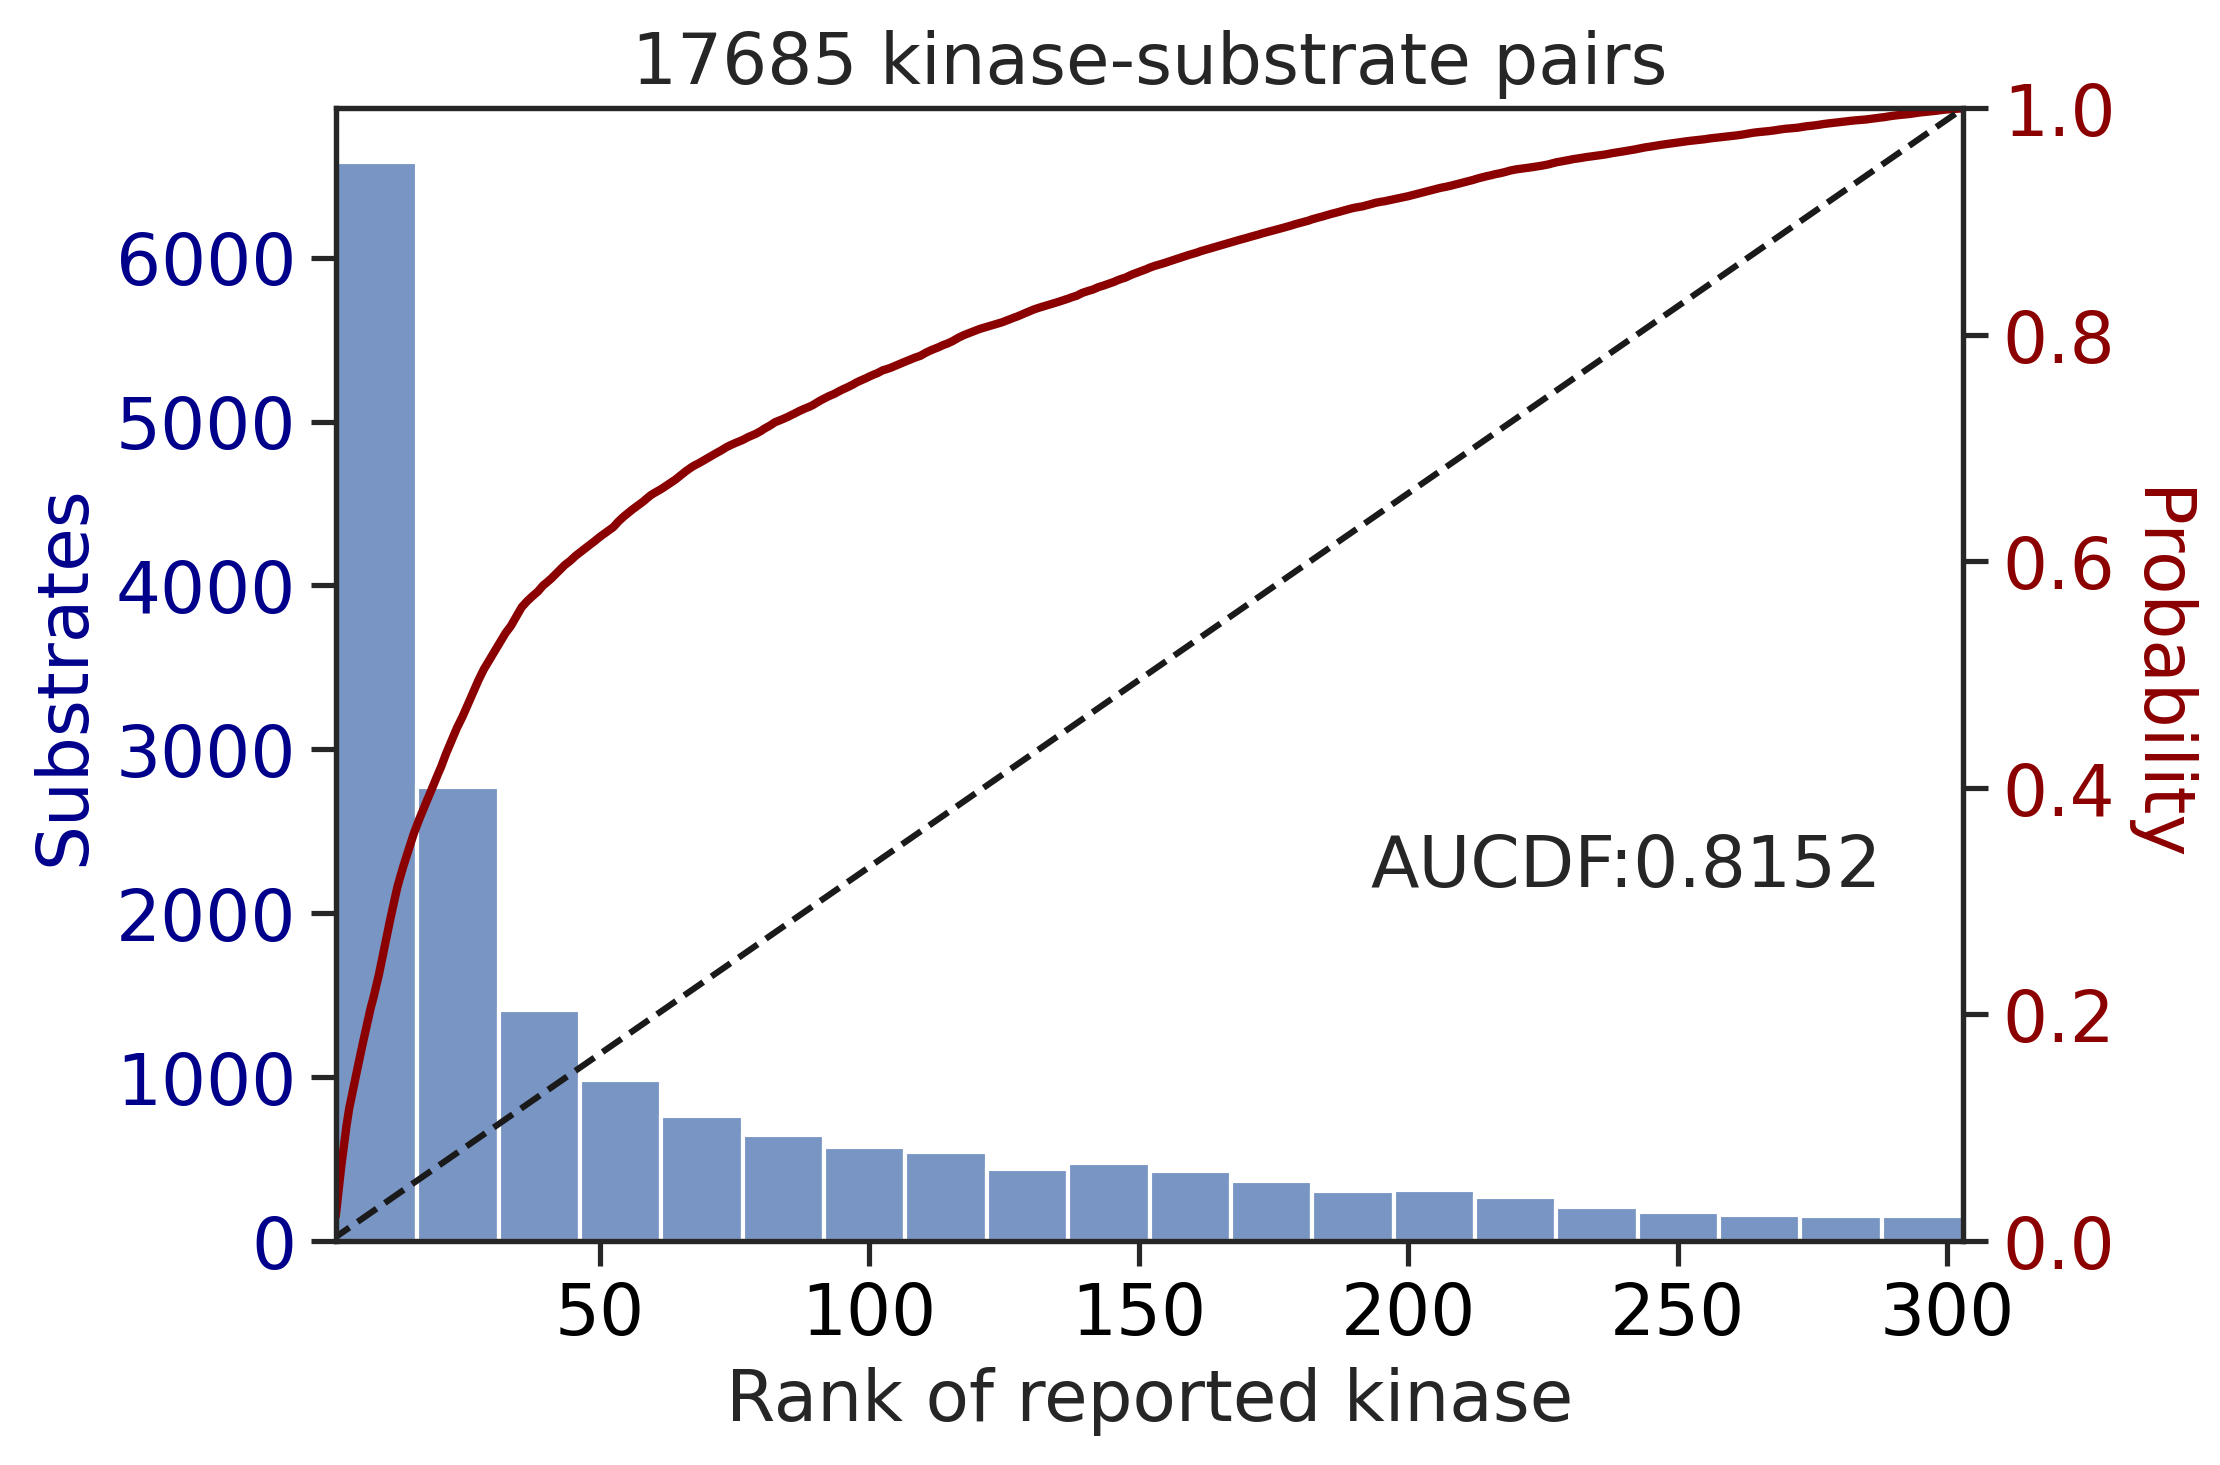

0.8151744953213705

In [ ]:
get_AUCDF(df_st,'st_rnk_sum_up')

## Sum score on phosphorylated

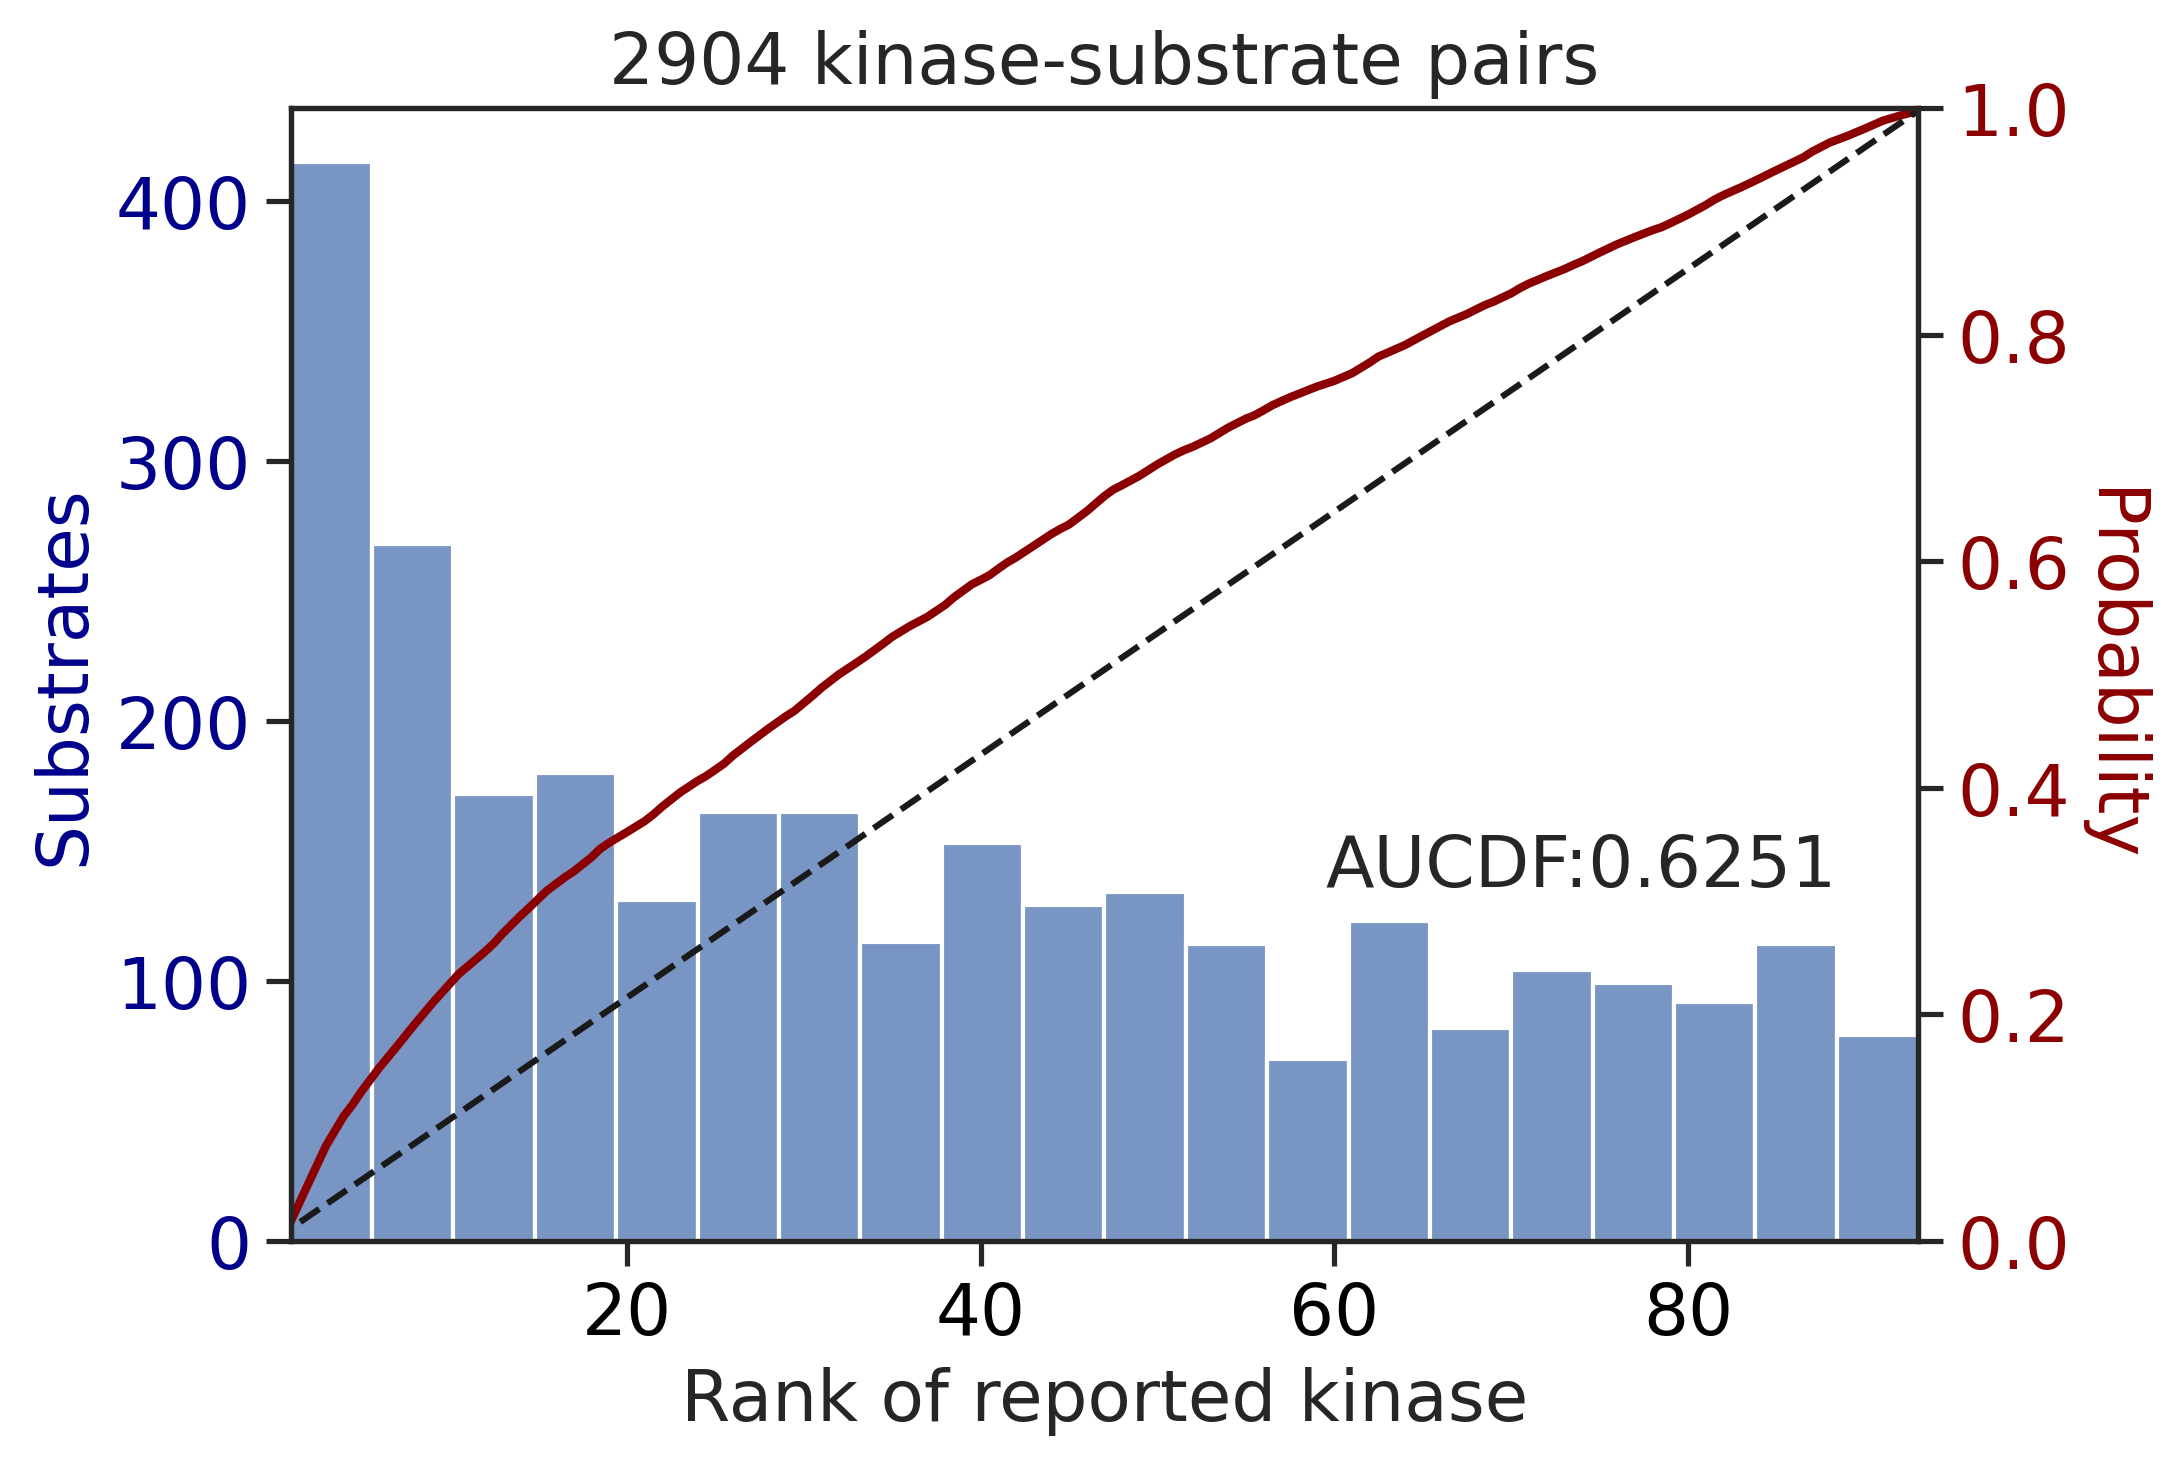

0.6251077799990844

In [ ]:
get_AUCDF(df_y,'y_rnk_sum_lo')

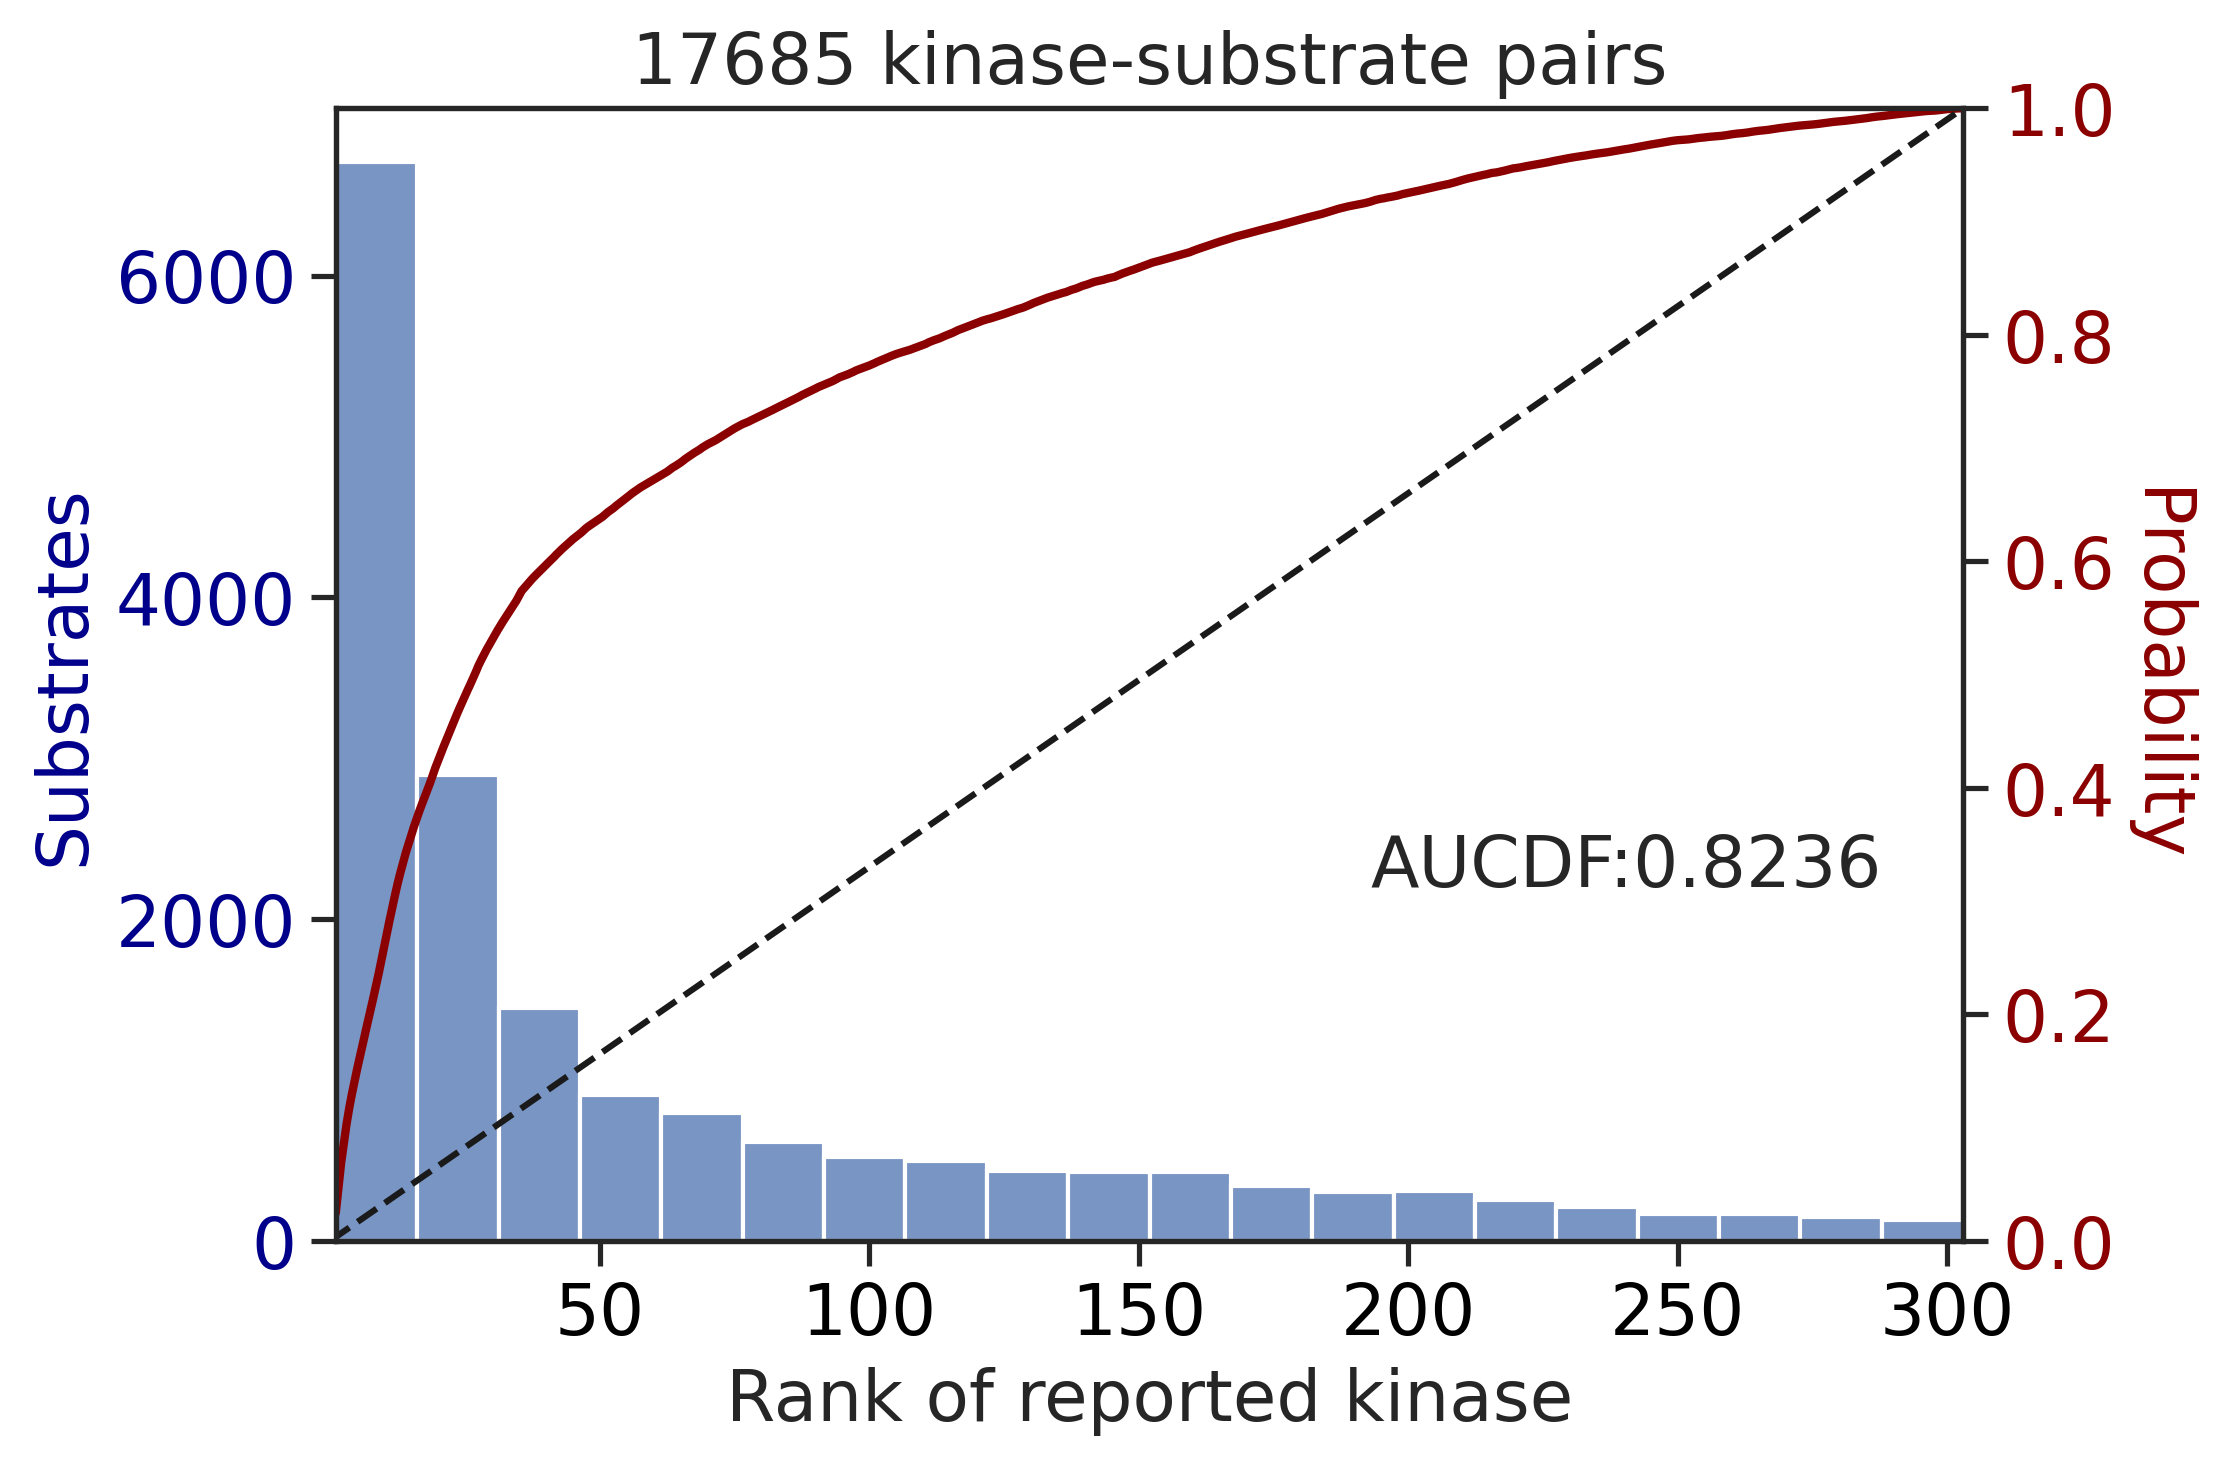

0.8235627655503237

In [ ]:
get_AUCDF(df_st,'st_rnk_sum_lo')

## Plot average rank for each kinase

The bar plot will reflect how accurate the prediction is for each kinase. The lower the y axis value is, the better.

In [ ]:
cnt_y = df_y.kinase.value_counts()
cnt_st = df_st.kinase.value_counts()

In [ ]:
df_y['count'] = df_y.kinase.map(cnt_y)
df_st['count'] = df_st.kinase.map(cnt_st)

In [ ]:
dd_y = df_y.query('count>=20')
dd_st = df_st.query('count>=20')

In [ ]:
bar_param = {'dots':False, 'fontsize':10, 'figsize':(17,3),'ascending':True}

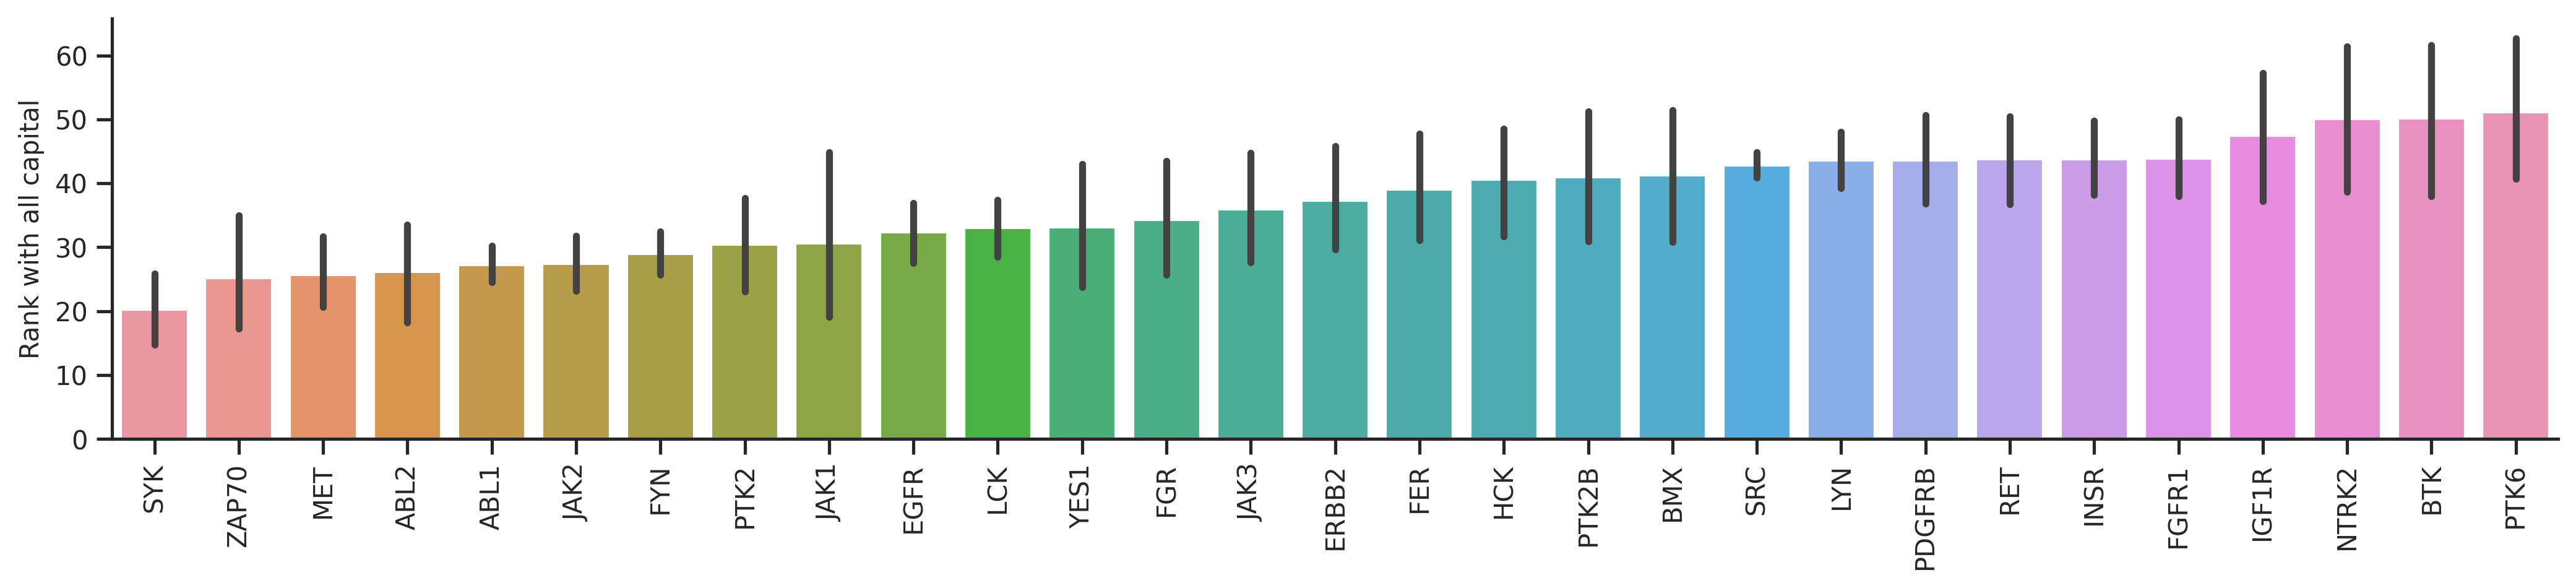

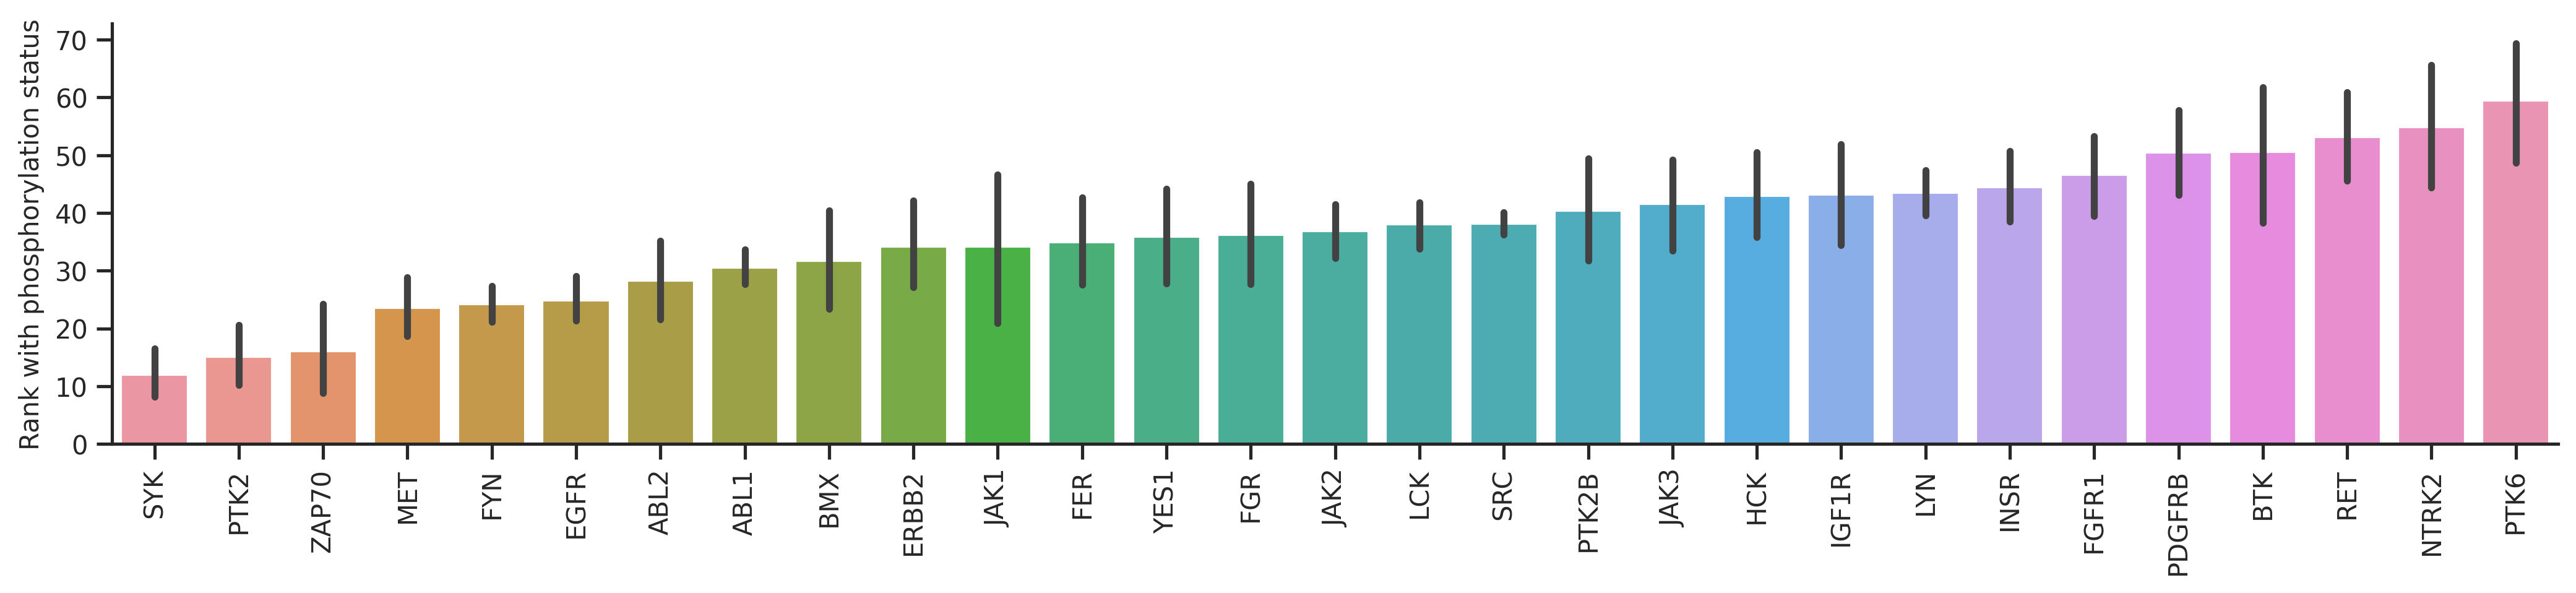

In [ ]:
plot_bar(dd_y,'y_rnk_mul_up','kinase',**bar_param)
plt.ylabel('Rank with all capital');

plot_bar(dd_y,'y_rnk_mul_lo','kinase',**bar_param)
plt.ylabel('Rank with phosphorylation status');

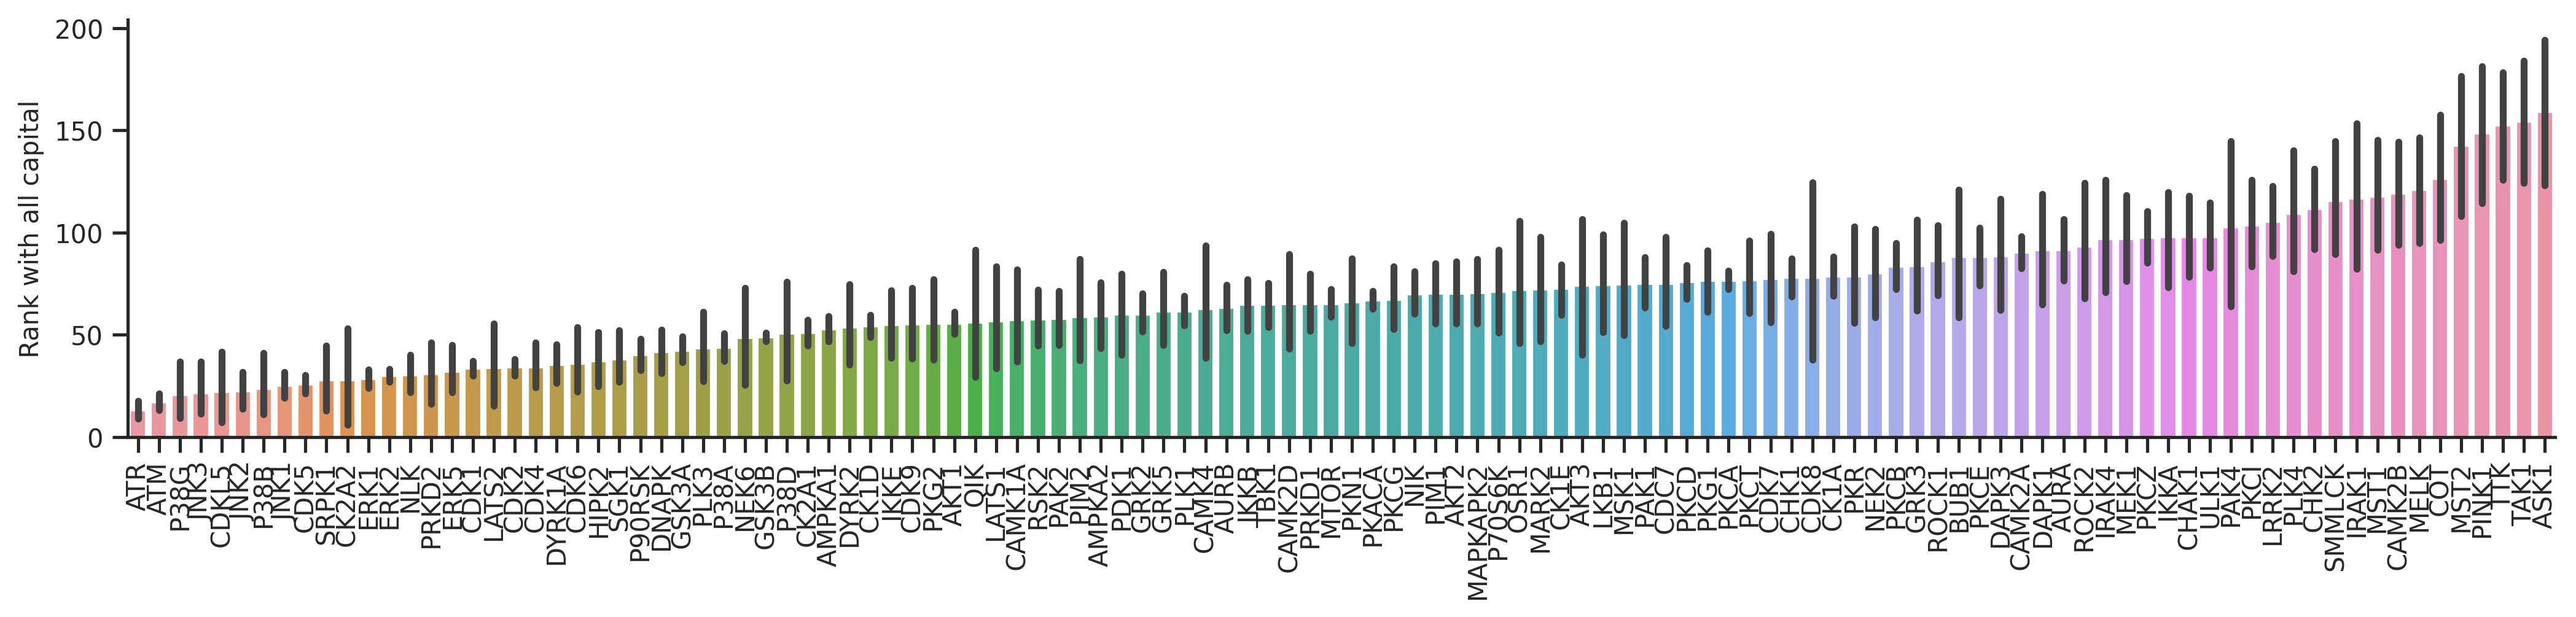

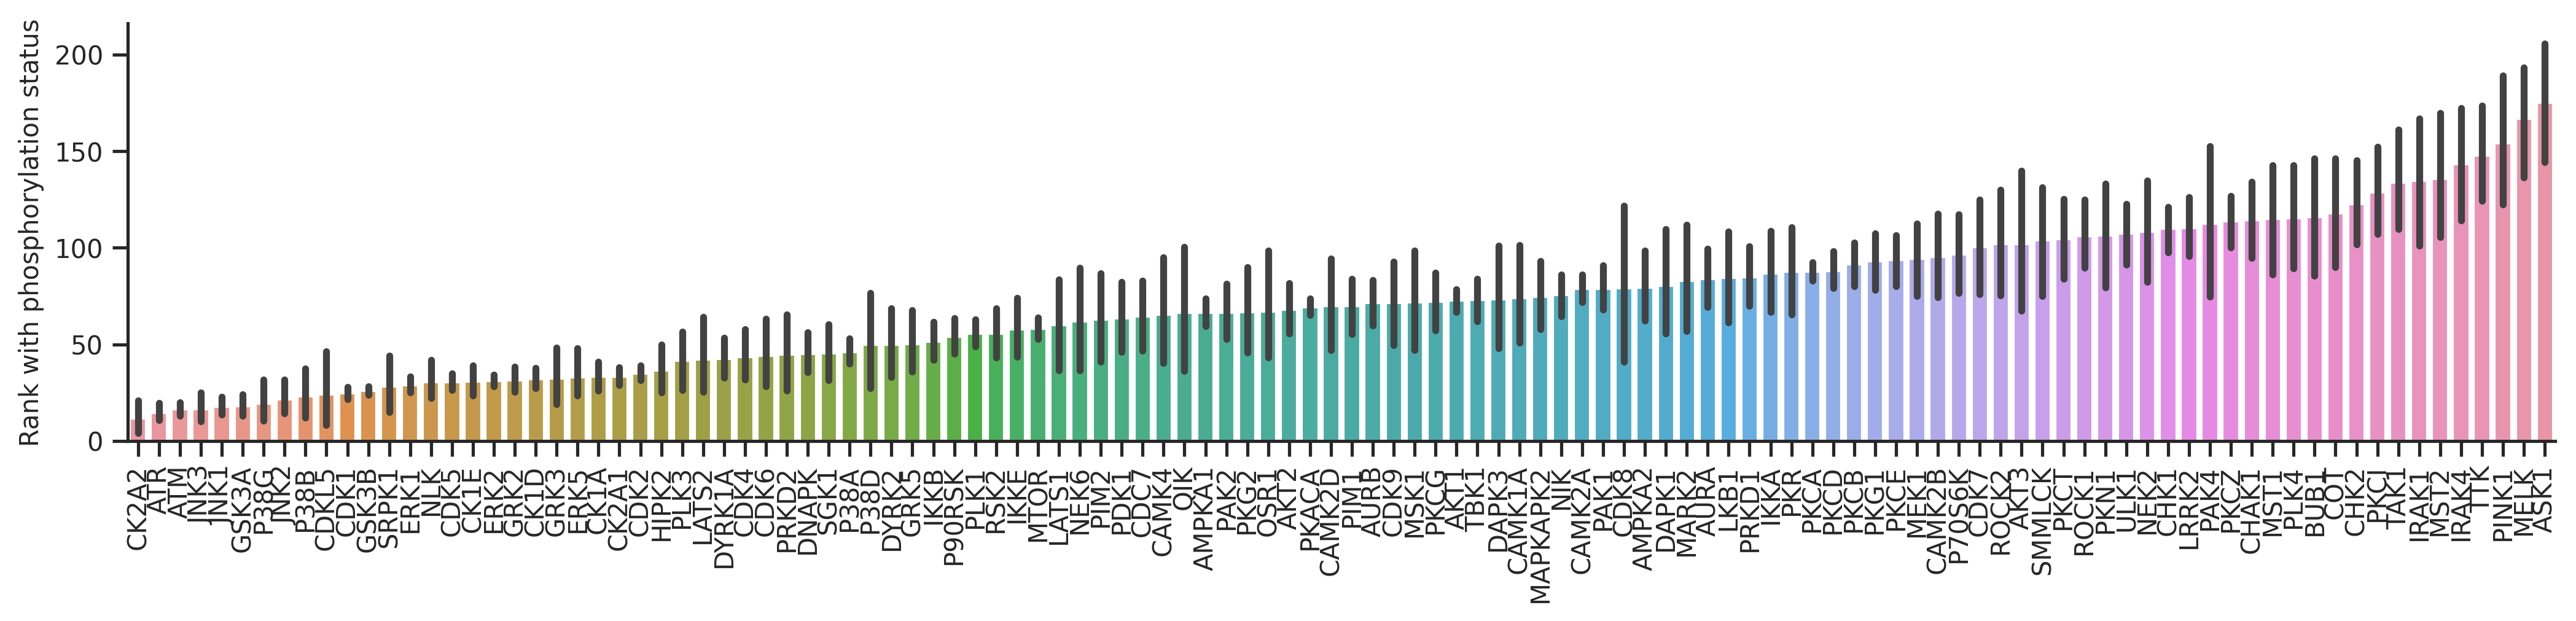

In [ ]:
plot_bar(dd_st,'st_rnk_mul_up','kinase',**bar_param)
plt.ylabel('Rank with all capital');

plot_bar(dd_st,'st_rnk_mul_lo','kinase',**bar_param)
plt.ylabel('Rank with phosphorylation status');

### Statistical analysis

In [ ]:
dd_y = dd_y.rename(columns={'y_rnk_mul_lo':'phosphorylated','y_rnk_mul_up':'all-capital'})
dd_st = dd_st.rename(columns={'st_rnk_mul_lo':'phosphorylated','st_rnk_mul_up':'all-capital'})

In [ ]:
import scipy.stats as stats

In [ ]:
delta_y = dd_y.groupby('kinase')[['all-capital', 'phosphorylated']].mean()
delta_st = dd_st.groupby('kinase')[['all-capital', 'phosphorylated']].mean()

In [ ]:
delta_y['diff'] = (delta_y['all-capital'] - delta_y['phosphorylated'])/delta_y['all-capital']
delta_st['diff'] = (delta_st['all-capital'] - delta_st['phosphorylated'])/delta_st['all-capital']

In [ ]:
delta_y.sort_values('diff',ascending=False).head()

all-capital  phosphorylated      diff
kinase                                       
PTK2      30.382979       15.170213  0.500700
SYK       20.233333       12.011111  0.406370
ZAP70     25.238095       16.119048  0.361321
EGFR      32.346457       24.929134  0.229309
BMX       41.250000       31.800000  0.229091

In [ ]:
def t_test(group):
    t_stat, p_val = stats.ttest_rel(group['all-capital'], group['phosphorylated'])
    return pd.Series({'t-statistic': t_stat, 'p-value': p_val})

In [ ]:
# Apply the t-test function to each group
ttest_y = dd_y.groupby('kinase').apply(t_test)

ttest_st = dd_st.groupby('kinase').apply(t_test)

In [ ]:
y_rnk_statistics = pd.concat([delta_y,ttest_y],axis=1)
st_rnk_statistics = pd.concat([delta_st,ttest_st],axis=1)

In [ ]:
y_rnk_statistics.head()

all-capital  phosphorylated      diff  t-statistic       p-value
kinase                                                                  
ABL1      27.249110       30.587189 -0.122502    -4.800813  2.575967e-06
ABL2      26.205882       28.352941 -0.081930    -1.498866  1.434148e-01
BMX       41.250000       31.800000  0.229091     2.516893  2.097901e-02
BTK       50.185185       50.629630 -0.008856    -0.676868  5.044680e-01
EGFR      32.346457       24.929134  0.229309     6.082135  1.314753e-08

## Plot all-capital vs. phosphorylated

In [ ]:
def plot_rnk(df,value_cols,group,figsize,order=None,fontsize=18,rotation=90,title=None,**kwargs):
    # Prepare the dataframe for plotting
    # Melt the dataframe to go from wide to long format
    df_melted = df.melt(id_vars=group, value_vars=value_cols, var_name='Ranking', value_name='Value')

    plt.figure(figsize=figsize)
    
    # Create the bar plot
    sns.barplot(data=df_melted, x=group, y='Value', hue='Ranking',order=order, 
                capsize=0.1,errwidth=1.5,errcolor='gray', # adjust the error bar settings
                **kwargs)
    
    # Increase font size for the x-axis and y-axis tick labels
    plt.tick_params(axis='x', labelsize=fontsize)  # Increase x-axis label size
    plt.tick_params(axis='y', labelsize=fontsize)  # Increase y-axis label size
    
    # Modify x and y label and increase font size
    plt.xlabel('', fontsize=fontsize)
    plt.ylabel('Rank of kinases (count≥20)', fontsize=fontsize)
    
    # Rotate X labels
    plt.xticks(rotation=rotation)
    
    # Plot titles
    if title is not None:
        plt.title(title, fontsize=fontsize)
    
    plt.gca().spines[['right', 'top']].set_visible(False)
    # plt.legend(title='Substrate', fontsize=fontsize-1, title_fontsize=fontsize-1)
    plt.legend(fontsize=fontsize)

In [ ]:
y_order = y_rnk_statistics.sort_values('diff',ascending=False).index
st_order = st_rnk_statistics.sort_values('diff',ascending=False).index

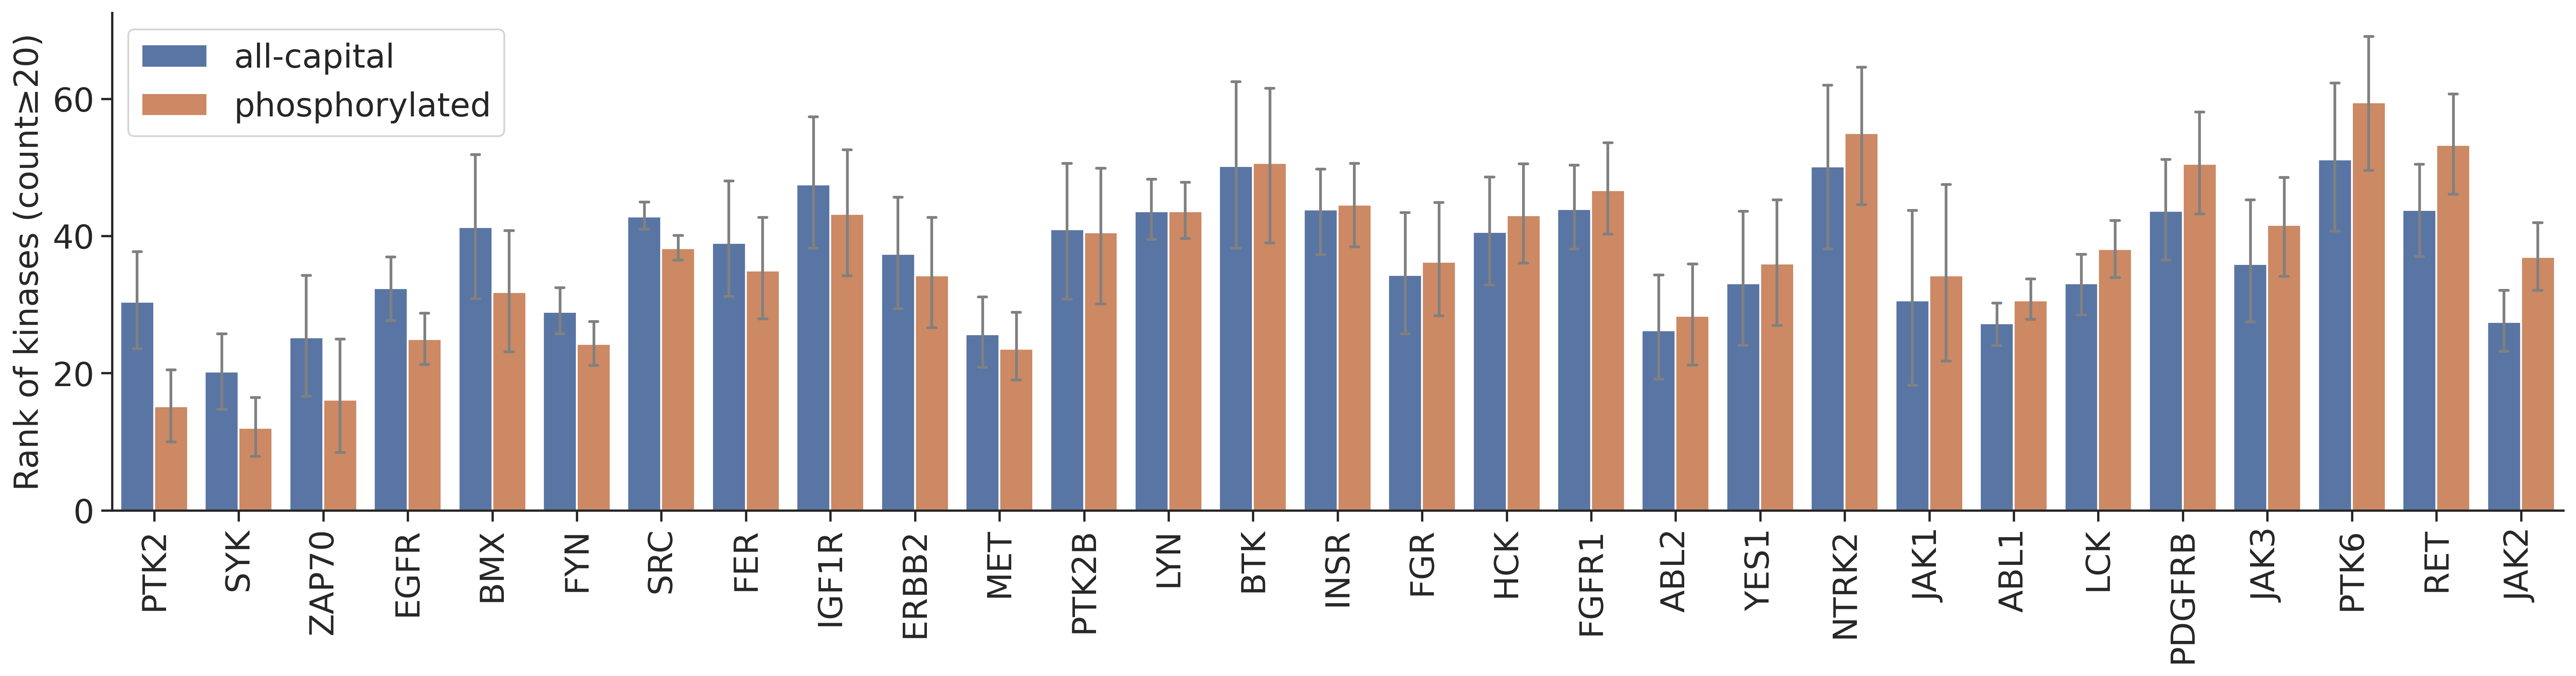

In [ ]:
plot_rnk(dd_y,['all-capital','phosphorylated'],'kinase',figsize=(24,5),order=y_order)

From the graph, it seems PTK2,SYK,ZAP70,EGFR,BMX rank increased a lot when considering phosphorylation status in the calculation. These kinases are known to prefer phosphopriming.

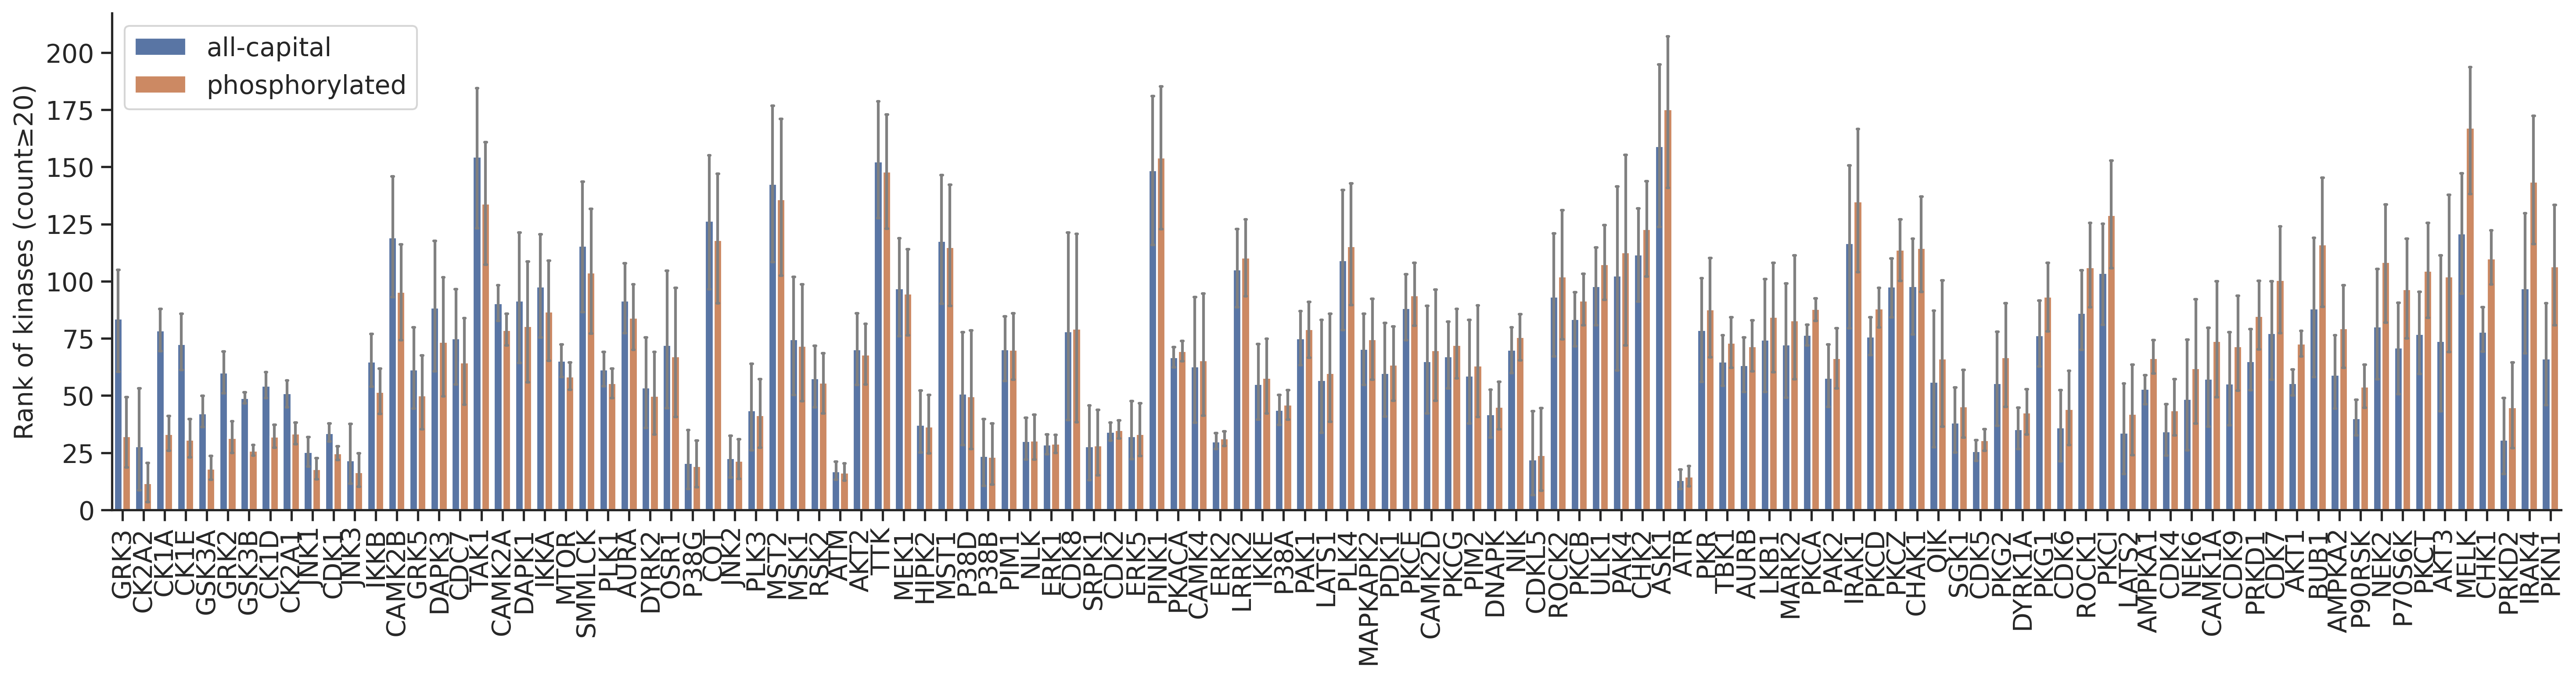

In [ ]:
plot_rnk(dd_st,['all-capital','phosphorylated'],'kinase',figsize=(24,5),order=st_order,fontsize=14)

From the graph, it seems GRK, CK2, CK1s, GSK3s rank increased a lot when considering phosphorylation status in the calculation. These kinases are known to prefer phosphopriming.

## CDDM scoring

As PSSMs from CDDM contains both tyrosine kinases and Ser/Thr kinases, we need to calculate AUCDF separately for each type.

In [51]:
set_sns()

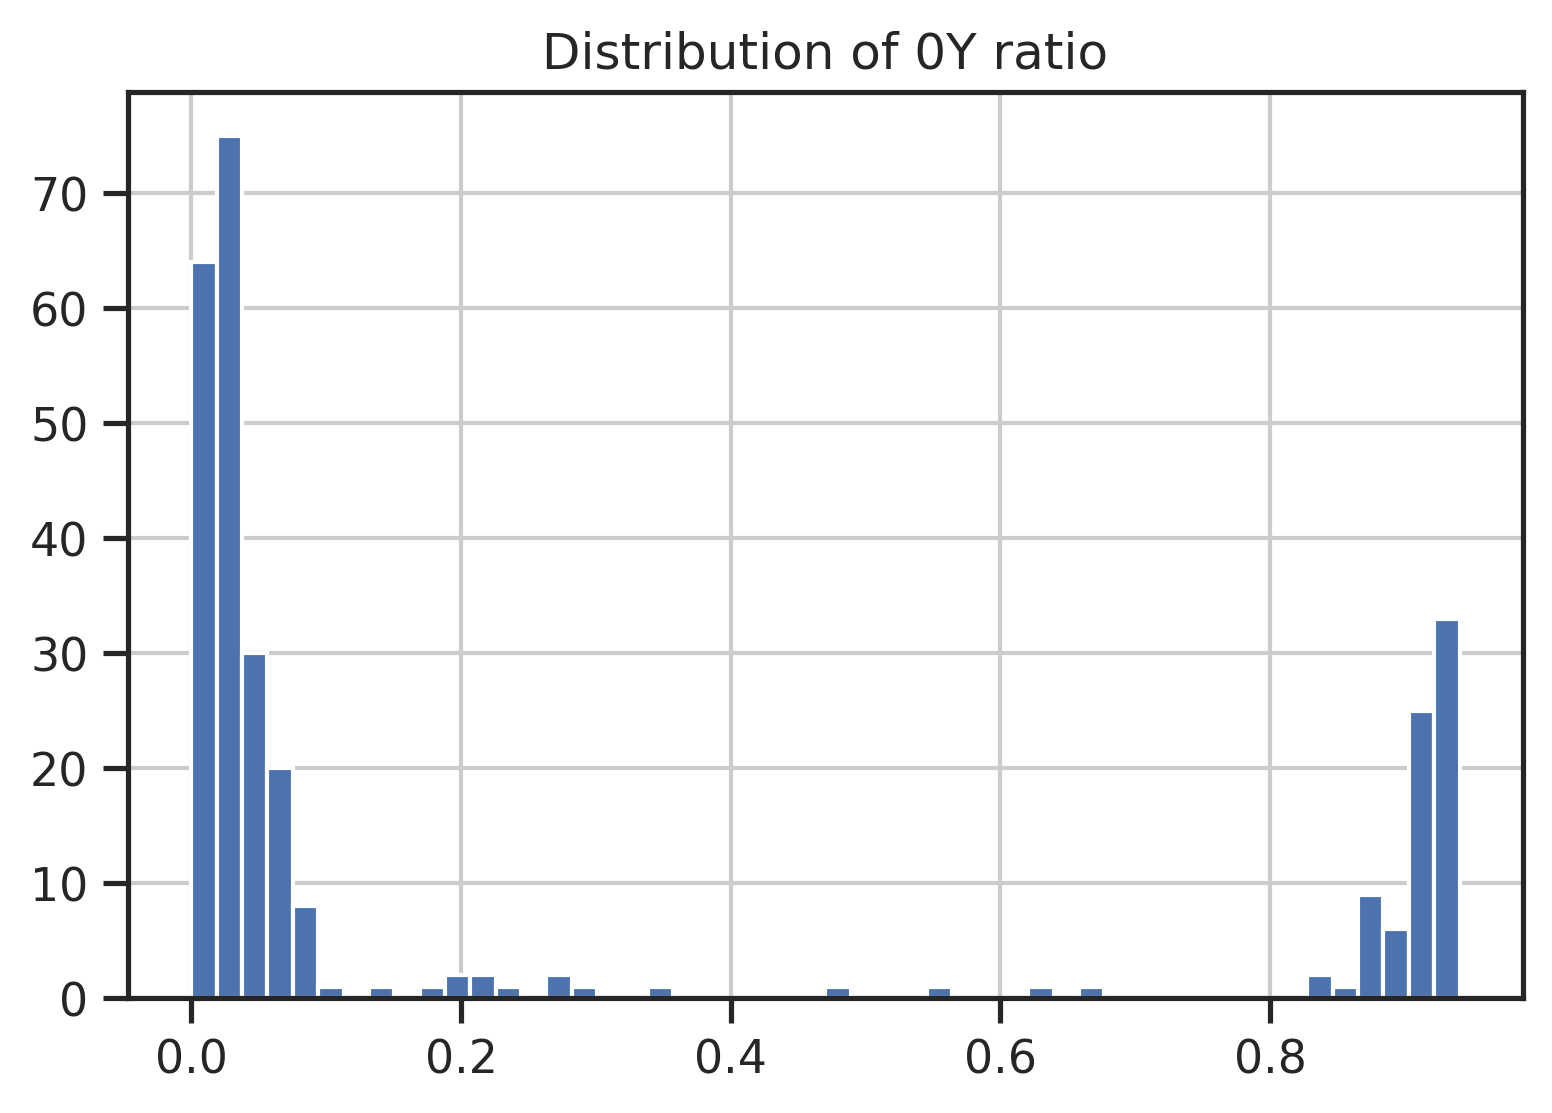

In [45]:
param_CDDM['ref']['0Y'].hist(bins=50)
plt.title('Distribution of 0Y ratio');

In [52]:
# Get TK and ST kinase list
TK = param_CDDM['ref']['0Y']>0.3
ST = param_CDDM['ref']['0Y']<0.7

TK = TK[TK].index.tolist()
ST = ST[ST].index.tolist()

### CDDM Scoring (contains lowercase STY indicating phosphorylation status)

In [47]:

# include only available kinase from the reference for scoring
TK_df = psp[psp.kinase.isin(TK)].copy()
ST_df = psp[psp.kinase.isin(ST)].copy()


# get log2(score)
ST_out = predict_kinase_df(ST_df,'site_seq',**param_CDDM)
TK_out = predict_kinase_df(TK_df,'site_seq',**param_CDDM)

# to rank, need to split TK and ST kinase columns
ST_out = ST_out[ST]
TK_out = TK_out[TK]

# get rank of score
TK_rnk = TK_out.rank(axis=1,ascending=False)
ST_rnk = ST_out.rank(axis=1,ascending=False)

TK_df['rnk']=match_values(TK_df,TK_rnk)
ST_df['rnk']=match_values(ST_df,ST_rnk)

input dataframe has a length 16799
Preprocessing
Finish preprocessing
Calculating position: [-7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7]


100%|██████████| 289/289 [00:51<00:00,  5.62it/s]


input dataframe has a length 3009
Preprocessing
Finish preprocessing
Calculating position: [-7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7]


100%|██████████| 289/289 [00:10<00:00, 27.98it/s]


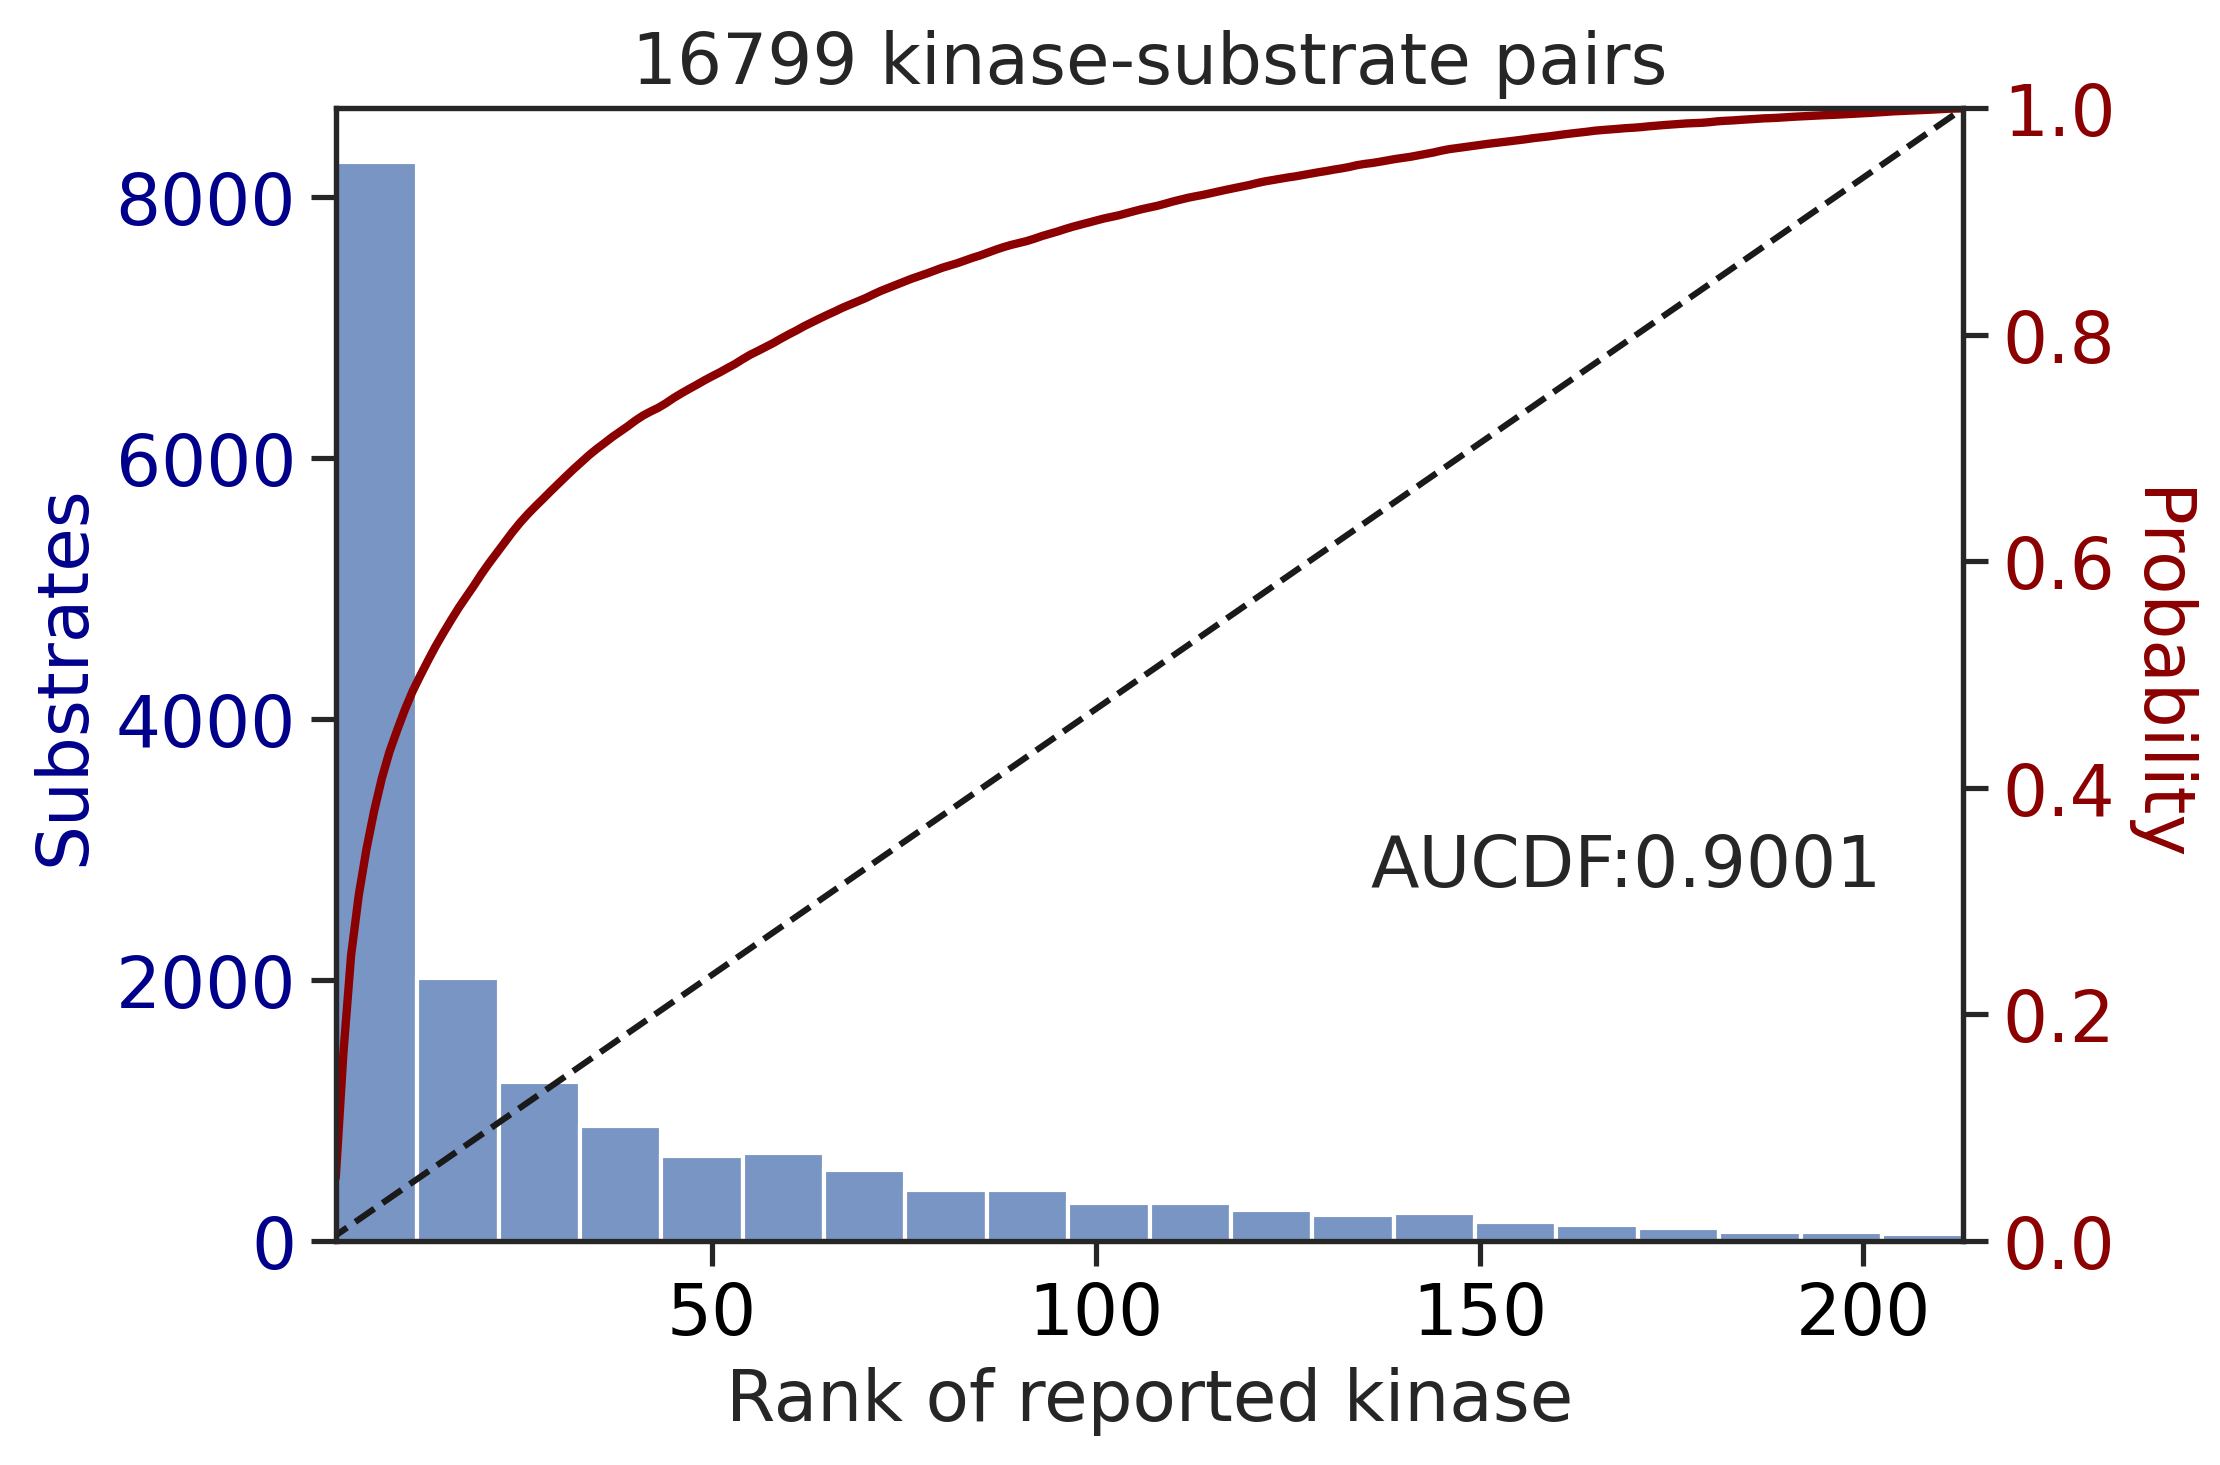

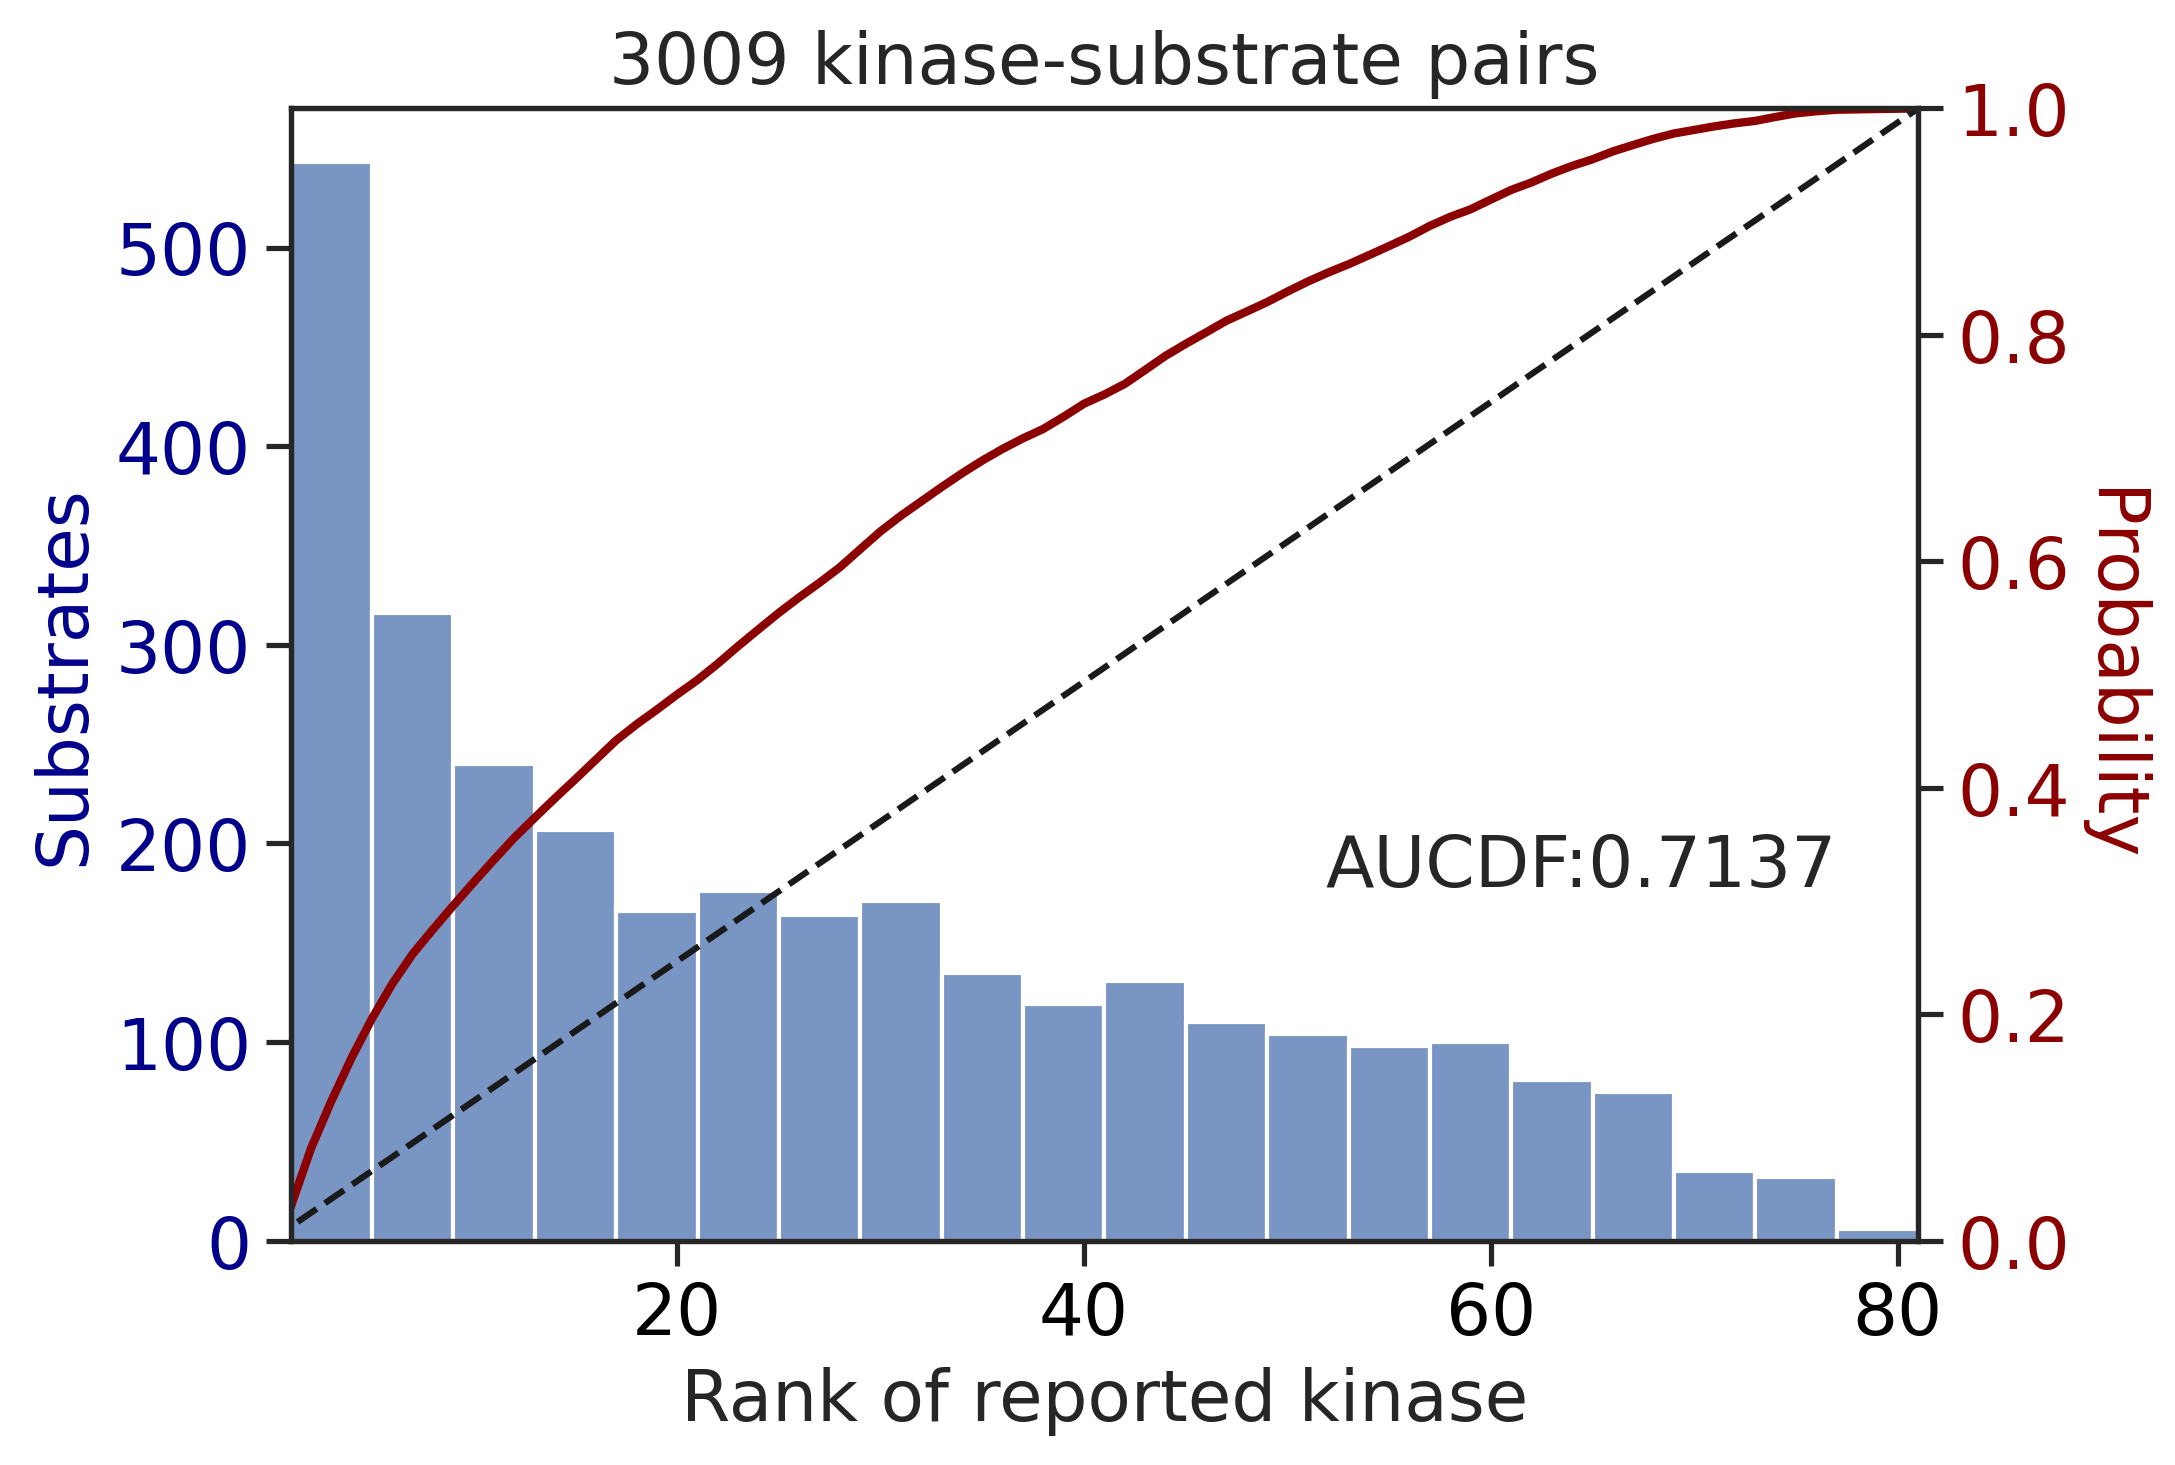

0.7136624421990068

In [ ]:
get_AUCDF(ST_df,'rnk')
get_AUCDF(TK_df,'rnk')

### CDDM scoring (all capital)

In [53]:
# convert to capital
TK_df['site_seq_upper']=TK_df['site_seq'].str.upper()
ST_df['site_seq_upper']=ST_df['site_seq'].str.upper()

# get log2(score)
ST_out_upper = predict_kinase_df(ST_df,'site_seq_upper',**param_CDDM_upper)
TK_out_upper = predict_kinase_df(TK_df,'site_seq_upper',**param_CDDM_upper)

# to rank, need to split TK and ST kinase columns
ST_out_upper = ST_out_upper[ST]
TK_out_upper = TK_out_upper[TK]

# get rank of score
ST_rnk_upper = ST_out_upper.rank(axis=1,ascending=False)
TK_rnk_upper = TK_out_upper.rank(axis=1,ascending=False)

ST_df['rnk_upper']=match_values(ST_df,ST_rnk_upper)
TK_df['rnk_upper']=match_values(TK_df,TK_rnk_upper)

input dataframe has a length 16799
Preprocessing
Finish preprocessing
Calculating position: [-7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7]


100%|██████████| 289/289 [01:06<00:00,  4.36it/s]


input dataframe has a length 3009
Preprocessing
Finish preprocessing
Calculating position: [-7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7]


100%|██████████| 289/289 [00:06<00:00, 42.56it/s]


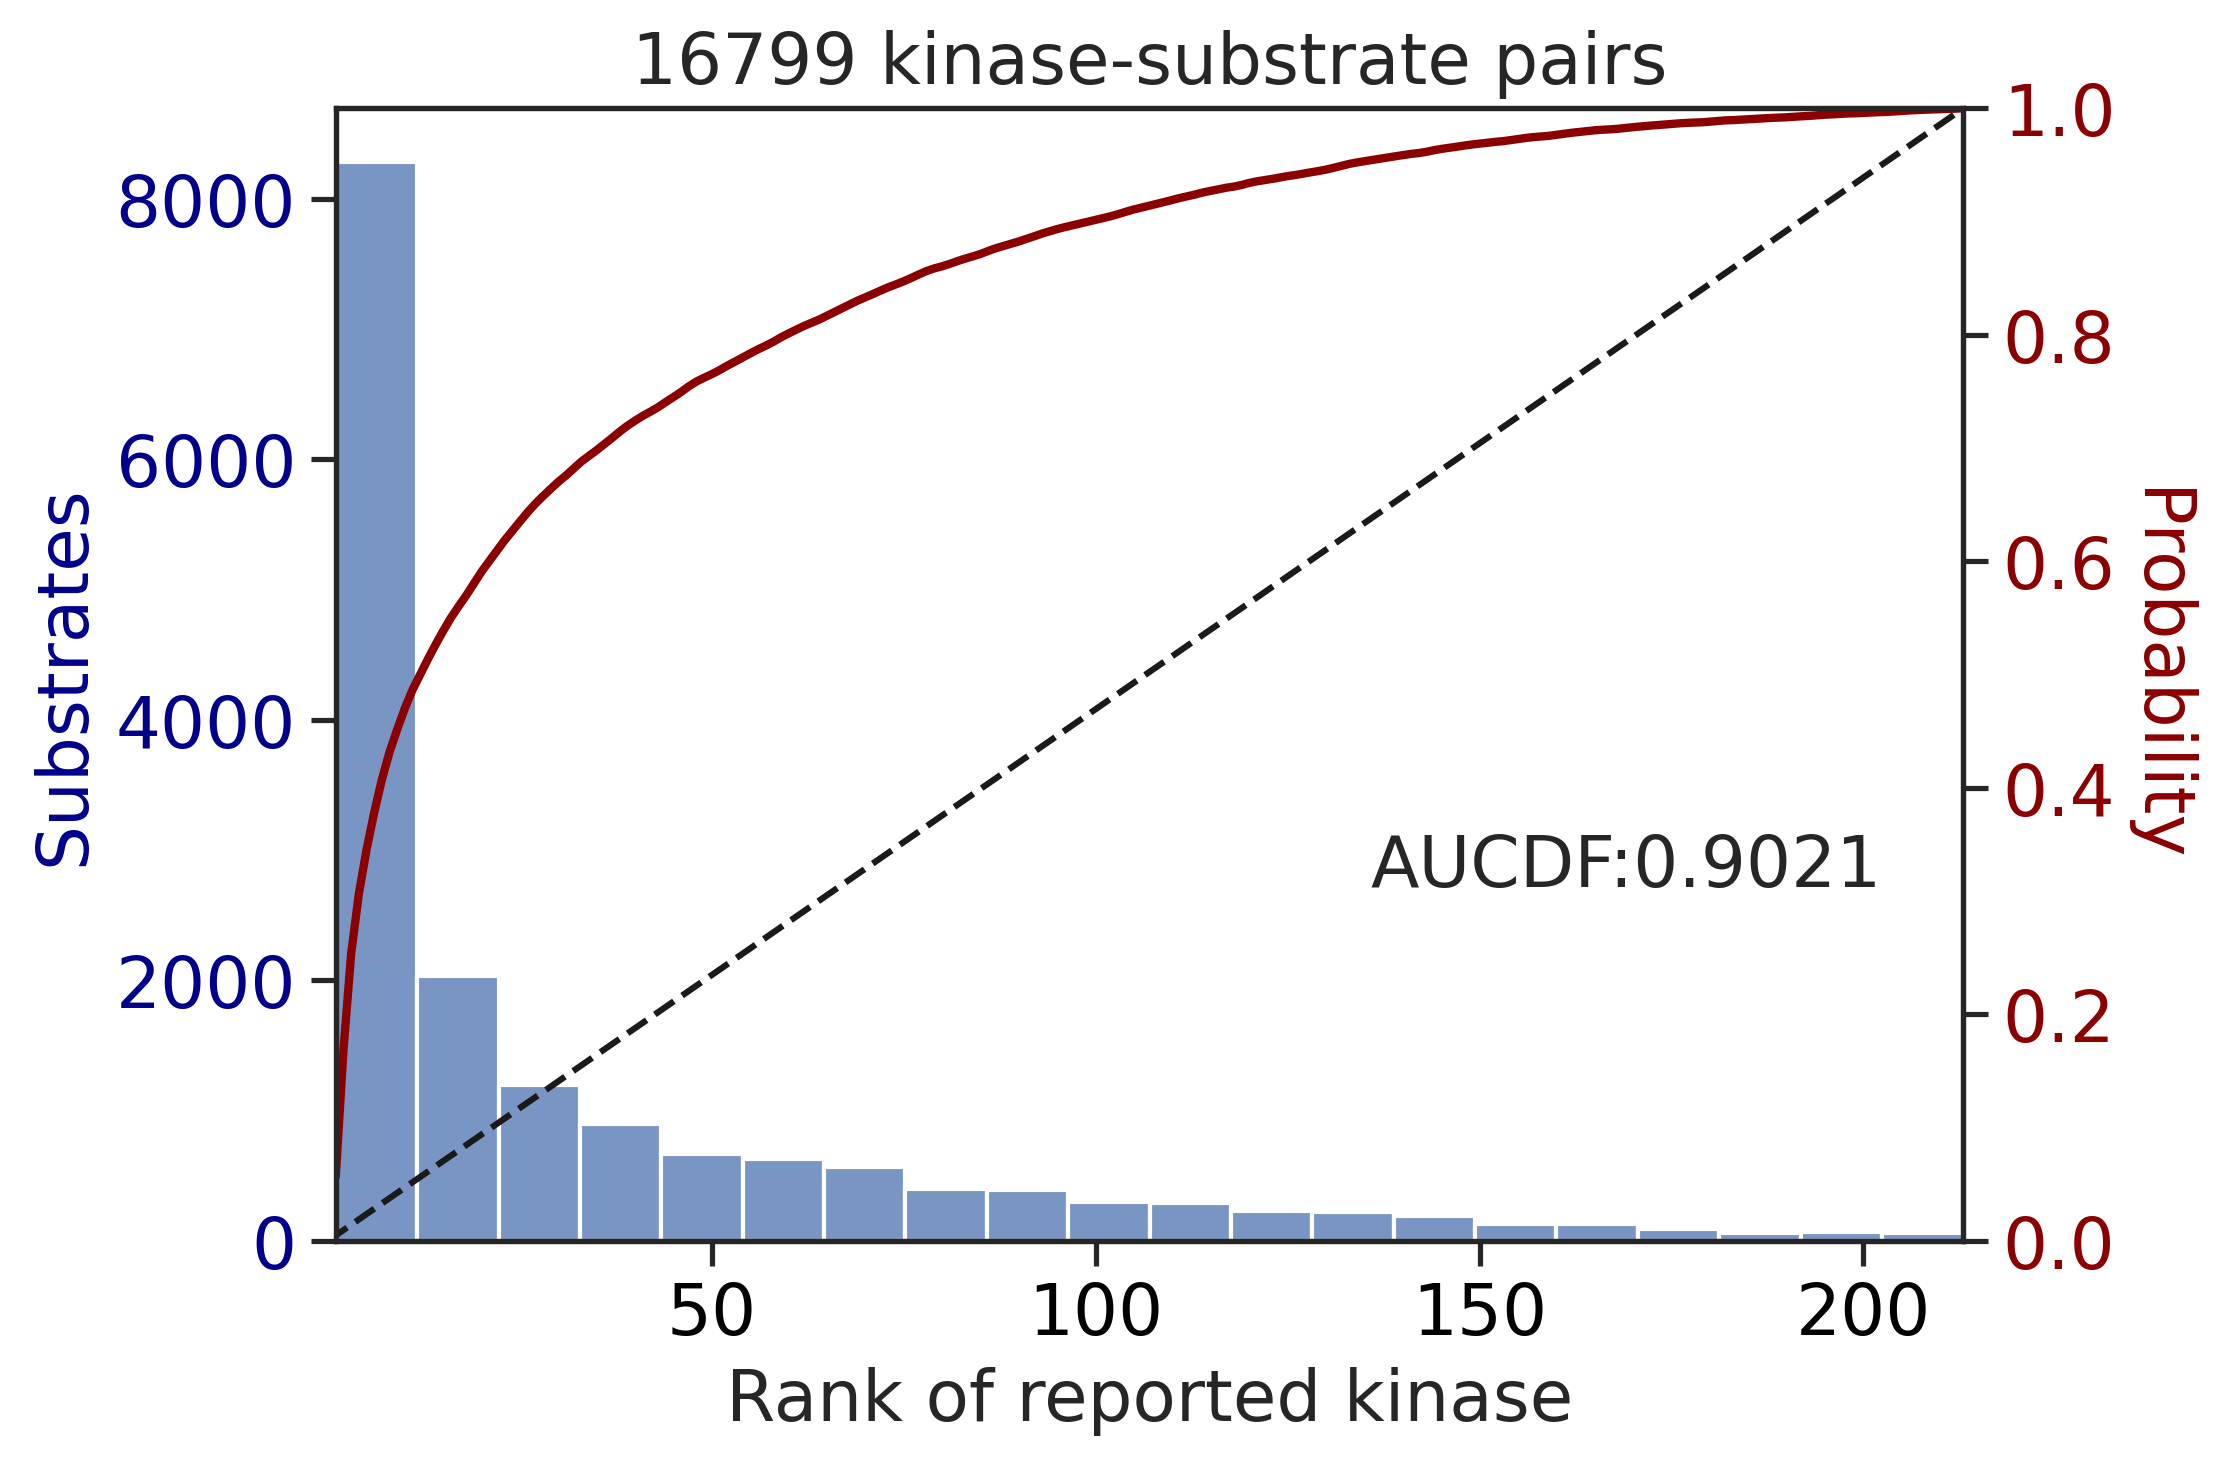

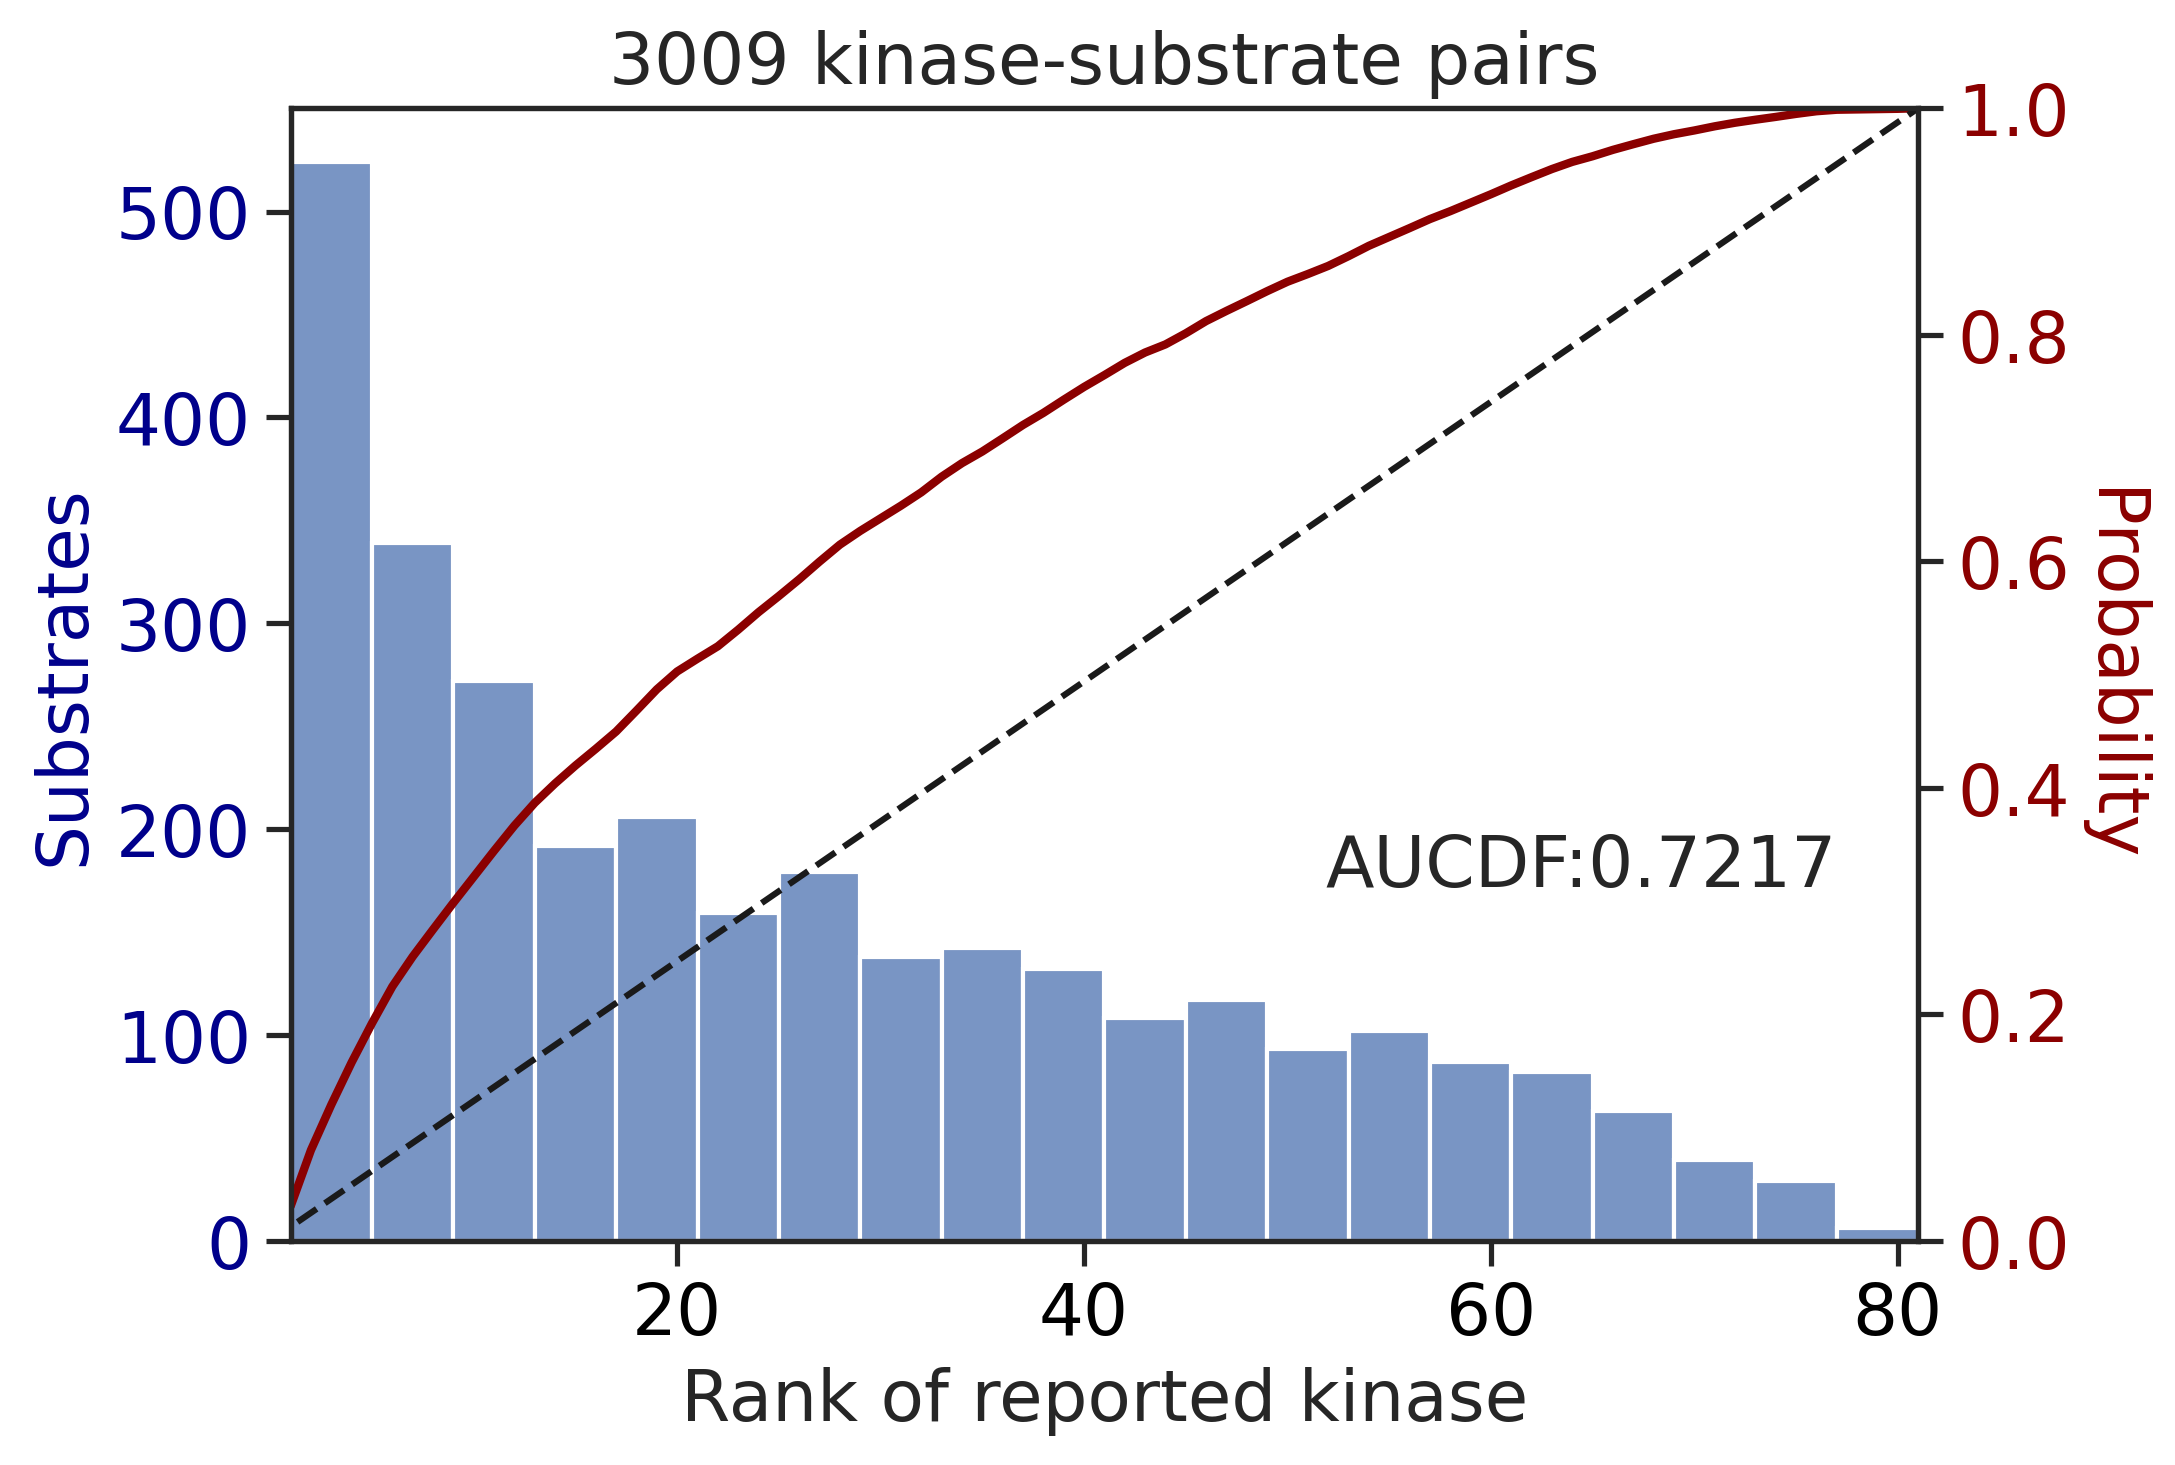

0.7216848757497858

In [ ]:
get_AUCDF(ST_df,'rnk_upper')
get_AUCDF(TK_df,'rnk_upper')

## Plot rank

Find the corresponding rank and map them in the kinase-substrate dataset

In [ ]:
ST_cnt = ST_df.kinase.value_counts()
TK_cnt = TK_df.kinase.value_counts()

ST_df['count'] = ST_df.kinase.map(ST_cnt)
TK_df['count'] = TK_df.kinase.map(TK_cnt)

In [ ]:
# remove kinases that have substrate pairs less than 20
st_v = ST_df.query('count>=20')
tk_v = TK_df.query('count>=20')

For the rank value, the lower the better.

Text(0, 0.5, 'Rank of kinases')

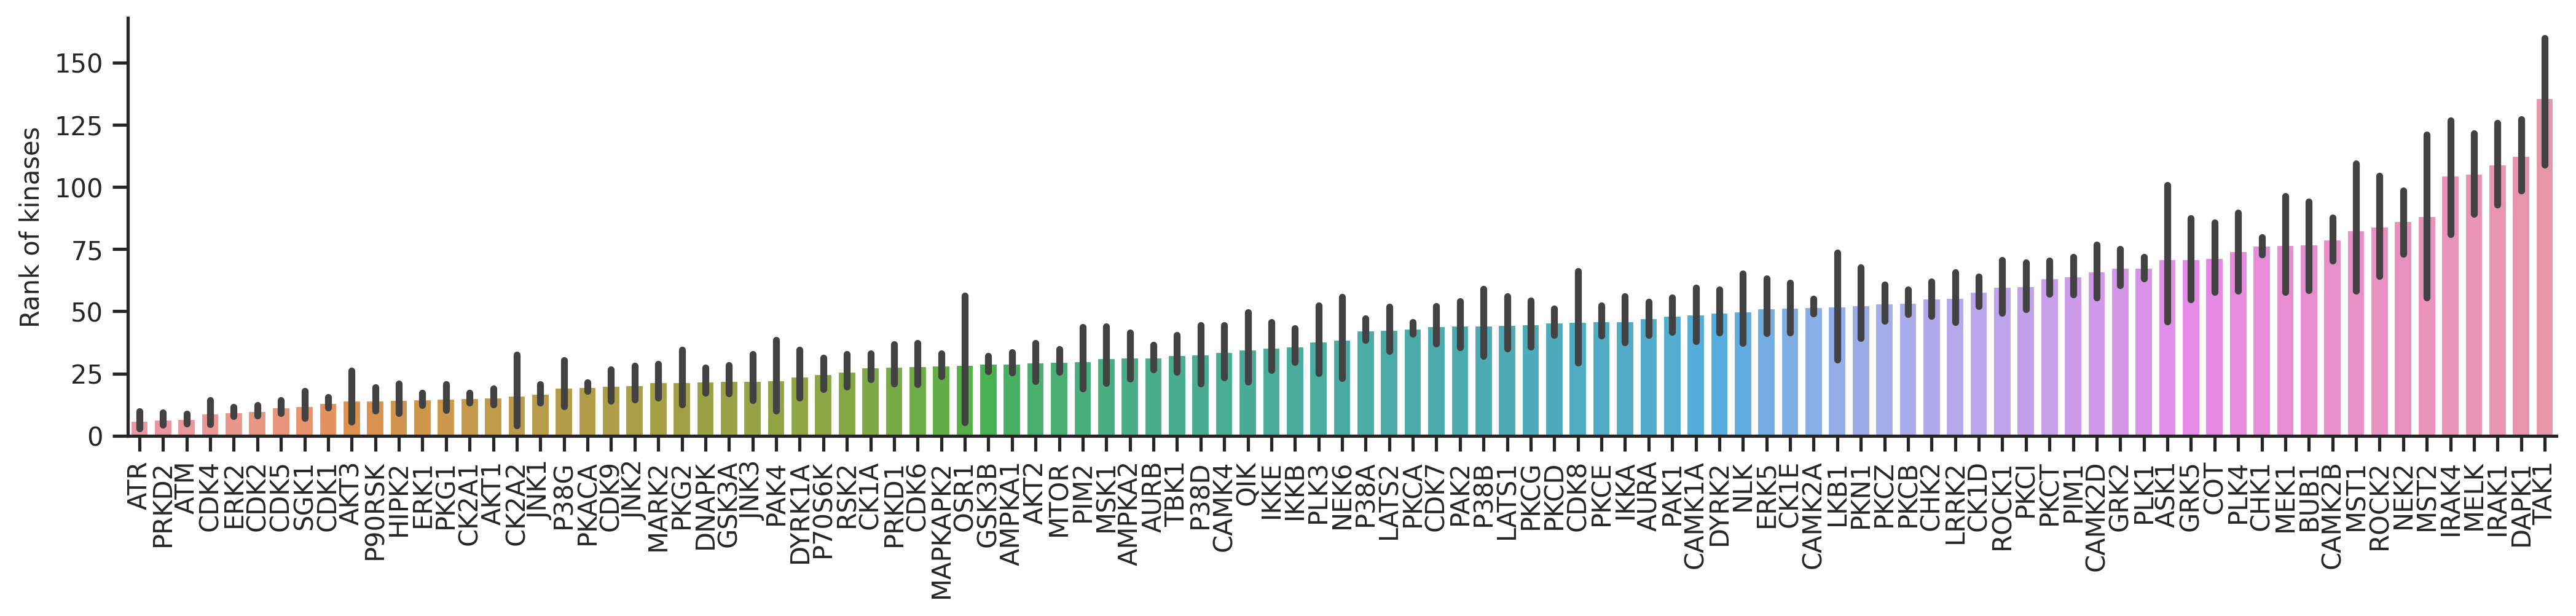

In [ ]:
plot_bar(st_v,'rnk','kinase',**bar_param)
plt.ylabel('Rank of kinases')

Text(0, 0.5, 'Rank of kinases')

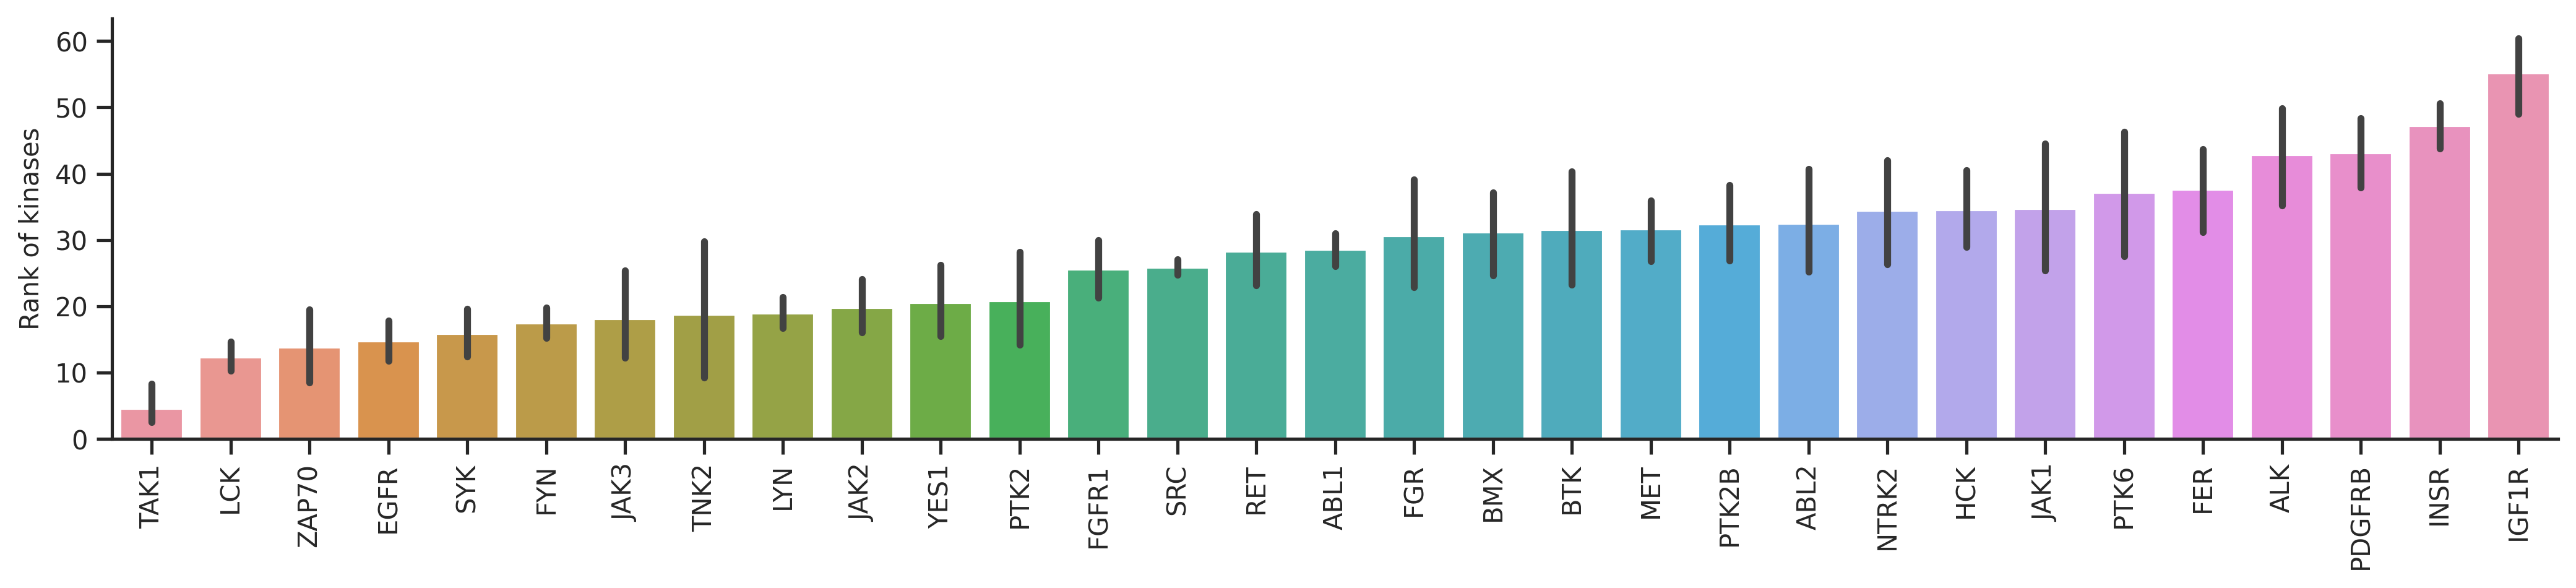

In [ ]:
plot_bar(tk_v,'rnk','kinase',**bar_param)
plt.ylabel('Rank of kinases')